In [1]:
# import & setting
import math
import os
import random

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import torch
import umap
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'


current_dir = os.getcwd()
figs_dir = os.path.join(current_dir, "results", "figs")
os.makedirs(figs_dir, exist_ok=True)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

plt.rcParams.update({'font.size': 14})
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14



def setup_simulation_parameters(device):
    amp_table = torch.tensor([
        10.000, 11.832, 13.509, 15.414, 17.615, 18.240, 20.172, 21.626, 22.309, 23.054, 23.820, 23.820, 23.820,
        24.650, 24.650, 26.306, 29.052, 32.140, 35.496, 39.243, 41.952, 46.411, 47.958, 49.598, 53.009, 56.657,
        58.652, 60.581, 62.610, 64.885, 67.007, 69.282, 71.624, 71.624, 76.551, 76.551, 79.183, 84.676, 84.676,
        87.579, 90.388, 93.488, 93.488, 93.488, 96.695, 100.000, 96.695, 93.488, 93.488, 93.488, 90.388,
        87.579, 84.676, 84.676, 79.183, 76.551, 76.551, 71.624, 71.624, 69.282, 67.007, 64.885, 62.610,
        60.581, 58.652, 56.657, 53.009, 49.598, 47.958, 46.411, 41.952, 39.243, 35.496, 32.140, 29.052,
        26.306, 24.650, 24.650, 23.820, 23.820, 23.820, 23.054, 22.309, 21.626, 20.172, 18.240, 17.615,
        15.414, 13.509, 11.832, 10.000
    ], dtype=torch.float64, device=device)
    frequency = 40000.0
    speed_of_sound = 343.0
    wavelength = speed_of_sound / frequency
    x_coords = np.arange(-3.5, 4.5, 1.0)
    y_coords = np.arange(-3.5, 4.5, 1.0)
    transducer_positions = torch.tensor([(x * 0.01, y * 0.01, 0.0) for x in x_coords for y in y_coords], dtype=torch.float64, device=device)
    grid_size = 201
    x_vals = torch.linspace(-0.05, 0.05, grid_size, dtype=torch.float64, device=device)
    y_vals = torch.linspace(-0.05, 0.05, grid_size, dtype=torch.float64, device=device)
    z_vals = torch.linspace(0, 0.1, grid_size, dtype=torch.float64, device=device)
    dx = (x_vals[1] - x_vals[0]).item()
    params = {
        "amp_table": amp_table, "wavelength": wavelength, "transducer_positions": transducer_positions,
        "x_vals": x_vals, "y_vals": y_vals, "z_vals": z_vals,
        "dx": dx, "dy": dx, "dz": dx, "frequency": frequency
    }
    return params

def compute_pressure_field_torch(phase_vector, params, X, Y, Z):
    k_val = 2.0 * math.pi / params["wavelength"]
    grid_points = torch.stack([X.ravel(), Y.ravel(), Z.ravel()], dim=1)
    delta = grid_points.unsqueeze(1) - params["transducer_positions"].unsqueeze(0)
    R = torch.sqrt(torch.sum(delta**2, dim=2))
    R = torch.clamp(R, min=1e-9)
    cos_theta = torch.clamp(delta[:, :, 2] / R, -1.0, 1.0)
    theta_deg = torch.rad2deg(torch.acos(cos_theta))
    theta_deg_clamped = torch.clamp(theta_deg, 0.0, 90.0)
    max_angle_index = params["amp_table"].shape[0] - 1
    low_index_f = theta_deg_clamped / 1.0
    low_index = torch.floor(low_index_f).long()
    high_index = torch.clamp(low_index + 1, max=max_angle_index)
    frac = low_index_f - low_index.double()
    A_low = params["amp_table"][low_index]
    A_high = params["amp_table"][high_index]
    A_theta = A_low + frac * (A_high - A_low)
    amplitude = A_theta / R
    propagation_phase = k_val * R
    total_phase = phase_vector.unsqueeze(0) + propagation_phase
    p_complex_per_transducer = torch.polar(amplitude, total_phase)
    p_field = torch.sum(p_complex_per_transducer, dim=1)
    return p_field.reshape(X.shape)

def calculate_laplacian_at_target(phase_tensor, params, target_indices):
    x_idx, y_idx, z_idx = target_indices
    half = 2
    x_local = params["x_vals"][x_idx-half : x_idx+half+1]
    y_local = params["y_vals"][y_idx-half : y_idx+half+1]
    z_local = params["z_vals"][z_idx-half : z_idx+half+1]
    X_local, Y_local, Z_local = torch.meshgrid(x_local, y_local, z_local, indexing='ij')
    pf_local = compute_pressure_field_torch(phase_tensor, params, X_local, Y_local, Z_local)
    rho0, c0, rho_p, c_p = 1.225, 343.0, 100.0, 2400.0
    omega = 2 * math.pi * params["frequency"]
    r_particle = 1.3e-3 / 2
    V = 4/3 * math.pi * r_particle**3
    K1 = 0.25 * V * (1 / (c0**2 * rho0) - 1 / (c_p**2 * rho_p))
    K2 = 0.75 * V * ((rho0 - rho_p) / (omega**2 * rho0 * (rho0 + 2 * rho_p)))
    dx, dy, dz = params["dx"], params["dy"], params["dz"]
    abs_p2 = torch.abs(pf_local)**2
    grad_p = torch.gradient(pf_local, spacing=(dx, dy, dz), edge_order=1)
    v_sq = torch.abs(grad_p[0])**2 + torch.abs(grad_p[1])**2 + torch.abs(grad_p[2])**2
    U = K1 * abs_p2 - K2 * v_sq
    grad_U = torch.gradient(U, spacing=(dx, dy, dz), edge_order=1)
    grad_U_x, grad_U_y, grad_U_z = grad_U
    L_xx, _, _ = torch.gradient(grad_U_x, spacing=(dx, dy, dz), edge_order=1)
    _, L_yy, _ = torch.gradient(grad_U_y, spacing=(dx, dy, dz), edge_order=1)
    _, _, L_zz = torch.gradient(grad_U_z, spacing=(dx, dy, dz), edge_order=1)
    lapU = L_xx + L_yy + L_zz
    return lapU[half, half, half].item()

def calculate_eci_and_nts(pressure_slice, laplacian_value, params, target_coords, roi_radius=0.015):
    x_vals_np = params["x_vals"].cpu().numpy()
    y_vals_np = params["y_vals"].cpu().numpy()
    target_x, target_y = target_coords[0], target_coords[1]
    energy_slice = pressure_slice**2
    e_total = np.sum(energy_slice)
    y_grid, x_grid = np.meshgrid(y_vals_np, x_vals_np)
    distance_sq = (x_grid - target_x)**2 + (y_grid - target_y)**2
    roi_mask = distance_sq <= roi_radius**2
    e_roi = np.sum(energy_slice[roi_mask])
    eci = e_roi / e_total if e_total > 0 else 0
    nts = laplacian_value / e_total if e_total > 0 else 0
    return eci, nts

def compute_z_slice_directly_batched(phase_vector, z_idx, params, device, batch_size=65536):
    x_vals, y_vals, z_vals = params["x_vals"], params["y_vals"], params["z_vals"]
    grid_size = x_vals.shape[0]
    n_pts_slice = grid_size * grid_size
    p_slice_flat = torch.zeros(n_pts_slice, dtype=torch.complex128, device='cpu')
    const_Z = z_vals[z_idx].view(1, 1, 1)
    for i in range(0, n_pts_slice, batch_size):
        current_batch_size = min(i + batch_size, n_pts_slice) - i
        indices = torch.arange(i, i + current_batch_size, device=device)
        ix = torch.div(indices, grid_size, rounding_mode='floor')
        iy = indices % grid_size
        batch_X = x_vals[ix].view(-1, 1, 1)
        batch_Y = y_vals[iy].view(-1, 1, 1)
        batch_Z = const_Z.expand(current_batch_size, 1, 1)
        batch_p_slice = compute_pressure_field_torch(phase_vector, params, batch_X, batch_Y, batch_Z)
        p_slice_flat[i:i + current_batch_size] = batch_p_slice.cpu().ravel()
    return p_slice_flat.reshape(grid_size, grid_size)

def collect_gl_points_from_df(df: pd.DataFrame, label_index: int):
    required = {"laplacian", "gorkov_grad_mag"}
    if not required.issubset(df.columns):
        raise ValueError(f"The required columns are missing in the CSV.: {required - set(df.columns)}")

    if "trial" in df.columns and "step" in df.columns:
        df_use = (df.sort_values(["trial", "step"])
                    .groupby("trial", as_index=False)
                    .tail(1))
    elif "step" in df.columns:
        df_use = df[df["step"] == df["step"].max()]
    else:
        df_use = df

    laps = df_use["laplacian"].to_numpy(dtype=float)
    gmgs = df_use["gorkov_grad_mag"].to_numpy(dtype=float)
    lbls = np.full(shape=len(laps), fill_value=label_index, dtype=int)
    return laps, gmgs, lbls

def plot_gl(laplacians: np.ndarray, ggrad_mags: np.ndarray, labels: np.ndarray,
            label_names: list, color_map: dict, outfile: str = "gl_plot.png"):
    plt.figure(figsize=(10, 8))
    for i, name in enumerate(label_names):
        mask = (labels == i)
        if np.any(mask):
            current_color = color_map.get(name, 'gray')
            marker_style = 'x' if name == 'HybridVortex' else 'o'
            marker_size = 80 if name == 'HybridVortex' else 50
            plt.scatter(laplacians[mask], ggrad_mags[mask], label=name, alpha=0.7,
                        s=marker_size, color=current_color, marker=marker_style)
    plt.title("GL Plot: Laplacian vs. Gorkov Gradient Magnitude")
    plt.xlabel("Laplacian", fontsytle='italic')
    plt.ylabel("Gorkov gradient magnitude (gorkov_grad_mag)", fontsytle='italic')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    print(f"[OK] GL plot saved to: {outfile}")
    plt.show()
    plt.close()

/home/test/anaconda3/envs/colab-match-env3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/test/anaconda3/envs/colab-match-env3/lib/python3.12/site-packages/umap/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
import os
import time
import math
import numpy as np
import pandas as pd
import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

import torch
from scipy.optimize import minimize


BASE_OUTPUT_DIR = os.path.join("results")

TARGET_COORD = (0.01, 0.01, 0.03)


W_LAPLACIAN = 1.0
ALPHA_F = 500.0
BETA_P = 5e-5

W_LAPLACIAN_XX = 1
W_LAPLACIAN_YY = 1
W_LAPLACIAN_ZZ = 1

EPS_REL = 1e-3

GENERATE_SLICE_PLOTS = True


GENERATE_DECISION_SLICES = True
SLICE_HALF_RANGE = 0.30
SLICE_N_1D = 81
SLICE_N_2D = 61

NUM_TRIALS = 1
NUM_OPT_STEPS = 10000

SPEC_EVERY = 200
SPEC_K = 10
HVP_EPS = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(random_seed)
print(f"[INFO] Using Fixed Random Seed: {random_seed}")

amp_table = torch.tensor([
    10.000, 11.832, 13.509, 15.414, 17.615, 18.240, 20.172, 21.626, 22.309, 23.054, 23.820, 23.820, 23.820,
    24.650, 24.650, 26.306, 29.052, 32.140, 35.496, 39.243, 41.952, 46.411, 47.958, 49.598, 53.009, 56.657,
    58.652, 60.581, 62.610, 64.885, 67.007, 69.282, 71.624, 71.624, 76.551, 76.551, 79.183, 84.676, 84.676,
    87.579, 90.388, 93.488, 93.488, 93.488, 96.695, 100.000, 96.695, 93.488, 93.488, 93.488, 90.388, 87.579,
    84.676, 84.676, 79.183, 76.551, 76.551, 71.624, 71.624, 69.282, 67.007, 64.885, 62.610, 60.581, 58.652,
    56.657, 53.009, 49.598, 47.958, 46.411, 41.952, 39.243, 35.496, 32.140, 29.052, 26.306, 24.650, 24.650,
    23.820, 23.820, 23.820, 23.054, 22.309, 21.626, 20.172, 18.240, 17.615, 15.414, 13.509, 11.832, 10.000
], dtype=torch.float64, device=device)

frequency = 40000.0
speed_of_sound = 343.0
wavelength = speed_of_sound / frequency

x_coords = np.arange(-3.5, 4.5, 1.0)
y_coords = np.arange(-3.5, 4.5, 1.0)
transducer_positions = torch.tensor(
    [(x * 0.01, y * 0.01, 0.0) for x in x_coords for y in y_coords],
    dtype=torch.float64, device=device
)
num_transducers = len(transducer_positions)
print(f"[INFO] Transducer grid: 8x8 ({num_transducers} transducers).")

grid_size = 201
x_vals = torch.linspace(-0.05, 0.05, grid_size, dtype=torch.float64, device=device)
y_vals = torch.linspace(-0.05, 0.05, grid_size, dtype=torch.float64, device=device)
z_vals = torch.linspace(0.0, 0.1, grid_size, dtype=torch.float64, device=device)
dx = (x_vals[1] - x_vals[0]).item()
dy = (y_vals[1] - y_vals[0]).item()
dz = (z_vals[1] - z_vals[0]).item()

target_coord_x, target_coord_y, target_coord_z = TARGET_COORD
x_idx = torch.argmin(torch.abs(x_vals - target_coord_x)).item()
y_idx = torch.argmin(torch.abs(y_vals - target_coord_y)).item()
z_idx = torch.argmin(torch.abs(z_vals - target_coord_z)).item()
target_x = x_vals[x_idx].item()
target_y = y_vals[y_idx].item()
target_z = z_vals[z_idx].item()
print(f"[INFO] Target Index: ({x_idx}, {y_idx}, {z_idx}) | Target Coord: ({target_x:.4f}, {target_y:.4f}, {target_z:.4f})")

half = 2


METHOD_NAME = None
PRESSURE_PENALTY_MODE = 'abs'
CURRENT_WEIGHTS = dict(w_lap=W_LAPLACIAN, alpha=0.0, beta=0.0)
OUTPUT_DIR = None

def compute_pressure_field_torch_v2(phase_vector, amp_table, wavelength, X, Y, Z, transducer_positions):
    k_val = 2.0 * math.pi / wavelength
    grid_points = torch.stack([X.reshape(-1), Y.reshape(-1), Z.reshape(-1)], dim=1)
    delta = grid_points.unsqueeze(1) - transducer_positions.unsqueeze(0)
    R = torch.linalg.norm(delta, dim=2).clamp_min(1e-9)
    cos_theta = torch.clamp(delta[:, :, 2] / R, -1.0, 1.0)
    theta_deg = torch.rad2deg(torch.acos(cos_theta)).clamp(0.0, 90.0)

    max_idx = amp_table.shape[0] - 1
    low_index_f = theta_deg
    low_index = torch.floor(low_index_f).long()
    high_index = torch.clamp(low_index + 1, max=max_idx)
    frac = (low_index_f - low_index.to(torch.float64))
    A_low = amp_table[low_index]
    A_high = amp_table[high_index]
    A_theta = A_low + frac * (A_high - A_low)

    amplitude = A_theta / R
    propagation_phase = k_val * R
    total_phase = phase_vector.unsqueeze(0) + propagation_phase
    p_complex = torch.polar(amplitude, total_phase)
    p_field = torch.sum(p_complex, dim=1)
    return p_field.reshape(X.shape)

def compute_gradient_torch(U, dx, dy, dz):
    return torch.gradient(U, spacing=(dx, dy, dz), edge_order=1)

def compute_laplacian_weighted_torch(U, dx, dy, dz):
    grad_U_x, grad_U_y, grad_U_z = compute_gradient_torch(U, dx, dy, dz)
    L_xx, _, _ = torch.gradient(grad_U_x, spacing=(dx, dy, dz), edge_order=1)
    _, L_yy, _ = torch.gradient(grad_U_y, spacing=(dx, dy, dz), edge_order=1)
    _, _, L_zz = torch.gradient(grad_U_z, spacing=(dx, dy, dz), edge_order=1)
    return (W_LAPLACIAN_XX * L_xx +
            W_LAPLACIAN_YY * L_yy +
            W_LAPLACIAN_ZZ * L_zz)

def compute_laplacian_unweighted_torch(U, dx, dy, dz):
    grad_U_x, grad_U_y, grad_U_z = compute_gradient_torch(U, dx, dy, dz)
    L_xx, _, _ = torch.gradient(grad_U_x, spacing=(dx, dy, dz), edge_order=1)
    _, L_yy, _ = torch.gradient(grad_U_y, spacing=(dx, dy, dz), edge_order=1)
    _, _, L_zz = torch.gradient(grad_U_z, spacing=(dx, dy, dz), edge_order=1)
    return L_xx + L_yy + L_zz

def pressure_penalty(p2_center, p_abs_center, p2_local_rms):
    if PRESSURE_PENALTY_MODE == 'smooth_abs':
        eps = EPS_REL * (p2_local_rms + 1e-32)
        return torch.sqrt(p2_center + eps*eps)
    elif PRESSURE_PENALTY_MODE == 'abs':
        return torch.sqrt(p2_center + 1e-32)
    else:
        raise ValueError(f"Unknown PRESSURE_PENALTY_MODE: {PRESSURE_PENALTY_MODE}")

def compute_gorkov_objective_local_torch(pf, dx, dy, dz):
    rho0, c0, rho_p, c_p = 1.225, 343.0, 100.0, 2400.0
    omega = 2 * math.pi * frequency
    r = 1.3e-3 / 2
    V = 4/3 * math.pi * r**3

    K1 = 0.25 * V * (1 / (c0**2 * rho0) - 1 / (c_p**2 * rho_p))
    K2 = 0.75 * V * ((rho0 - rho_p) / (omega**2 * rho0 * (rho0 + 2 * rho_p)))

    abs_p2 = (pf.real**2 + pf.imag**2)
    dpdx, dpdy, dpdz = compute_gradient_torch(pf, dx, dy, dz)
    v_sq = (dpdx.real**2 + dpdx.imag**2) + (dpdy.real**2 + dpdy.imag**2) + (dpdz.real**2 + dpdz.imag**2)

    U = K1 * abs_p2 - K2 * v_sq
    gradUx, gradUy, gradUz = compute_gradient_torch(U, dx, dy, dz)

    lapU_weighted = compute_laplacian_weighted_torch(U, dx, dy, dz)
    lapU_unweighted = compute_laplacian_unweighted_torch(U, dx, dy, dz)

    center_idx = (half, half, half)
    laplacian_center_weighted = lapU_weighted[center_idx]
    laplacian_center_unweighted = lapU_unweighted[center_idx]

    grad_mag_center = torch.sqrt(gradUx[center_idx]**2 + gradUy[center_idx]**2 + gradUz[center_idx]**2)

    p2_center = abs_p2[center_idx]
    p_abs_center = torch.sqrt(p2_center + 1e-32)
    p2_local_rms = torch.sqrt(torch.mean(abs_p2))

    p_pen = pressure_penalty(p2_center, p_abs_center, p2_local_rms)

    w_lap = CURRENT_WEIGHTS['w_lap']
    alpha = CURRENT_WEIGHTS['alpha']
    beta  = CURRENT_WEIGHTS['beta']

    metric = (w_lap * laplacian_center_weighted
              - alpha * grad_mag_center
              - beta  * p_pen)

    return metric, laplacian_center_weighted, grad_mag_center, p_abs_center, laplacian_center_unweighted

def objective_fn_torch(ph_tensor, x_idx, y_idx, z_idx):
    x_local = x_vals[x_idx-half:x_idx+half+1]
    y_local = y_vals[y_idx-half:y_idx+half+1]
    z_local = z_vals[z_idx-half:z_idx+half+1]
    Xl, Yl, Zl = torch.meshgrid(x_local, y_local, z_local, indexing='ij')

    pf_local = compute_pressure_field_torch_v2(ph_tensor, amp_table, wavelength, Xl, Yl, Zl, transducer_positions)
    gorkov_metric, _, _, _, _ = compute_gorkov_objective_local_torch(pf_local, dx, dy, dz)
    return -gorkov_metric

def get_metrics_for_logging_new_method(ph_tensor, x_idx, y_idx, z_idx):
    with torch.no_grad():
        x_local = x_vals[x_idx-half:x_idx+half+1]
        y_local = y_vals[y_idx-half:y_idx+half+1]
        z_local = z_vals[z_idx-half:z_idx+half+1]
        Xl, Yl, Zl = torch.meshgrid(x_local, y_local, z_local, indexing='ij')
        pf_local = compute_pressure_field_torch_v2(ph_tensor, amp_table, wavelength, Xl, Yl, Zl, transducer_positions)

        metric, _, gradmag_c, p_abs_c, true_lap_c = compute_gorkov_objective_local_torch(pf_local, dx, dy, dz)
        loss = -metric
        return float(true_lap_c), float(gradmag_c), float(p_abs_c), float(loss)


def compute_slice_YZ(phase_vector, x_fixed):
    Yl, Zl = torch.meshgrid(y_vals, z_vals, indexing='ij')
    Xl = torch.full_like(Yl, x_fixed)
    pf = compute_pressure_field_torch_v2(phase_vector, amp_table, wavelength, Xl, Yl, Zl, transducer_positions)
    return torch.abs(pf)

def compute_slice_XZ(phase_vector, y_fixed):
    Xl, Zl = torch.meshgrid(x_vals, z_vals, indexing='ij')
    Yl = torch.full_like(Xl, y_fixed)
    pf = compute_pressure_field_torch_v2(phase_vector, amp_table, wavelength, Xl, Yl, Zl, transducer_positions)
    return torch.abs(pf)

def compute_slice_XY(phase_vector, z_fixed):
    Xl, Yl = torch.meshgrid(x_vals, y_vals, indexing='ij')
    Zl = torch.full_like(Xl, z_fixed)
    pf = compute_pressure_field_torch_v2(phase_vector, amp_table, wavelength, Xl, Yl, Zl, transducer_positions)
    return torch.abs(pf)

def objective_for_scipy(phases_np):
    phases_torch = torch.tensor(phases_np, dtype=torch.float64, device=device)
    loss = objective_fn_torch(phases_torch, x_idx, y_idx, z_idx)
    return float(loss.item())

def jacobian_for_scipy(phases_np):
    phases_torch = torch.tensor(phases_np, dtype=torch.float64, device=device, requires_grad=True)
    loss = objective_fn_torch(phases_torch, x_idx, y_idx, z_idx)
    (grad,) = torch.autograd.grad(loss, phases_torch, retain_graph=False, create_graph=False)
    return grad.detach().cpu().numpy().astype(np.float64)

def compute_gorkov_field_torch(pf, dx, dy, dz):
    rho0, c0, rho_p, c_p = 1.225, 343.0, 100.0, 2400.0
    omega = 2 * math.pi * frequency
    r = 1.3e-3 / 2
    V = 4/3 * math.pi * r**3

    K1 = 0.25 * V * (1 / (c0**2 * rho0) - 1 / (c_p**2 * rho_p))
    K2 = 0.75 * V * ((rho0 - rho_p) / (omega**2 * rho0 * (rho0 + 2 * rho_p)))

    abs_p2 = (pf.real**2 + pf.imag**2)
    dpdx, dpdy, dpdz = compute_gradient_torch(pf, dx, dy, dz)

    grad_mag_sq = (dpdx.real**2 + dpdx.imag**2) +(dpdy.real**2 + dpdy.imag**2) + (dpdz.real**2 + dpdz.imag**2)
                  
    U = K1 * abs_p2 - K2 * grad_mag_sq
    return U

def compute_slice_YZ_gorkov(phase_vector, x_fixed):
    x_local = torch.tensor([x_fixed - dx, x_fixed, x_fixed + dx], device=device, dtype=torch.float64)
    Yl, Zl = torch.meshgrid(y_vals, z_vals, indexing='ij')
    
    Y_vol = Yl.unsqueeze(0).expand(3, -1, -1)
    Z_vol = Zl.unsqueeze(0).expand(3, -1, -1)
    X_vol = x_local.view(3, 1, 1).expand(-1, 201, 201)
    
    pf_vol = compute_pressure_field_torch_v2(phase_vector, amp_table, wavelength, X_vol, Y_vol, Z_vol, transducer_positions)
    U_vol = compute_gorkov_field_torch(pf_vol, dx, dy, dz)
    return U_vol[1, :, :]

def compute_slice_XZ_gorkov(phase_vector, y_fixed):
    y_local = torch.tensor([y_fixed - dy, y_fixed, y_fixed + dy], device=device, dtype=torch.float64)
    Xl, Zl = torch.meshgrid(x_vals, z_vals, indexing='ij')
    
    X_vol = Xl.unsqueeze(1).expand(-1, 3, -1)
    Z_vol = Zl.unsqueeze(1).expand(-1, 3, -1)
    Y_vol = y_local.view(1, 3, 1).expand(201, -1, 201)
    
    pf_vol = compute_pressure_field_torch_v2(phase_vector, amp_table, wavelength, X_vol, Y_vol, Z_vol, transducer_positions)
    U_vol = compute_gorkov_field_torch(pf_vol, dx, dy, dz)
    return U_vol[:, 1, :]

def compute_slice_XY_gorkov(phase_vector, z_fixed):
    z_local = torch.tensor([z_fixed - dz, z_fixed, z_fixed + dz], device=device, dtype=torch.float64)
    Xl, Yl = torch.meshgrid(x_vals, y_vals, indexing='ij')
    
    X_vol = Xl.unsqueeze(2).expand(-1, -1, 3)
    Y_vol = Yl.unsqueeze(2).expand(-1, -1, 3)
    Z_vol = z_local.view(1, 1, 3).expand(201, 201, -1)
    
    pf_vol = compute_pressure_field_torch_v2(phase_vector, amp_table, wavelength, X_vol, Y_vol, Z_vol, transducer_positions)
    U_vol = compute_gorkov_field_torch(pf_vol, dx, dy, dz)
    return U_vol[:, :, 1]

def hvp_fd(x_np, v_np, eps=HVP_EPS):
    g_plus = jacobian_for_scipy(x_np + eps*v_np)
    g_minus = jacobian_for_scipy(x_np - eps*v_np)
    return (g_plus - g_minus) / (2.0*eps)

def lanczos_extreme_eigs(hvp_fun, x_np, n, k=10):
    Q = []
    alphas, betas = [], []
    q = np.random.randn(n); q /= (np.linalg.norm(q) + 1e-16)
    beta_prev = 0.0
    for j in range(k):
        v = hvp_fun(x_np, q) if j == 0 else hvp_fun(x_np, q) - beta_prev * Q[-1]
        for qi in Q:
            v -= np.dot(v, qi) * qi
        alpha = float(np.dot(q, v))
        v -= alpha * q
        beta = float(np.linalg.norm(v) + 1e-16)

        Q.append(q.copy())
        alphas.append(alpha); betas.append(beta)
        if beta < 1e-14:
            break
        beta_prev = beta
        q = v / beta

    m = len(alphas)
    if m == 0:
        return np.nan, np.nan
    T = np.zeros((m, m))
    for i in range(m):
        T[i, i] = alphas[i]
        if i+1 < m:
            T[i, i+1] = betas[i]
            T[i+1, i] = betas[i]
    w = np.linalg.eigvalsh(T)
    return float(w[0]), float(w[-1])

class StepRecorder:
    def __init__(self, trial_number, trial_start_time, log_list, total_steps, x0_np):
        self.trial_number = trial_number
        self.trial_start_time = trial_start_time
        self.all_steps_log = log_list
        self.step_counter = 0
        self.total_steps = total_steps

        self.n = len(x0_np)
        self.H = np.eye(self.n, dtype=np.float64)
        self.prev_x = x0_np.copy()
        self.prev_loss = objective_for_scipy(self.prev_x)
        self.prev_grad = jacobian_for_scipy(self.prev_x)
        self.prev_p = - self.H.dot(self.prev_grad)

    def __call__(self, xk):
        self.step_counter += 1
        elapsed_time = time.time() - self.trial_start_time

        xk = np.asarray(xk, dtype=np.float64)
        s = xk - self.prev_x
        step_norm = float(np.linalg.norm(s))

        phases_torch = torch.tensor(xk, dtype=torch.float64, device=device)
        true_laplacian, grad_mag, p_abs, loss = get_metrics_for_logging_new_method(
            phases_torch, x_idx, y_idx, z_idx
        )
        curr_loss = float(loss)

        gk = jacobian_for_scipy(xk)
        y = gk - self.prev_grad
        sTy = float(np.dot(s, y))
        valid_curv = (sTy > 1e-16)

        denom_lin = -float(np.dot(self.prev_grad, s))
        actual_reduction = float(self.prev_loss - curr_loss)
        rho_lin = actual_reduction / denom_lin if abs(denom_lin) > 1e-12 else float('nan')

        Hg = self.H.dot(self.prev_grad)
        H2g = self.H.dot(Hg)
        num = float(np.dot(self.prev_grad, Hg))
        den = float(np.dot(self.prev_grad, H2g)) if np.linalg.norm(H2g) > 0 else np.nan
        r_ratio = (num / den) if (den is not np.nan and abs(den) > 1e-300) else np.nan

        p_prev = self.prev_p
        cos_theta = float( np.dot(-self.prev_grad, p_prev) /
                           ((np.linalg.norm(self.prev_grad)+1e-16)*(np.linalg.norm(p_prev)+1e-16)) )

        denom_pp = float(np.dot(p_prev, p_prev))
        alpha_imp = float(np.dot(s, p_prev) / denom_pp) if denom_pp > 1e-300 else np.nan

        cos_phi = float( np.dot(s, y) /
                         ((np.linalg.norm(s)+1e-16)*(np.linalg.norm(y)+1e-16)) ) if np.linalg.norm(y)>0 else np.nan
        gamma_scale = float( np.dot(y, y) / sTy ) if valid_curv else np.nan

        lam_min = lam_max = kappa = np.nan
        if (self.step_counter % SPEC_EVERY == 0) and (self.step_counter > 0):
            try:
                lm, lM = lanczos_extreme_eigs(hvp_fd, xk, self.n, k=SPEC_K)
                lam_min, lam_max = lm, lM
                kappa = float(abs(lam_max) / max(abs(lam_min), 1e-16)) if np.isfinite(lam_min) else np.nan
            except Exception:
                lam_min = lam_max = kappa = np.nan

        row = {
            'trial': self.trial_number,
            'step': self.step_counter,
            'time_s': elapsed_time,
            'loss': curr_loss,
            'laplacian': float(true_laplacian),
            'gorkov_grad_mag': float(grad_mag),
            'pressure_abs': float(p_abs),
            'delta_tr_radius': step_norm,
            'rho_lin': rho_lin,
            'gnorm': float(np.linalg.norm(self.prev_grad)),
            'pnorm': float(np.linalg.norm(p_prev)),
            'alpha_imp': alpha_imp,
            'cos_theta': cos_theta,
            'r_ratio': r_ratio,
            'sTy': sTy,
            'cos_phi': cos_phi,
            'gamma_scale': gamma_scale,
            'lambda_min_est': lam_min,
            'lambda_max_est': lam_max,
            'kappa_est': kappa,
        }
        for i in range(len(xk)):
            row[f'phase_{i}'] = float(xk[i])
        self.all_steps_log.append(row)

        if (self.step_counter % 200 == 0) or (self.step_counter == self.total_steps):
            print(f"  Trial {self.trial_number}, Step {self.step_counter} | "
                  f"loss={curr_loss:.3e} | Δ(step)={step_norm:.3e} | ρ_lin={rho_lin:.3e} | "
                  f"α_imp={alpha_imp:.3e} | cosθ={cos_theta:.3f} | t={elapsed_time:.1f}s")

        if valid_curv:
            rho = 1.0 / sTy
            I = np.eye(self.n, dtype=np.float64)
            I_sy = (I - rho * np.outer(s, y))
            I_ys = (I - rho * np.outer(y, s))
            self.H = I_sy.dot(self.H).dot(I_ys) + rho * np.outer(s, s)

        self.prev_x = xk.copy()
        self.prev_loss = curr_loss
        self.prev_grad = gk.copy()
        self.prev_p = - self.H.dot(self.prev_grad)


def plot_field_slices(yz_abs_np, xz_abs_np, xy_abs_np, trial_no, final_loss, target_coord=(0.01, 0.01, 0.03)):
    target_x, target_y, target_z = target_coord

    x_vals_np = x_vals.cpu().numpy()
    y_vals_np = y_vals.cpu().numpy()
    z_vals_np = z_vals.cpu().numpy()

    common_vmax = float(np.nanmax(xy_abs_np))
    norm = colors.Normalize(vmin=0.0, vmax=common_vmax)

    fig = plt.figure(figsize=(18, 5))
    plt.suptitle(f'Trial {trial_no:03d} | Final Loss: {final_loss:.3e}', fontsize=18)

    ax = plt.subplot(1, 3, 1)
    im1 = ax.imshow(
        yz_abs_np.T,
        extent=[y_vals_np[0], y_vals_np[-1], z_vals_np[0], z_vals_np[-1]],
        origin='lower', aspect='auto', cmap='viridis', norm=norm
    )
    ax.scatter(target_y, target_z, c='red', marker='x', s=60, linewidths=1.5)
    ax.set_title(f'(a) (x={target_x:.3f} m)'); ax.set_xlabel('y (m)'); ax.set_ylabel('z (m)')
    plt.colorbar(im1, ax=ax, label='|p|')

    ax = plt.subplot(1, 3, 2)
    im2 = ax.imshow(
        xz_abs_np.T,
        extent=[x_vals_np[0], x_vals_np[-1], z_vals_np[0], z_vals_np[-1]],
        origin='lower', aspect='auto', cmap='viridis', norm=norm
    )
    ax.scatter(target_x, target_z, c='red', marker='x', s=60, linewidths=1.5)
    ax.set_title(f'(b) (y={target_y:.3f} m)'); ax.set_xlabel('x (m)'); ax.set_ylabel('z (m)')
    plt.colorbar(im2, ax=ax, label='|p|')

    ax = plt.subplot(1, 3, 3)
    im3 = ax.imshow(
        xy_abs_np.T,
        extent=[x_vals_np[0], x_vals_np[-1], y_vals_np[0], y_vals_np[-1]],
        origin='lower', aspect='auto', cmap='viridis', norm=norm
    )
    ax.scatter(target_x, target_y, c='red', marker='x', s=60, linewidths=1.5)
    ax.set_title(f'(c) (z={target_z:.3f} m)'); ax.set_xlabel('x (m)'); ax.set_ylabel('y (m)')
    plt.colorbar(im3, ax=ax, label='|p|')

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    return fig


def decision_space_slices(objective_fun, x_star, g_star, p_star, trial_id):
    u = -g_star
    if np.linalg.norm(u) > 0:
        u = u / (np.linalg.norm(u)+1e-16)
    else:
        u = np.random.randn(*x_star.shape); u /= np.linalg.norm(u)+1e-16

    v = p_star.copy()
    v = v - np.dot(v, u)*u
    nv = np.linalg.norm(v)
    if nv > 0:
        v = v / nv
    else:
        z = np.random.randn(*x_star.shape)
        z -= np.dot(z, u)*u
        v = z / (np.linalg.norm(z)+1e-16)

    ts = np.linspace(-SLICE_HALF_RANGE, SLICE_HALF_RANGE, SLICE_N_1D)
    f_u = [objective_fun(x_star + t*u) for t in ts]
    f_v = [objective_fun(x_star + t*v) for t in ts]

    A = np.linspace(-SLICE_HALF_RANGE, SLICE_HALF_RANGE, SLICE_N_2D)
    B = np.linspace(-SLICE_HALF_RANGE, SLICE_HALF_RANGE, SLICE_N_2D)
    F = np.zeros((SLICE_N_2D, SLICE_N_2D))
    for i,a in enumerate(A):
        for j,b in enumerate(B):
            F[j,i] = objective_fun(x_star + a*u + b*v)

    fig = plt.figure(figsize=(16,5))
    plt.suptitle(f'Decision-Space Slices (trial {trial_id:03d})', fontsize=20)

    ax1 = plt.subplot(1,3,1)
    ax1.plot(ts, f_u, linewidth=1.5)
    ax1.axvline(0, color='k', linestyle='--', linewidth=0.8)
    ax1.set_title('1D slice along -grad'); ax1.set_xlabel('t (rad)'); ax1.set_ylabel('f(x* + t u)')

    ax2 = plt.subplot(1,3,2)
    ax2.plot(ts, f_v, linewidth=1.5)
    ax2.axvline(0, color='k', linestyle='--', linewidth=0.8)
    ax2.set_title('1D slice along BFGS dir'); ax2.set_xlabel('t (rad)'); ax2.set_ylabel('f(x* + t v)')

    ax3 = plt.subplot(1,3,3)
    im = ax3.imshow(F, extent=[A[0], A[-1], B[0], B[-1]], origin='lower', aspect='auto', cmap='viridis')
    ax3.scatter(0.0, 0.0, c='red', marker='x', s=60, linewidth=2)
    ax3.set_title('2D slice on span{u,v}')
    ax3.set_xlabel('a (rad)'); ax3.set_ylabel('b (rad)')
    plt.colorbar(im, ax=ax3, label='f')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

def plot_gorkov_slices(yz_g_np, xz_g_np, xy_g_np, title_str, target_coord=(0.01, 0.01, 0.03)):
    target_x, target_y, target_z = target_coord

    x_vals_np = x_vals.cpu().numpy()
    y_vals_np = y_vals.cpu().numpy()
    z_vals_np = z_vals.cpu().numpy()
    fig = plt.figure(figsize=(18, 5))
    
    ax1 = fig.add_subplot(1, 3, 1)
    im1 = ax1.imshow(yz_g_np.T, origin='lower', extent=[y_vals_np[0], y_vals_np[-1], z_vals_np[0], z_vals_np[-1]],
                     cmap='plasma', aspect='auto')
    ax1.scatter([target_y], [target_z], c='cyan', marker='x', s=100, label='Target')
    ax1.set_title("YZ Slice (Gor'kov)")
    ax1.set_xlabel("y (m)")
    ax1.set_ylabel("z (m)")
    plt.colorbar(im1, ax=ax1)

    ax2 = fig.add_subplot(1, 3, 2)
    im2 = ax2.imshow(xz_g_np.T, origin='lower', extent=[x_vals_np[0], x_vals_np[-1], z_vals_np[0], z_vals_np[-1]],
                     cmap='plasma', aspect='auto')
    ax2.scatter([target_x], [target_z], c='cyan', marker='x', s=100)
    ax2.set_title("XZ Slice (Gor'kov)")
    ax2.set_xlabel("x (m)")
    ax2.set_ylabel("z (m)")
    plt.colorbar(im2, ax=ax2)

    ax3 = fig.add_subplot(1, 3, 3)
    im3 = ax3.imshow(xy_g_np.T, origin='lower', extent=[x_vals_np[0], x_vals_np[-1], y_vals_np[0], y_vals_np[-1]],
                     cmap='plasma', aspect='auto')
    ax3.scatter([target_x], [target_y], c='cyan', marker='x', s=100)
    ax3.set_title("XY Slice (Gor'kov)")
    ax3.set_xlabel("x (m)")
    ax3.set_ylabel("y (m)")
    plt.colorbar(im3, ax=ax3)

    plt.suptitle(title_str, fontsize=16)
    plt.tight_layout()
    return fig

def configure_method(method_raw: str):
    global METHOD_NAME, PRESSURE_PENALTY_MODE, CURRENT_WEIGHTS, OUTPUT_DIR
    global W_LAPLACIAN, ALPHA_F, BETA_P
    global W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ

    method_in = (method_raw or "").strip().lower()
    alias_map = {
        "conventional": "conventional_vortex",
        "regularized_conventional": "regularized_conventional_vortex",
        "regularized_hybrid": "regularized_hybrid_vortex",
        "hybrid": "hybrid_vortex",
    }
    method = alias_map.get(method_in, method_in)

    valid = {
        "conventional_twin",
        "conventional_vortex",
        "regularized_conventional_twin",
        "regularized_conventional_vortex",
        "force-equillibrium",
        "hybrid_twin",
        "hybrid_vortex",
        "regularized_hybrid_twin",
        "regularized_hybrid_vortex",
    }
    if method not in valid:
        raise ValueError(
            f"Unknown method: {method_in}. Choose one of "
            f"{sorted(list(valid | set(alias_map.keys())))}"
        )

    METHOD_NAME = method

    W_LAPLACIAN = 1.0
    ALPHA_F = 9.0

    if method in {
        "conventional_twin", "conventional_vortex",
        "regularized_conventional_twin", "regularized_conventional_vortex"
    }:
        BETA_P = 1.0
        if method in {"conventional_twin", "regularized_conventional_twin"}:
            W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ = 1000, 10, 10
        elif method in {"conventional_vortex", "regularized_conventional_vortex"}:
            W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ = 1000, 1000, 10

    elif method in {"force-equillibrium", "hybrid_vortex", "hybrid_twin",
                    "regularized_hybrid_twin", "regularized_hybrid_vortex"}:
        BETA_P = 5e-5
        if method == "hybrid_vortex" or method == "force-equillibrium":
            W_LAPLACIAN_XX = W_LAPLACIAN_YY = W_LAPLACIAN_ZZ = 1
        elif method == "hybrid_twin":
            W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ = 1, 0.01, 0.01
        elif method == "regularized_hybrid_twin":
            W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ = 1, 0.01, 0.01
        elif method == "regularized_hybrid_vortex":
            W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ = 1, 1, 1

    if method in {"conventional_twin", "conventional_vortex"}:
        CURRENT_WEIGHTS = dict(w_lap=W_LAPLACIAN, alpha=0.0, beta=BETA_P)
        PRESSURE_PENALTY_MODE = 'abs'
    elif method in {"regularized_conventional_twin", "regularized_conventional_vortex"}:
        CURRENT_WEIGHTS = dict(w_lap=W_LAPLACIAN, alpha=0.0, beta=BETA_P)
        PRESSURE_PENALTY_MODE = 'smooth_abs'
    elif method == "force_equilibrium":
        CURRENT_WEIGHTS = dict(w_lap=W_LAPLACIAN, alpha=ALPHA_F, beta=0.0)
        PRESSURE_PENALTY_MODE = 'abs'
    elif method == "hybrid_vortex":
        CURRENT_WEIGHTS = dict(w_lap=W_LAPLACIAN, alpha=ALPHA_F, beta=BETA_P)
        PRESSURE_PENALTY_MODE = 'abs'
    elif method == "hybrid_twin":
        CURRENT_WEIGHTS = dict(w_lap=W_LAPLACIAN, alpha=500, beta=BETA_P)
        PRESSURE_PENALTY_MODE = 'abs'
    elif method == "regularized_hybrid_twin":
        CURRENT_WEIGHTS = dict(w_lap=W_LAPLACIAN, alpha=500, beta=BETA_P)
        PRESSURE_PENALTY_MODE = 'smooth_abs'
    elif method == "regularized_hybrid_vortex":
        CURRENT_WEIGHTS = dict(w_lap=W_LAPLACIAN, alpha=ALPHA_F, beta=BETA_P)
        PRESSURE_PENALTY_MODE = 'smooth_abs'

    OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, METHOD_NAME)
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    print(f"[INFO] Method: {METHOD_NAME}")
    print(f"[INFO] Weights: {CURRENT_WEIGHTS} | Penalty mode: {PRESSURE_PENALTY_MODE}")
    print(f"[INFO] W_LAPLACIAN_XX,YY,ZZ = {W_LAPLACIAN_XX}, {W_LAPLACIAN_YY}, {W_LAPLACIAN_ZZ}")
    print(f"[INFO] Output dir: {OUTPUT_DIR}")



[INFO] Using device: cuda
[INFO] Using Fixed Random Seed: 42
[INFO] Transducer grid: 8x8 (64 transducers).
[INFO] Target Index: (120, 120, 60) | Target Coord: (0.0100, 0.0100, 0.0300)


In [3]:
# save final steps from every csv files

import pandas as pd
import os

def filter_last_step_per_trial(input_filename, output_filename):
    try:
        df = pd.read_csv(input_filename)

        if 'trial' not in df.columns or 'step' not in df.columns:
            print(f"Error: '{input_filename}' The file does not contain a 'trial' or 'step' column.")
            return

        idx = df.groupby('trial')['step'].idxmax()

        result_df = df.loc[idx]
        result_df.to_csv(output_filename, index=False)

        print(f"Success: '{input_filename}' -> '{output_filename}' Save finished")

    except FileNotFoundError:
        print(f"Error: '{input_filename}' File not found.")
    except Exception as e:
        print(f"An error occurred during processing.: {e}")

if __name__ == "__main__":
    base_folder = 'results'
    input_folder = os.path.join(base_folder, 'inputs')
    output_folder = os.path.join(base_folder, 'outputs')

    os.makedirs(output_folder, exist_ok=True)

    files = [
        "conventional_vortex_result.csv",
        "force_equilibrium_result.csv",
        "hybrid_vortex_result.csv",
        "regularized_conventional_vortex_result.csv",
        "regularized_hybrid_vortex_result.csv",
        "conventional_twin_result.csv",
        "hybrid_twin_result.csv",
        "regularized_conventional_twin_result.csv",
        "regularized_hybrid_twin_result.csv",
    ]

    for file in files:
        input_path = os.path.join(input_folder, file)
        output_filename = "final_" + file
        output_path = os.path.join(output_folder, output_filename)

        filter_last_step_per_trial(input_path, output_path)

    print("\nAll file processing has been completed.")

Success: 'results/inputs/conventional_vortex_result.csv' -> 'results/outputs/final_conventional_vortex_result.csv' Save finished
Success: 'results/inputs/force_equilibrium_result.csv' -> 'results/outputs/final_force_equilibrium_result.csv' Save finished
Success: 'results/inputs/hybrid_vortex_result.csv' -> 'results/outputs/final_hybrid_vortex_result.csv' Save finished
Success: 'results/inputs/regularized_conventional_vortex_result.csv' -> 'results/outputs/final_regularized_conventional_vortex_result.csv' Save finished
Success: 'results/inputs/regularized_hybrid_vortex_result.csv' -> 'results/outputs/final_regularized_hybrid_vortex_result.csv' Save finished
Success: 'results/inputs/conventional_twin_result.csv' -> 'results/outputs/final_conventional_twin_result.csv' Save finished
Success: 'results/inputs/hybrid_twin_result.csv' -> 'results/outputs/final_hybrid_twin_result.csv' Save finished
Success: 'results/inputs/regularized_conventional_twin_result.csv' -> 'results/outputs/final_regu

In [4]:
# fig1
import os, math
import numpy as np
import torch
import time
from scipy.optimize import minimize
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib.pyplot as plt

OUTPUT_DIR = os.path.join(os.getcwd(), "results", "figs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

TARGET_COORD = (0.0, 0.0, 0.03)
target_coord_x, target_coord_y, target_coord_z = TARGET_COORD
x_idx = torch.argmin(torch.abs(x_vals - target_coord_x)).item()
y_idx = torch.argmin(torch.abs(y_vals - target_coord_y)).item()
z_idx = torch.argmin(torch.abs(z_vals - target_coord_z)).item()
target_x = x_vals[x_idx].item()
target_y = y_vals[y_idx].item()
target_z = z_vals[z_idx].item()

def configure_method(method_raw: str):
    global METHOD_NAME, PRESSURE_PENALTY_MODE, CURRENT_WEIGHTS
    global W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ
    
    METHOD_NAME = method_raw
    W_LAPLACIAN, ALPHA_F, BETA_P = 1.0, 500.0, 5e-5

    if "twin" in METHOD_NAME:
        BETA_P_CONV = 1.0
        if METHOD_NAME == "conventional_twin":
            W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ = 1000, 10, 10
            CURRENT_WEIGHTS = dict(w_lap=W_LAPLACIAN, alpha=0.0, beta=BETA_P_CONV)
            PRESSURE_PENALTY_MODE = 'abs'
        elif METHOD_NAME == "regularized_hybrid_twin":
            W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ = 1, 0.01, 0.01
            CURRENT_WEIGHTS = dict(w_lap=W_LAPLACIAN, alpha=500, beta=BETA_P)
            PRESSURE_PENALTY_MODE = 'smooth_abs'
    elif "vortex" in METHOD_NAME:
        BETA_P_CONV = 1.0
        if METHOD_NAME == "conventional_vortex":
            W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ = 1000, 1000, 10
            CURRENT_WEIGHTS = dict(w_lap=W_LAPLACIAN, alpha=0.0, beta=BETA_P_CONV)
            PRESSURE_PENALTY_MODE = 'abs'
        elif METHOD_NAME == "regularized_hybrid_vortex":
            W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ = 1, 1, 1
            CURRENT_WEIGHTS = dict(w_lap=W_LAPLACIAN, alpha=ALPHA_F, beta=BETA_P)
            PRESSURE_PENALTY_MODE = 'smooth_abs'
    else:
        raise ValueError(f"Unknown method: {METHOD_NAME}")
    
    print(f"  '{METHOD_NAME}' configured successfully: Weights={CURRENT_WEIGHTS}, Penalty='{PRESSURE_PENALTY_MODE}'")

methods_to_run = [
    "conventional_vortex",
    "conventional_twin",
    "regularized_hybrid_vortex",
    "regularized_hybrid_twin"
]

generated_data = {}

np.random.seed(42)

print("[INFO] Starting data generation...")
total_start_time = time.time()

for method in methods_to_run:
    print(f"\n[INFO] Running optimization for method '{method}'...")
    start_time = time.time()
    
    configure_method(method)
    initial_phases = np.random.rand(num_transducers) * 2.0 * math.pi
    
    res = minimize(
        fun=objective_for_scipy,
        x0=initial_phases,
        method='BFGS',
        jac=jacobian_for_scipy,
        options={'maxiter': 5000, 'disp': False, 'gtol': 1e-7}
    )
    
    end_time = time.time()
    
    status_str = "Success" if res.success else "Failed"
    print(f"  -> Optimization Finished. Status: {status_str} (Iterations: {res.nit}, Time: {end_time - start_time:.2f}s, Final loss: {res.fun:.4e})")

    print(f"  [INFO] Generating Gor'kov slices for {method}...")
    with torch.no_grad():
        final_phases_torch = torch.tensor(res.x, dtype=torch.float64, device=device)
        
        yz_g = compute_slice_YZ_gorkov(final_phases_torch, target_x)
        xz_g = compute_slice_XZ_gorkov(final_phases_torch, target_y)
        xy_g = compute_slice_XY_gorkov(final_phases_torch, target_z)

        title_text = f"Method: {method} | Loss: {res.fun:.4e} (Gor'kov Potential)"
        
        fig_g = plot_gorkov_slices(
            yz_g.cpu().numpy(),
            xz_g.cpu().numpy(),
            xy_g.cpu().numpy(),
            title_str=title_text,
            target_coord=TARGET_COORD
        )
        filename_map = {
        "conventional_vortex": "Figure1(e).png",
        "conventional_twin": "Figure1(f).png",
        "regularized_hybrid_vortex": "Figure1(g).png",
        "regularized_hybrid_twin": "Figure1(h).png"
        }
        
        gorkov_filename = filename_map.get(method, f"Figure1_{method}_gorkov_slices.png")
        gorkov_path = os.path.join(OUTPUT_DIR, gorkov_filename)
        fig_g.savefig(gorkov_path, dpi=150)
        plt.close(fig_g)
        print(f"  [OK] Saved Gor'kov plot: {gorkov_path}")

    generated_data[method] = {
        'phases': res.x,
        'target': TARGET_COORD,
        'loss': res.fun,
        'iterations': res.nit,
        'success': res.success
    }

total_end_time = time.time()
print(f"\n[INFO] Data generation completed for {len(generated_data)} methods. (Total time: {total_end_time - total_start_time:.2f}s)")
print("-" * 50)

GRID_N = (81, 81, 81)
N_ISO = 8
LEVEL_MODE = "quantile"
QUANTILE_RANGE = (0.75, 0.995)
EXP_ALPHA = 3.5
OPACITY_CLIP = (0.06, 0.9)

def _compute_pressure_field_abs(phase_vec_np, grid_bounds, grid_n):
    ph = torch.tensor(phase_vec_np, dtype=torch.float64, device=device)
    (xmin,xmax),(ymin,ymax),(zmin,zmax) = grid_bounds
    nx,ny,nz = grid_n

    X1 = torch.linspace(xmin, xmax, nx, dtype=torch.float64, device=device)
    Y1 = torch.linspace(ymin, ymax, ny, dtype=torch.float64, device=device)
    Z1 = torch.linspace(zmin, zmax, nz, dtype=torch.float64, device=device)
    X, Y, Z = torch.meshgrid(X1, Y1, Z1, indexing='ij')

    M = X.numel()
    k_val = 2.0 * math.pi / wavelength

    batch_points = 120_000
    p_re = torch.zeros(M, dtype=torch.float64, device=device)
    p_im = torch.zeros(M, dtype=torch.float64, device=device)

    with torch.no_grad():
        idx = 0
        while idx < M:
            j = min(idx + batch_points, M)
            Xc = X.reshape(-1)[idx:j]
            Yc = Y.reshape(-1)[idx:j]
            Zc = Z.reshape(-1)[idx:j]

            grid_pts = torch.stack([Xc, Yc, Zc], dim=1)
            delta = grid_pts.unsqueeze(1) - transducer_positions.unsqueeze(0)
            R = torch.linalg.norm(delta, dim=2).clamp_min(1e-9)

            cos_th = torch.clamp(delta[:,:,2] / R, -1.0, 1.0)
            theta_deg = torch.rad2deg(torch.acos(cos_th)).clamp(0.0, 90.0)

            max_idx = amp_table.shape[0]-1
            low = torch.floor(theta_deg).long()
            high = torch.clamp(low + 1, max=max_idx)
            frac = (theta_deg - low.to(torch.float64))
            A = amp_table[low] + frac * (amp_table[high] - amp_table[low])

            amp = A / R
            prop_phase = k_val * R
            total_phase = ph.unsqueeze(0) + prop_phase

            p_chunk = torch.polar(amp, total_phase).sum(dim=1)
            p_re[idx:j] = p_chunk.real
            p_im[idx:j] = p_chunk.imag
            idx = j

    p_abs = torch.abs(torch.complex(p_re, p_im)).reshape(nx, ny, nz).detach().cpu().numpy()
    return X1.detach().cpu().numpy(), Y1.detach().cpu().numpy(), Z1.detach().cpu().numpy(), p_abs

def _compute_levels_individual(pabs, mode, n_iso, qrange):
    if mode == "quantile":
        q_low, q_high = qrange
        qs = np.linspace(q_low, q_high, n_iso)
        levels = np.quantile(pabs, qs)
        pmin = float(np.percentile(pabs, 1.0))
        pmax = float(np.percentile(pabs, 99.8))
    else:
        pmin = float(pabs.min())
        pmax = float(pabs.max())
        levels = np.linspace(pmin, pmax, n_iso+2)[1:-1]
    
    if pmax <= pmin:
        pmin, pmax = float(pabs.min()), float(pabs.max())
    
    return np.asarray(levels, dtype=float), float(pmin), float(pmax)

def _add_isosurfaces_individual(fig, x1d, y1d, z1d, pabs, levels, pmin, pmax, subplot_ref, show_colorbar):
    Xg, Yg, Zg = np.meshgrid(x1d, y1d, z1d, indexing='ij')
    vals = pabs
    
    denom = (pmax - pmin) if (pmax > pmin) else 1.0
    
    for i, lev in enumerate(levels):
        lev_norm = (lev - pmin) / denom
        opacity = float(np.clip(np.exp(EXP_ALPHA * (lev_norm - 1.0)), *OPACITY_CLIP))
        
        fig.add_trace(
            go.Isosurface(
                x=Xg.ravel(), y=Yg.ravel(), z=Zg.ravel(),
                value=vals.ravel(),
                isomin=lev, isomax=lev,
                surface_count=1,
                caps=dict(x_show=False, y_show=False, z_show=False),
                opacity=opacity,
                colorscale="Viridis",
                cmin=pmin, cmax=pmax,
                showscale=show_colorbar and (i == len(levels)-1),
                colorbar=dict(title="|p| (Pa)", x=1.02 if subplot_ref[1]==2 else -0.02) if show_colorbar else None,
                name=f"|p|={lev:.1f}",
                hovertemplate=f"Level: {lev:.1f}<br>x: %{{x:.3f}}<br>y: %{{y:.3f}}<br>z: %{{z:.3f}}<extra></extra>"
            ),
            row=subplot_ref[0], col=subplot_ref[1]
        )

def create_comparison_plot(method_left, method_right, data_dict, output_filename):
    print(f"\n[INFO] Generating comparison plot (Individual Scale): '{method_left}' vs '{method_right}'...")

    phases_L = data_dict[method_left]['phases']
    phases_R = data_dict[method_right]['phases']
    target_coords = data_dict[method_left]['target']

    tx, ty, tz = target_coords
    xlim = (tx - 0.02, tx + 0.02)
    ylim = (ty - 0.02, ty + 0.02)
    zlim = (max(0.005, tz - 0.025), min(0.085, tz + 0.055))
    grid_bounds = (xlim, ylim, zlim)
    
    print("  -> Computing left volume...")
    x1d, y1d, z1d, pabs_L = _compute_pressure_field_abs(phases_L, grid_bounds, GRID_N)
    print("  -> Computing right volume...")
    _, _, _, pabs_R = _compute_pressure_field_abs(phases_R, grid_bounds, GRID_N)

    levels_L, pmin_L, pmax_L = _compute_levels_individual(pabs_L, LEVEL_MODE, N_ISO, QUANTILE_RANGE)
    levels_R, pmin_R, pmax_R = _compute_levels_individual(pabs_R, LEVEL_MODE, N_ISO, QUANTILE_RANGE)

    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'scene'}, {'type': 'scene'}]],
        column_widths=[0.5, 0.5],
        horizontal_spacing=0.02,
        subplot_titles=(
            f"{method_left.replace('_', ' ').title()}",
            f"{method_right.replace('_', ' ').title()}"
        )
    )
    fig.update_annotations(font_size=14)

    _add_isosurfaces_individual(fig, x1d, y1d, z1d, pabs_L, levels_L, pmin_L, pmax_L, (1,1), show_colorbar=False)
    _add_isosurfaces_individual(fig, x1d, y1d, z1d, pabs_R, levels_R, pmin_R, pmax_R, (1,2), show_colorbar=True)

    common_scene = dict(
        xaxis=dict(title="x (m)", range=xlim),
        yaxis=dict(title="y (m)", range=ylim),
        zaxis=dict(title="z (m)", range=zlim),
        aspectmode="data",
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
    )
    fig.update_layout(
        title=dict(text=f"Acoustic Pressure Comparison (Individual Scale)", x=0.5),
        scene=common_scene,
        scene2=common_scene,
        margin=dict(l=0, r=0, t=60, b=0),
        width=1200, height=800
    )

    div_id = f"plotly_div_{output_filename.replace('.', '_')}"
    post_script = f"""
    (function(){{
      var gd = document.getElementById('{div_id}');
      if(!gd) return;
      var syncing = false;
      gd.on('plotly_relayout', function(e){{
        if(syncing) return;
        var up = {{}};
        if(e['scene.camera'])  {{ up['scene2.camera'] = e['scene.camera']; }}
        if(e['scene2.camera']) {{ up['scene.camera']  = e['scene2.camera']; }}
        if(Object.keys(up).length){{
          syncing = true;
          Plotly.relayout(gd, up).then(function(){{ syncing = false; }});
        }}
      }});
    }})();
    """
    
    full_path = os.path.join(OUTPUT_DIR, output_filename)

    html_str = pio.to_html(fig, include_plotlyjs="cdn", full_html=True, div_id=div_id, post_script=post_script)
    with open(full_path, "w", encoding="utf-8") as f:
        f.write(html_str)
    
    print(f"[OK] Comparison plot successfully saved: {full_path}")

if __name__ == "__main__":
    
    create_comparison_plot(
        method_left='conventional_twin',
        method_right='regularized_hybrid_twin',
        data_dict=generated_data,
        output_filename='Figure1_twin_indiv.html'
    )

    create_comparison_plot(
        method_left='conventional_vortex',
        method_right='regularized_hybrid_vortex',
        data_dict=generated_data,
        output_filename='Figure1_vortex_indiv.html'
    )

[INFO] Starting data generation...

[INFO] Running optimization for method 'conventional_vortex'...
  'conventional_vortex' configured successfully: Weights={'w_lap': 1.0, 'alpha': 0.0, 'beta': 1.0}, Penalty='abs'
  -> Optimization Finished. Status: Failed (Iterations: 3223, Time: 42.83s, Final loss: -7.9529e+03)
  [INFO] Generating Gor'kov slices for conventional_vortex...
  [OK] Saved Gor'kov plot: /mnt/c/c++s/papertest/results/figs/Figure1(e).png

[INFO] Running optimization for method 'conventional_twin'...
  'conventional_twin' configured successfully: Weights={'w_lap': 1.0, 'alpha': 0.0, 'beta': 1.0}, Penalty='abs'
  -> Optimization Finished. Status: Failed (Iterations: 3778, Time: 48.25s, Final loss: -7.9699e+03)
  [INFO] Generating Gor'kov slices for conventional_twin...
  [OK] Saved Gor'kov plot: /mnt/c/c++s/papertest/results/figs/Figure1(f).png

[INFO] Running optimization for method 'regularized_hybrid_vortex'...
  'regularized_hybrid_vortex' configured successfully: Weights

[OUT] Output path: /mnt/c/c++s/papertest/results/10metrics_combined_matplotlib

[INFO] Processing Method: RegularizedHybridVortex


/tmp/ipykernel_1422/3383013697.py:128: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



  [DONE] Combined plot saved: results/10metrics_combined_matplotlib/combined_RegularizedHybridVortex.png


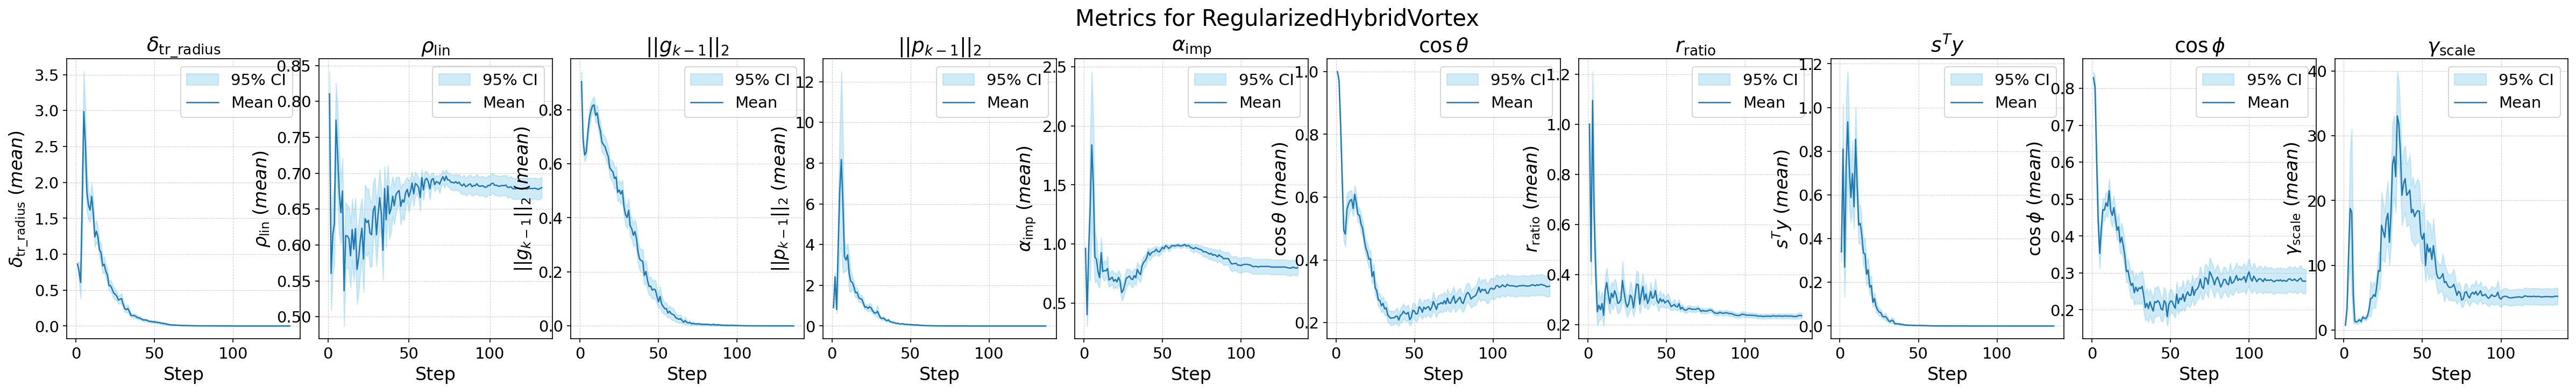


[INFO] Processing Method: ConventionalVortex


/tmp/ipykernel_1422/3383013697.py:128: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



  [DONE] Combined plot saved: results/10metrics_combined_matplotlib/combined_ConventionalVortex.png


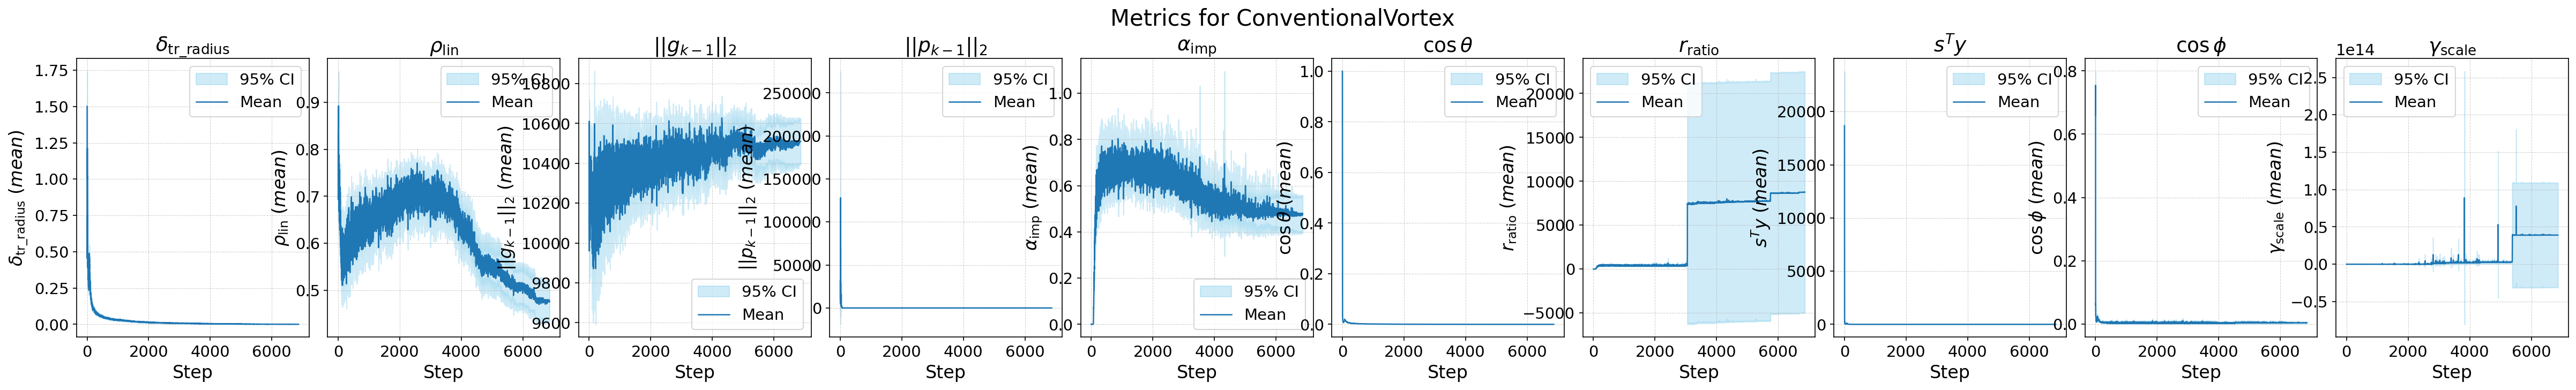

[DONE] Montage saved: /mnt/c/c++s/papertest/results/figs/Figure2.png


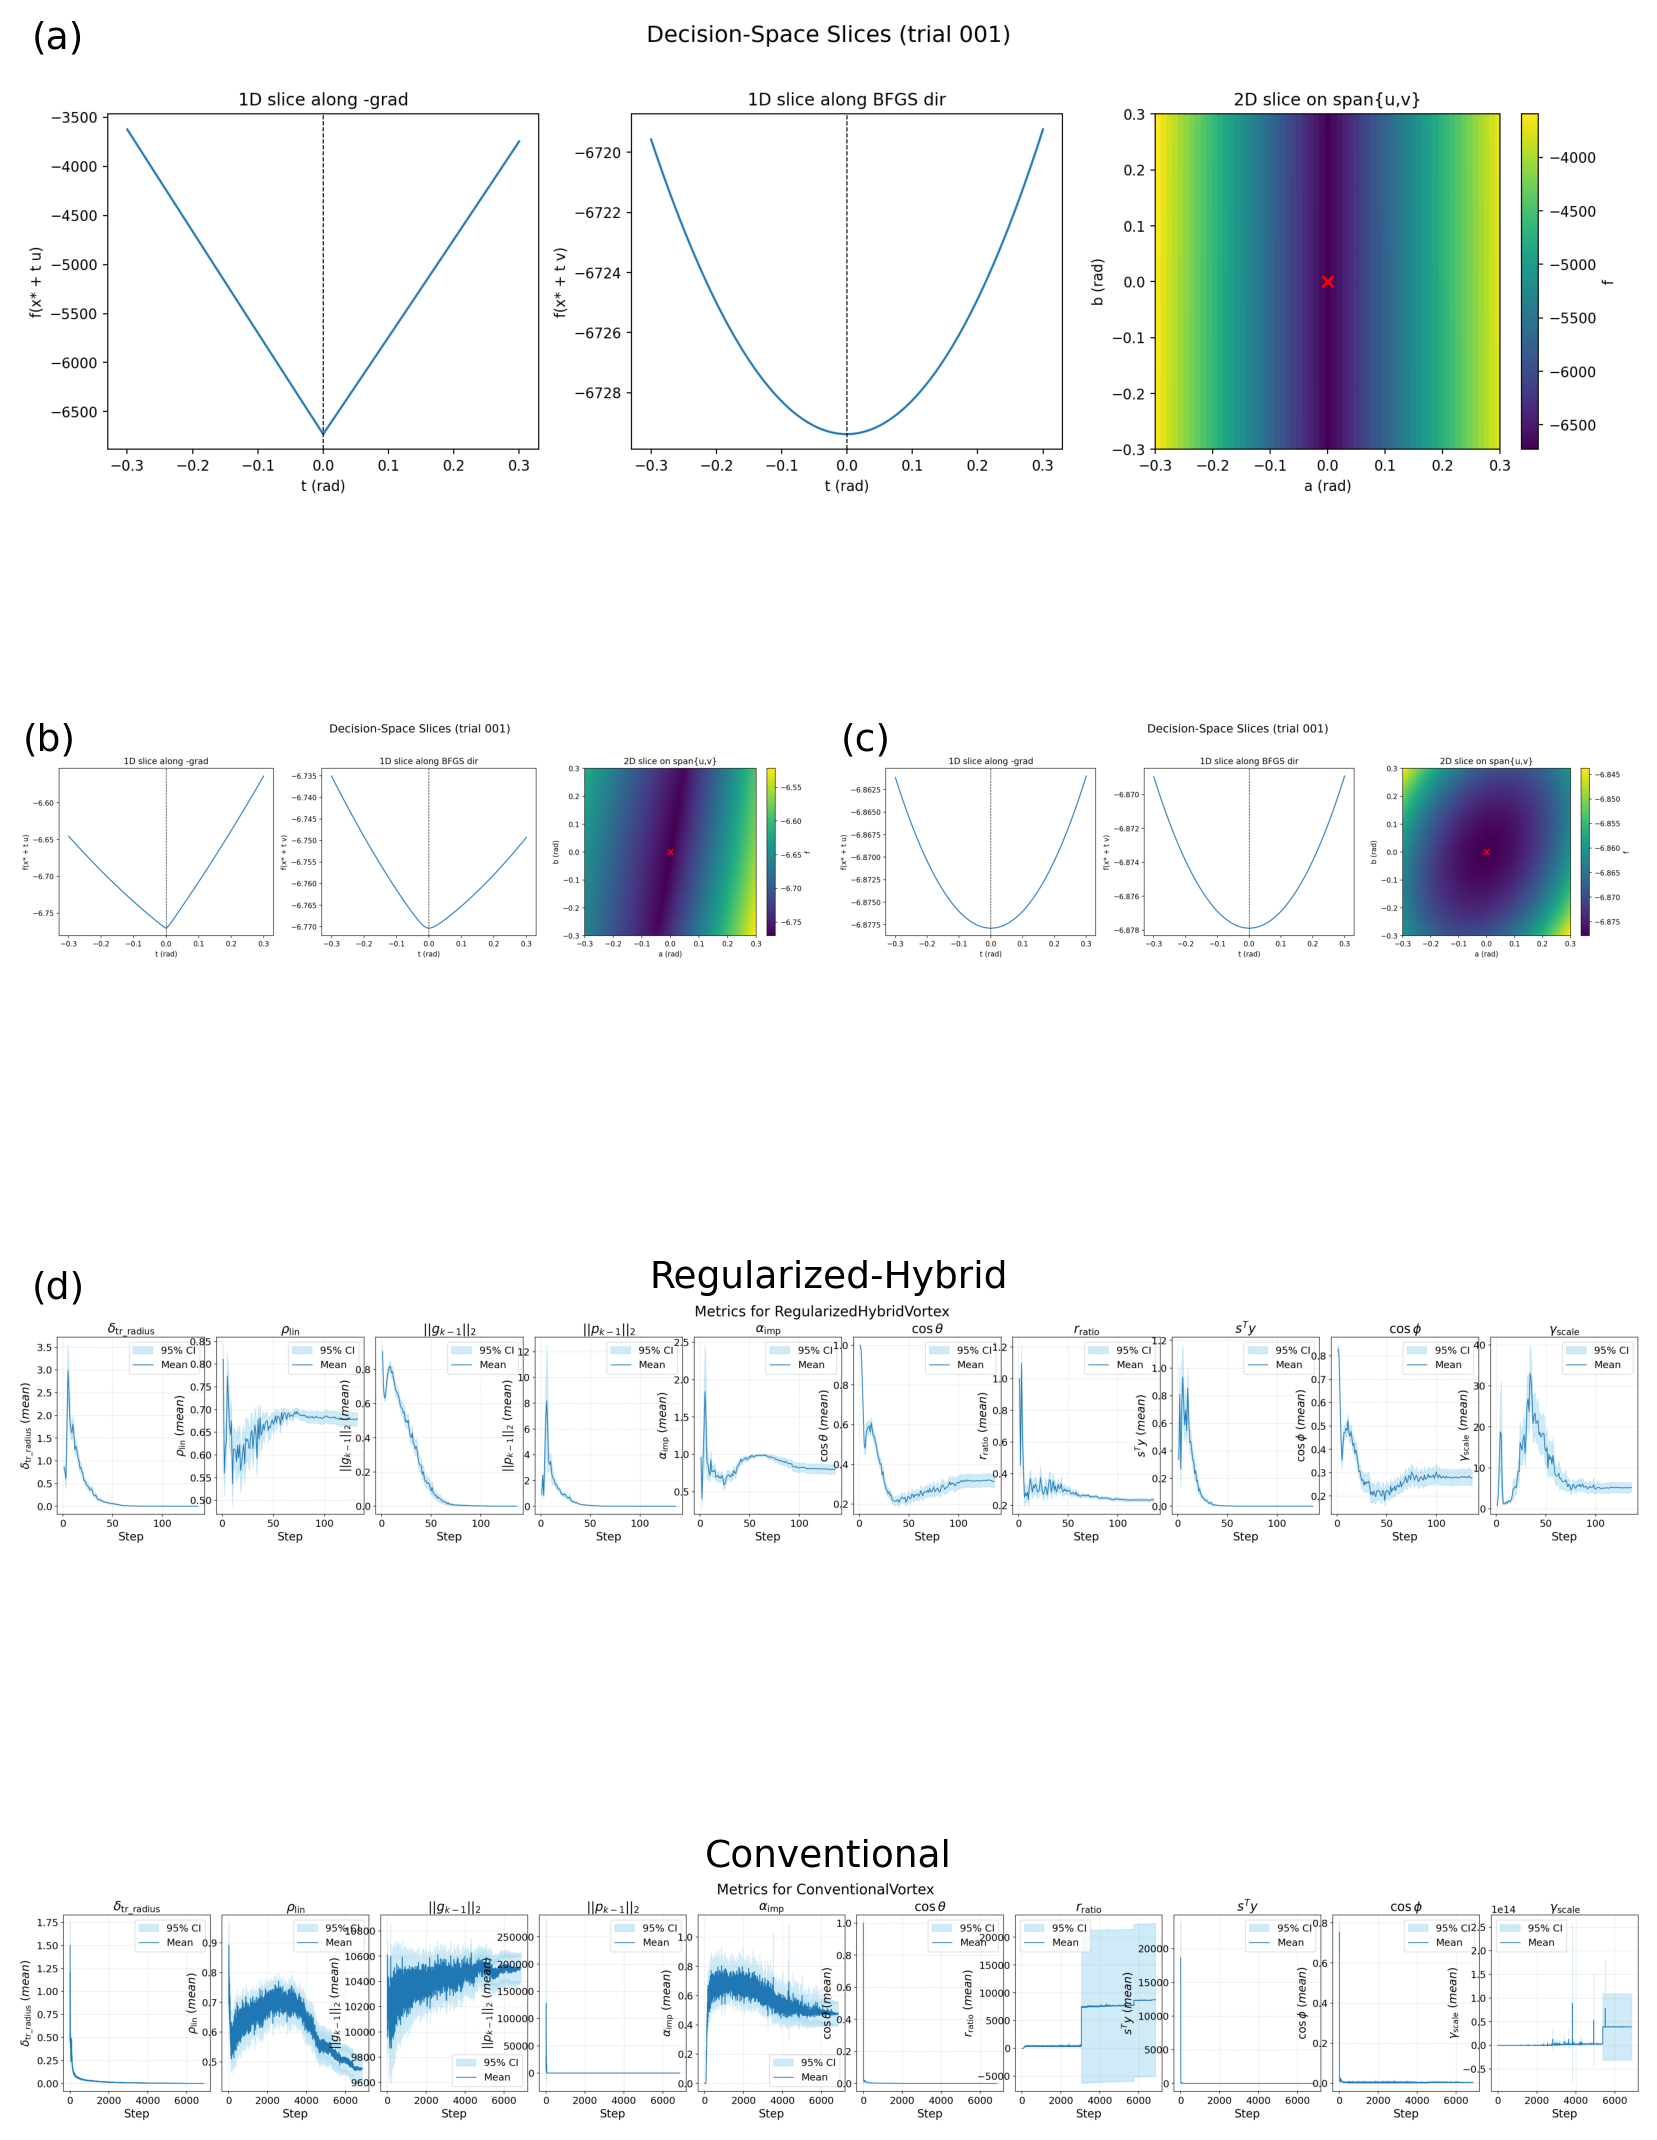

In [5]:
# fig2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage

BASE_DIR = 'results'
INPUT_DIR = os.path.join(BASE_DIR, 'inputs')
OUTPUT_ROOT = os.path.join(BASE_DIR, '10metrics_combined_matplotlib')
os.makedirs(OUTPUT_ROOT, exist_ok=True)

IMAGE1_PATH = 'figure2 (a).png'
IMAGE2_PATH = 'figure2 (b).png'
IMAGE3_PATH = 'figure2 (c).png'

file_names = {
    'RegularizedHybridVortex': "regularized_hybrid_vortex_result.csv",
    'ConventionalVortex': "conventional_vortex_result.csv",
}
file_info = {label: os.path.join(INPUT_DIR, fname) for label, fname in file_names.items()}

METRICS = [
    "delta_tr_radius", "rho_lin", "gnorm", "pnorm", "alpha_imp",
    "cos_theta", "r_ratio", "sTy", "cos_phi", "gamma_scale",
]

LATEX_LABELS = {
    "delta_tr_radius": r'$\delta_{\mathrm{tr\_radius}}$',
    "rho_lin": r'$\rho_{\mathrm{lin}}$',
    "gnorm": r'$||g_{k-1}||_2$',
    "pnorm": r'$||p_{k-1}||_2$',
    "alpha_imp": r'$\alpha_{\mathrm{imp}}$',
    "cos_theta": r'$\cos \theta$',
    "r_ratio": r'$r_{\mathrm{ratio}}$',
    "sTy": r'$s^T y$',
    "cos_phi": r'$\cos \phi$',
    "gamma_scale": r'$\gamma_{\mathrm{scale}}$'
}

DPI = 150

def require_columns(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Required columns are missing in the CSV: {missing}")

def process_and_plot_combined(method_name: str, csv_path: str):
    print(f"\n[INFO] Processing Method: {method_name}")
    if not os.path.exists(csv_path):
        print(f"  [WARN] CSV file not found: {csv_path}")
        return

    df = pd.read_csv(csv_path)
    require_columns(df, ["trial", "step"])
    available_metrics = [m for m in METRICS if m in df.columns]
    if len(available_metrics) == 0:
        print("  [WARN] No metrics available to plot.")
        return

    n_metrics = len(available_metrics)
    fig, axes = plt.subplots(
        nrows=1, ncols=n_metrics,
        figsize=(4 * n_metrics, 4.5), dpi=DPI,
        gridspec_kw={'wspace': 0.08}
    )
    fig.suptitle(f'Metrics for {method_name}', fontsize=20, y=1.02)

    if n_metrics == 1:
        axes = [axes]

    for ax, metric in zip(axes, available_metrics):
        trials = sorted(df["trial"].dropna().unique().tolist())
        if not trials:
            continue

        trial_curves, all_steps = [], set()
        for t in trials:
            dft = df[df["trial"] == t].copy().sort_values("step")
            if dft.empty:
                continue
            steps = dft["step"].to_numpy(dtype=float)
            ys = dft[metric].to_numpy(dtype=float)
            valid_mask = np.isfinite(steps) & np.isfinite(ys)
            if valid_mask.any():
                trial_curves.append({'steps': steps[valid_mask], 'ys': ys[valid_mask]})
                all_steps.update(steps[valid_mask])

        if not trial_curves:
            continue

        common_steps = np.sort(list(all_steps))
        interpolated_curves = []
        for curve in trial_curves:
            if len(curve['steps']) >= 2:
                interp_y = np.interp(common_steps, curve['steps'], curve['ys'])
                interpolated_curves.append(interp_y)

        if not interpolated_curves:
            continue

        M = np.vstack(interpolated_curves)
        mean_curve = np.nanmean(M, axis=0)
        valid_mean_mask = np.isfinite(mean_curve)

        n_valid_trials = np.sum(~np.isnan(M), axis=0)
        std_dev = np.nanstd(M, axis=0)
        std_error = np.full_like(std_dev, np.nan)
        valid_se_mask = n_valid_trials >= 2
        std_error[valid_se_mask] = std_dev[valid_se_mask] / np.sqrt(n_valid_trials[valid_se_mask])
        ci_margin = 1.96 * std_error
        ci_lower = mean_curve - ci_margin
        ci_upper = mean_curve + ci_margin

        if valid_mean_mask.any():
            x_vals = common_steps[valid_mean_mask]
            y_vals = mean_curve[valid_mean_mask]
            ax.fill_between(x_vals, ci_lower[valid_mean_mask], ci_upper[valid_mean_mask], color='skyblue', alpha=0.4, label='95% CI')
            ax.plot(x_vals, y_vals, linewidth=1.2, label='Mean')

            latex_label = LATEX_LABELS.get(metric, metric)
            ax.set_title(latex_label, fontsize=18)
            ax.set_xlabel("Step")
            ax.set_ylabel(latex_label + r' $(\mathit{mean})$')
            ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    save_path = os.path.join(OUTPUT_ROOT, f"combined_{method_name}.png")
    fig.savefig(save_path, bbox_inches="tight")
    print(f"  [DONE] Combined plot saved: {save_path}")
    plt.close(fig)
    display(IPImage(filename=save_path))

def main():
    print(f"[OUT] Output path: {os.path.abspath(OUTPUT_ROOT)}")
    made = {}
    for method_name, csv_path in file_info.items():
        try:
            process_and_plot_combined(method_name, csv_path)
            out_path = os.path.join(OUTPUT_ROOT, f"combined_{method_name}.png")
            if os.path.exists(out_path):
                made[method_name] = out_path
        except Exception as e:
            print(f"[ERROR] '{method_name}' Error occured: {e}")

    try:
        import matplotlib.gridspec as gridspec

        fig = plt.figure(figsize=(14, 20), dpi=DPI)
        gs = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1], hspace=0.0, wspace=0.01)

        def _imshow_ax(ax, img_path, title=None, panel_label=None, label_y=0.99): 
            if os.path.exists(img_path):
                img = plt.imread(img_path)
                ax.imshow(img)
            else:
                ax.text(0.5, 0.5, f"Missing:\n{os.path.basename(img_path)}", ha='center', va='center', fontsize=16)
            ax.axis('off')
            if title:
                ax.set_title(title, pad=6, fontsize=18)
            if panel_label:
                ax.text(0.01, label_y, panel_label, transform=ax.transAxes, ha='left', va='top', fontsize=18)

        ax_a = fig.add_subplot(gs[0, :])
        _imshow_ax(ax_a, IMAGE1_PATH, panel_label="(a)")

        ax_b = fig.add_subplot(gs[1, 0])
        _imshow_ax(ax_b, IMAGE2_PATH, panel_label="(b)")

        ax_c = fig.add_subplot(gs[1, 1])
        _imshow_ax(ax_c, IMAGE3_PATH, panel_label="(c)")

        rh_path = made.get('RegularizedHybridVortex', os.path.join(OUTPUT_ROOT, 'combined_RegularizedHybridVortex.png'))
        ax_d = fig.add_subplot(gs[2, :])
        _imshow_ax(ax_d, rh_path, title='Regularized-Hybrid', panel_label="(d)", label_y=1.12)

        cv_path = made.get('ConventionalVortex', os.path.join(OUTPUT_ROOT, 'combined_ConventionalVortex.png'))
        ax_e = fig.add_subplot(gs[3, :])
        _imshow_ax(ax_e, cv_path, title='Conventional', panel_label=None)

        montage_path = os.path.join(figs_dir, "Figure2.png")
        fig.savefig(montage_path, bbox_inches="tight")
        plt.close(fig)
        print(f"[DONE] Montage saved: {montage_path}")
        display(IPImage(filename=montage_path))
    except Exception as e:
        print(f"[WARN] Montage step skipped due to error: {e}")

if __name__ == "__main__":
    main()


Using device: cuda

Loading and parsing CSV files...
  - Loading /mnt/c/c++s/papertest/results/outputs/final_force_equilibrium_result.csv
  - Loading /mnt/c/c++s/papertest/results/outputs/final_hybrid_vortex_result.csv
  - Loading /mnt/c/c++s/papertest/results/outputs/final_regularized_hybrid_vortex_result.csv
  - Loading /mnt/c/c++s/papertest/results/outputs/final_conventional_vortex_result.csv
  - Loading /mnt/c/c++s/papertest/results/outputs/final_regularized_conventional_vortex_result.csv

Total vectors loaded for analysis: 500

Calculating ECI and NTS for all phase vectors...


Processing ECI/NTS: 100%|█████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 74.02it/s]



--- Combined analysis plot saved to: /mnt/c/c++s/papertest/results/figs/Figure3.png


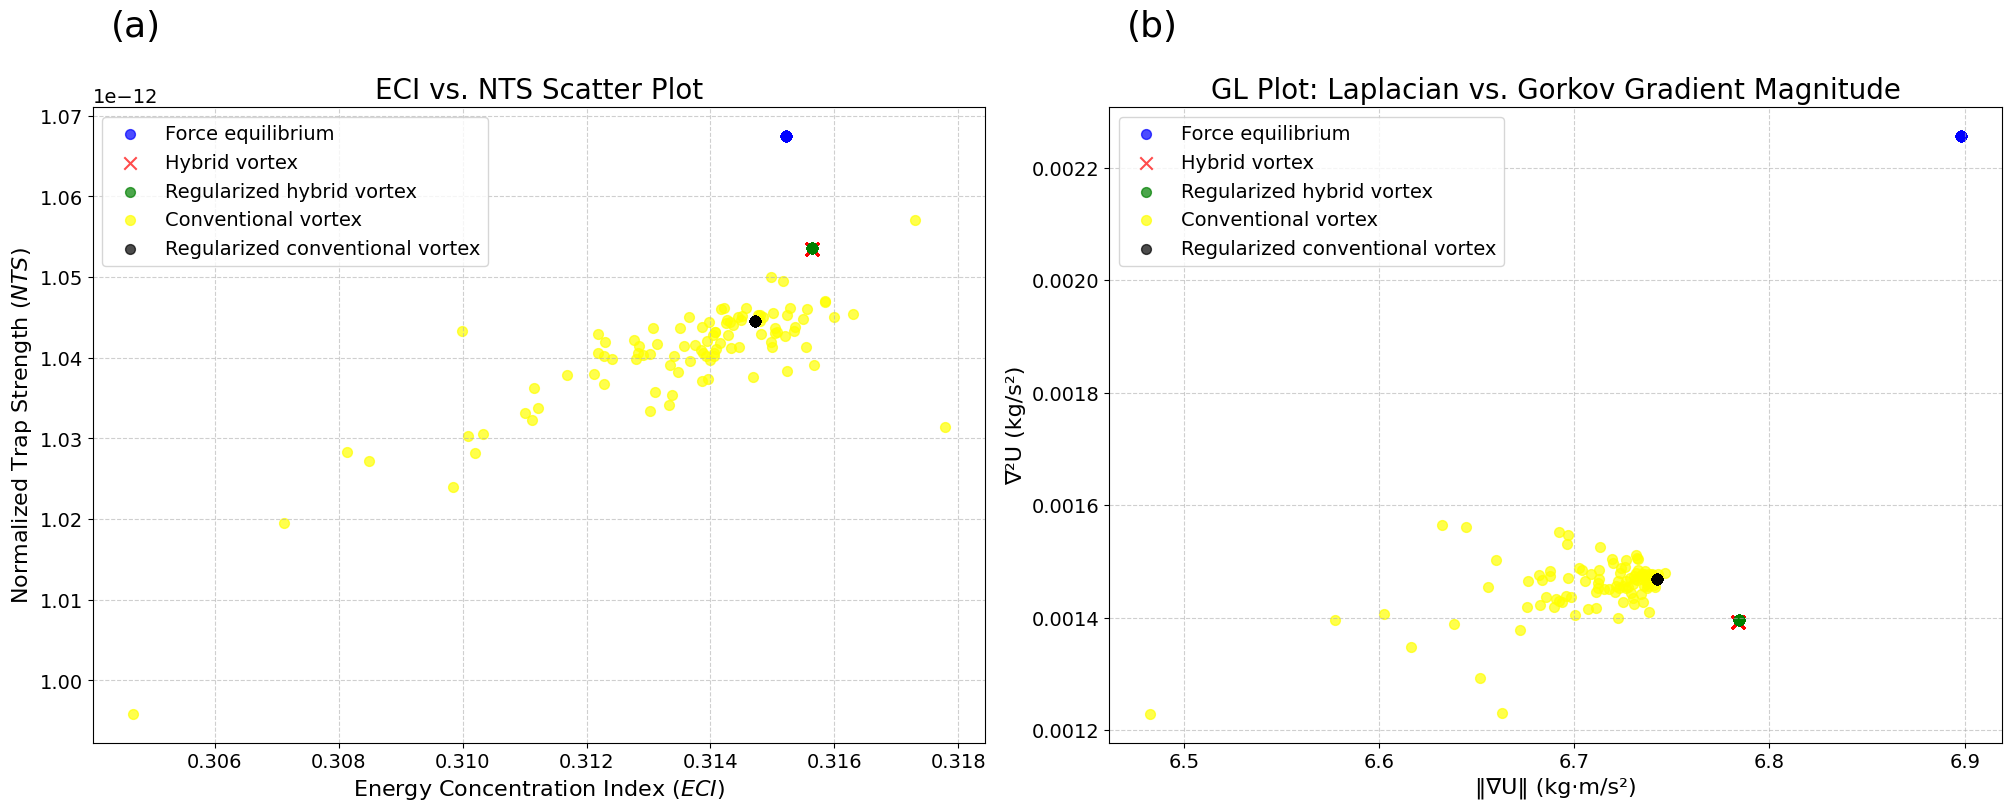

In [6]:
# fig3
def prettify_label(s: str) -> str:
    if not s:
        return s
    words = []
    start = 0
    n = len(s)
    for i in range(1, n):
        prev = s[i-1]
        curr = s[i]
        next_is_lower = (i+1 < n and s[i+1].islower())
        if (prev.islower() and curr.isupper()) or (prev.isupper() and curr.isupper() and next_is_lower):
            words.append(s[start:i])
            start = i
    words.append(s[start:])

    if not words:
        return s
    words = [words[0].capitalize()] + [w.lower() for w in words[1:]]
    return " ".join(words)


def plot_combined_analysis(eci_data, nts_data, eci_nts_labels,
                           gl_laps, gl_gmgs, gl_labels,
                           label_names, color_map, outfile):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)

    for i, label_name in enumerate(label_names):
        mask = (eci_nts_labels == i)
        if not np.any(mask): continue
        current_color = color_map.get(label_name, 'gray')
        marker_style = 'x' if label_name == 'HybridVortex' else 'o'
        marker_size  = 80 if label_name == 'HybridVortex' else 50
        display_label = prettify_label(label_name)
        ax1.scatter(eci_data[mask], nts_data[mask],
                    label=display_label, alpha=0.7,
                    s=marker_size, color=current_color, marker=marker_style)

    ax1.set_title('ECI vs. NTS Scatter Plot', fontsize=20)
    ax1.set_xlabel(r'Energy Concentration Index ($\mathit{ECI}$)', fontsize=16)
    ax1.set_ylabel(r'Normalized Trap Strength ($\mathit{NTS}$)', fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()
    ax1.text(0.02, 1.10, "(a)", transform=ax1.transAxes,
             ha="left", va="bottom", fontsize=26, clip_on=False)

    for i, label_name in enumerate(label_names):
        mask = (gl_labels == i)
        if not np.any(mask): continue
        current_color = color_map.get(label_name, 'gray')
        marker_style = 'x' if label_name == 'HybridVortex' else 'o'
        marker_size  = 80 if label_name == 'HybridVortex' else 50
        display_label = prettify_label(label_name)
        ax2.scatter(gl_laps[mask], gl_gmgs[mask],
                    label=display_label, alpha=0.7,
                    s=marker_size, color=current_color, marker=marker_style)

    ax2.set_title("GL Plot: Laplacian vs. Gorkov Gradient Magnitude", fontsize=20)
    ax2.set_xlabel("‖∇U‖ (kg·m/s²)", fontsize=16)
    ax2.set_ylabel("∇²U (kg/s²)", fontsize=16)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend()
    ax2.text(0.02, 1.10, "(b)", transform=ax2.transAxes,
             ha="left", va="bottom", fontsize=26, clip_on=False)

    output_dir = os.path.dirname(outfile)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    plt.savefig(outfile, dpi=300, bbox_inches='tight', pad_inches=0.2)
    print(f"\n--- Combined analysis plot saved to: {outfile}")
    plt.show()



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

BASE_DIR = os.getcwd()
INPUT_DIR = os.path.join(BASE_DIR, 'results', 'outputs')
OUTPUT_DIR = os.path.join(BASE_DIR, 'results', 'figs')
os.makedirs(OUTPUT_DIR, exist_ok=True)

file_names = {
    'ForceEquilibrium': "final_force_equilibrium_result.csv",
    'HybridVortex': "final_hybrid_vortex_result.csv",
    'RegularizedHybridVortex': "final_regularized_hybrid_vortex_result.csv",
    'ConventionalVortex': "final_conventional_vortex_result.csv",
    'RegularizedConventionalVortex': "final_regularized_conventional_vortex_result.csv",
}
file_info = {label: os.path.join(INPUT_DIR, fname) for label, fname in file_names.items()}

color_map = {
    'ForceEquilibrium': 'blue',
    'HybridVortex': 'red',
    'RegularizedHybridVortex': 'green',
    'ConventionalVortex': 'yellow',
    'RegularizedConventionalVortex': 'black',
}

all_phases_list, all_labels_list = [], []
gl_laps_list, gl_gmgs_list, gl_labels_list = [], [], []
label_names = list(file_info.keys())

print("\nLoading and parsing CSV files...")
for i, (label, path) in enumerate(file_info.items()):
    if not os.path.exists(path):
        print(f"Warning: Input file not found, skipping. Path: {path}")
        continue
    print(f"  - Loading {path}")
    df = pd.read_csv(path)

    phases = df[[f'phase_{j}' for j in range(64)]].values
    all_phases_list.append(phases)
    all_labels_list.extend([i] * len(phases))

    try:
        laps, gmgs, lbls = collect_gl_points_from_df(df, label_index=i)
        gl_laps_list.append(laps)
        gl_gmgs_list.append(gmgs)
        gl_labels_list.append(lbls)
    except (ValueError, KeyError) as e:
        print(f"  - GL Skip for '{label}': Columns not found or error ({e})")

if all_phases_list:
    all_phases_np = np.concatenate(all_phases_list, axis=0)
    all_labels_np = np.array(all_labels_list)
    print(f"\nTotal vectors loaded for analysis: {len(all_phases_np)}")

    simulation_params = setup_simulation_parameters(device)

    target_coords = (0.01, 0.01, 0.03)
    x_idx, y_idx, z_idx = (
        torch.argmin(torch.abs(simulation_params[f"{ax}_vals"] - c)).item()
        for ax, c in zip("xyz", target_coords)
    )
    target_indices = (x_idx, y_idx, z_idx)

    all_eci, all_nts = [], []
    print("\nCalculating ECI and NTS for all phase vectors...")
    with torch.no_grad():
        for phase_vector_np in tqdm(all_phases_np, desc="Processing ECI/NTS"):
            phase_tensor = torch.tensor(phase_vector_np, dtype=torch.float64, device=device)

            laplacian = calculate_laplacian_at_target(
                phase_tensor, simulation_params, target_indices
            )

            pressure_z_slice_tensor = compute_z_slice_directly_batched(
                phase_tensor, z_idx, simulation_params, device
            )
            pressure_z_slice_np = torch.abs(pressure_z_slice_tensor.T).cpu().numpy()

            eci, nts = calculate_eci_and_nts(
                pressure_z_slice_np, laplacian, simulation_params, target_coords
            )
            all_eci.append(eci)
            all_nts.append(nts)

    all_eci_np, all_nts_np = np.array(all_eci), np.array(all_nts)

    if gl_laps_list:
        gl_laps_np = np.concatenate(gl_laps_list, axis=0)
        gl_gmgs_np = np.concatenate(gl_gmgs_list, axis=0)
        gl_labels_np = np.concatenate(gl_labels_list, axis=0)

        output_filepath = os.path.join(OUTPUT_DIR, 'Figure3.png')

        plot_combined_analysis(
            eci_data=all_eci_np, nts_data=all_nts_np, eci_nts_labels=all_labels_np,
            gl_laps=gl_laps_np, gl_gmgs=gl_gmgs_np, gl_labels=gl_labels_np,
            label_names=label_names, color_map=color_map,
            outfile=output_filepath
        )
    else:
        print("\nNo GL points found. Skipping plot generation.")
else:
    print("\nNo data loaded. Skipping plot generation.")

Using device: cuda

Loading CSVs ...
  - Loading: outputs/final_force_equilibrium_result.csv
  - Loading: outputs/final_hybrid_vortex_result.csv
  - Loading: outputs/final_regularized_hybrid_vortex_result.csv
  - Loading: outputs/final_conventional_vortex_result.csv
  - Loading: outputs/final_regularized_conventional_vortex_result.csv
  - Loading: outputs/final_hybrid_twin_result.csv
  - Loading: outputs/final_regularized_hybrid_twin_result.csv
  - Loading: outputs/final_conventional_twin_result.csv
  - Loading: outputs/final_regularized_conventional_twin_result.csv

Computing ECI/NTS ...


Processing ECI/NTS: 100%|█████████████████████████████████████████████████████████████| 900/900 [00:09<00:00, 95.95it/s]



--- Combined figure saved to: /mnt/c/c++s/papertest/results/figs/Figure4.png


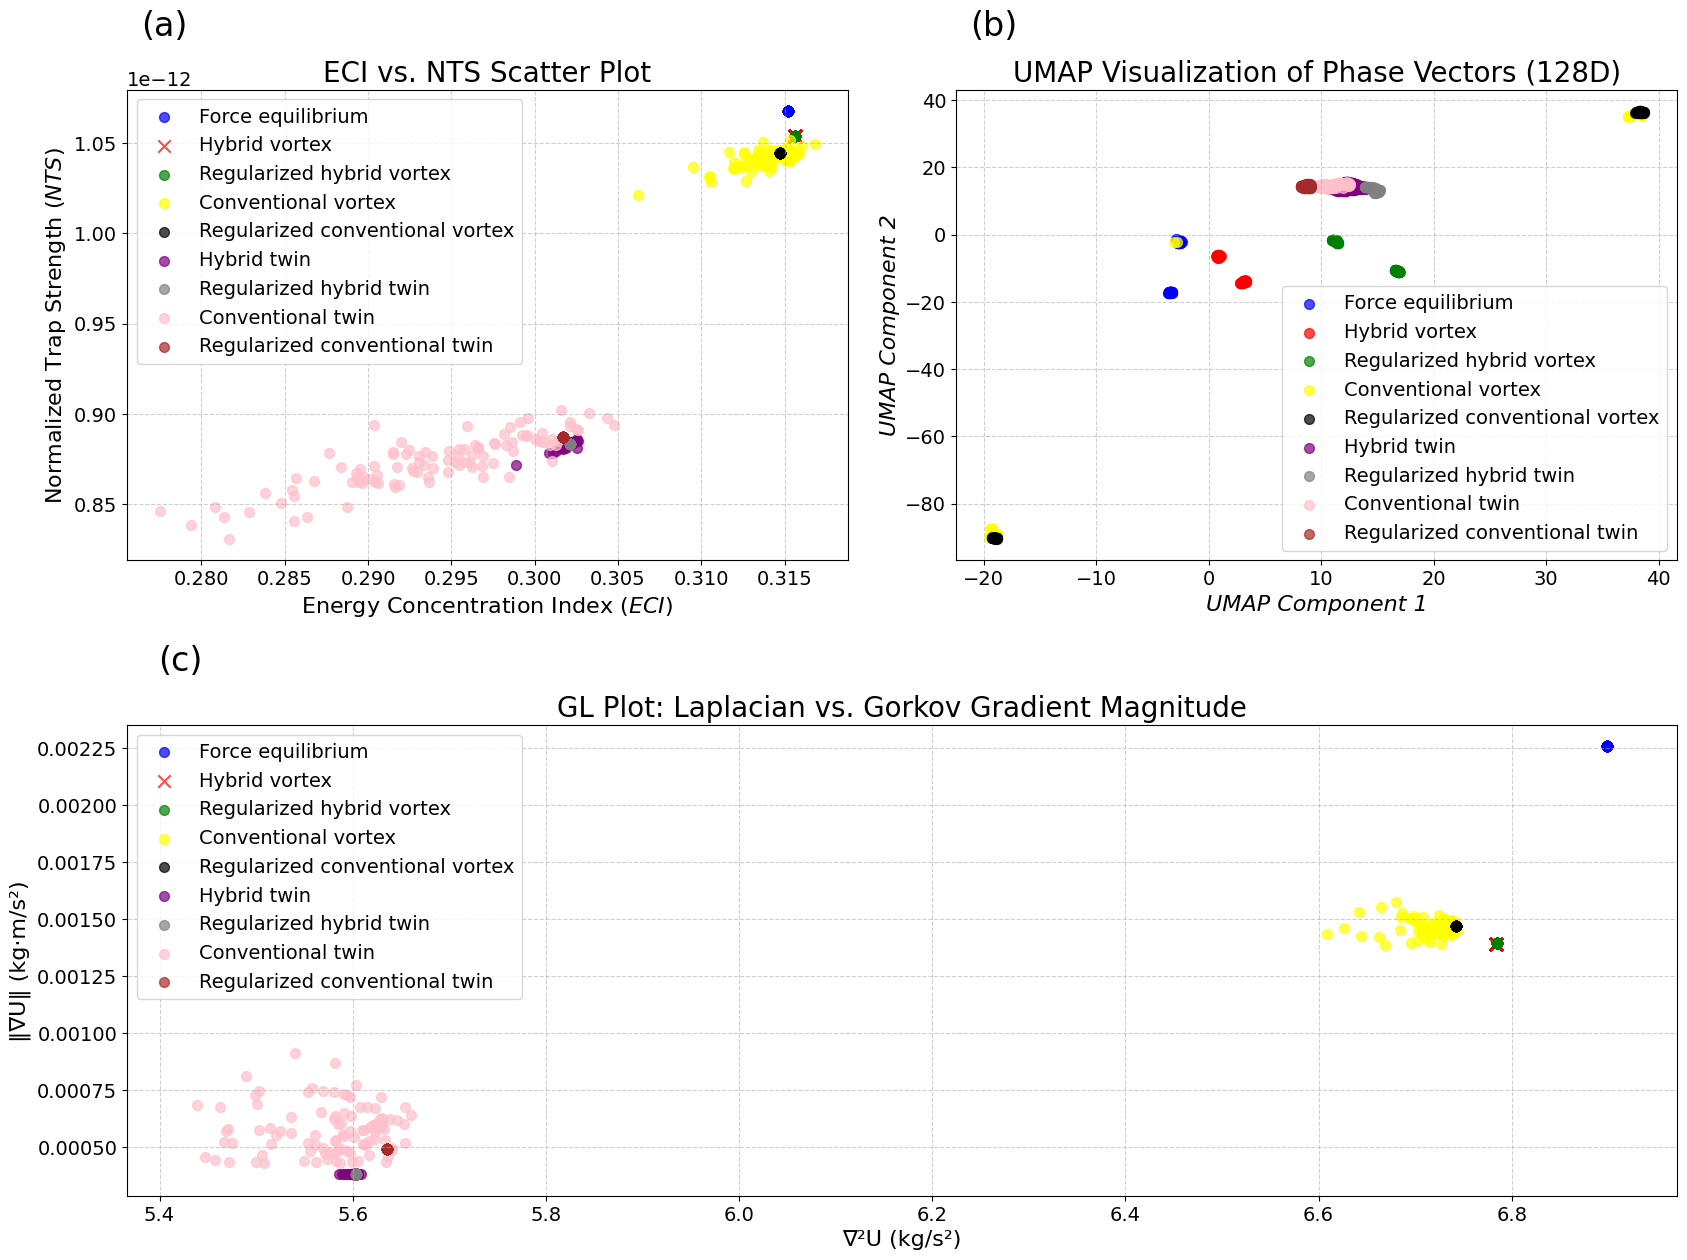

In [7]:
# fig4
def prettify_label(s: str) -> str:
    if not s:
        return s
    words = []
    start = 0
    n = len(s)
    for i in range(1, n):
        prev = s[i-1]
        curr = s[i]
        next_is_lower = (i+1 < n and s[i+1].islower())
        if (prev.islower() and curr.isupper()) or (prev.isupper() and curr.isupper() and next_is_lower):
            words.append(s[start:i])
            start = i
    words.append(s[start:])
    if not words:
        return s
    words = [words[0].capitalize()] + [w.lower() for w in words[1:]]
    return " ".join(words)

def plot_fig4_combined(eci_data, nts_data, umap_results, labels,
                       group_info, color_map,
                       gl_laps=None, gl_gmgs=None, gl_labels=None,
                       outfile="Figure4.png"):
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.15)

    ax_a = fig.add_subplot(gs[0, 0])
    ax_b = fig.add_subplot(gs[0, 1])
    ax_c = fig.add_subplot(gs[1, :])

    for i, label_name in enumerate(group_info.keys()):
        mask = (labels == i)
        if not np.any(mask): continue
        current_color = color_map.get(label_name, 'gray')
        marker_style = 'x' if label_name == 'HybridVortex' else 'o'
        marker_size  = 80 if label_name == 'HybridVortex' else 50
        display_label = prettify_label(label_name)
        ax_a.scatter(eci_data[mask], nts_data[mask],
                     label=display_label, alpha=0.7,
                     s=marker_size, color=current_color, marker=marker_style)
    ax_a.set_title('ECI vs. NTS Scatter Plot', fontsize=20)
    ax_a.set_xlabel(r'Energy Concentration Index ($\mathit{ECI}$)', fontsize=16)
    ax_a.set_ylabel(r'Normalized Trap Strength ($\mathit{NTS}$)', fontsize=16)
    ax_a.grid(True, linestyle='--', alpha=0.6)
    ax_a.legend()
    ax_a.text(0.02, 1.10, "(a)", transform=ax_a.transAxes,
              ha="left", va="bottom", fontsize=24, clip_on=False)

    for i, label_name in enumerate(group_info.keys()):
        mask = (labels == i)
        if not np.any(mask): continue
        current_color = color_map.get(label_name, 'gray')
        display_label = prettify_label(label_name)
        ax_b.scatter(umap_results[mask, 0], umap_results[mask, 1],
                     label=display_label, alpha=0.7, s=50, color=current_color)
    ax_b.set_title('UMAP Visualization of Phase Vectors (128D)', fontsize=20)
    ax_b.set_xlabel('UMAP Component 1', fontsize=16, fontstyle='italic')
    ax_b.set_ylabel('UMAP Component 2', fontsize=16, fontstyle='italic')
    ax_b.grid(True, linestyle='--', alpha=0.6)
    ax_b.legend()
    ax_b.text(0.02, 1.10, "(b)", transform=ax_b.transAxes,
              ha="left", va="bottom", fontsize=24, clip_on=False)

    if (gl_laps is not None) and (gl_gmgs is not None) and (gl_labels is not None):
        for i, label_name in enumerate(group_info.keys()):
            gmask = (gl_labels == i)
            if not np.any(gmask): continue
            current_color = color_map.get(label_name, 'gray')
            marker_style = 'x' if label_name == 'HybridVortex' else 'o'
            marker_size  = 80 if label_name == 'HybridVortex' else 50
            display_label = prettify_label(label_name)
            ax_c.scatter(gl_laps[gmask], gl_gmgs[gmask],
                         label=display_label, alpha=0.7,
                         s=marker_size, color=current_color, marker=marker_style)
    ax_c.set_title("GL Plot: Laplacian vs. Gorkov Gradient Magnitude", fontsize=20)
    ax_c.set_xlabel("∇²U (kg/s²)", fontsize=16)
    ax_c.set_ylabel("‖∇U‖ (kg·m/s²)", fontsize=16)
    ax_c.grid(True, linestyle='--', alpha=0.6)
    ax_c.legend()
    ax_c.text(0.02, 1.10, "(c)", transform=ax_c.transAxes,
              ha="left", va="bottom", fontsize=24, clip_on=False)

    plt.subplots_adjust(top=0.90)
    outdir = os.path.dirname(outfile)
    if outdir: os.makedirs(outdir, exist_ok=True)
    plt.savefig(outfile, dpi=300)
    print(f"\n--- Combined figure saved to: {outfile}")
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

BASE_DIR = os.getcwd()
FIGS_DIR = os.path.join(BASE_DIR, "results", "figs")
os.makedirs(FIGS_DIR, exist_ok=True)

file_info = {
    'ForceEquilibrium': "outputs/final_force_equilibrium_result.csv",
    'HybridVortex': "outputs/final_hybrid_vortex_result.csv",
    'RegularizedHybridVortex': "outputs/final_regularized_hybrid_vortex_result.csv",
    'ConventionalVortex': "outputs/final_conventional_vortex_result.csv",
    'RegularizedConventionalVortex': "outputs/final_regularized_conventional_vortex_result.csv",
    'HybridTwin': "outputs/final_hybrid_twin_result.csv",
    'RegularizedHybridTwin': "outputs/final_regularized_hybrid_twin_result.csv",
    'ConventionalTwin': "outputs/final_conventional_twin_result.csv",
    'RegularizedConventionalTwin': "outputs/final_regularized_conventional_twin_result.csv",
}
color_map = {
    'ForceEquilibrium': 'blue',
    'HybridVortex': 'red',
    'RegularizedHybridVortex': 'green',
    'ConventionalVortex': 'yellow',
    'RegularizedConventionalVortex': 'black',
    'HybridTwin': 'purple',
    'RegularizedHybridTwin': 'gray',
    'ConventionalTwin': 'pink',
    'RegularizedConventionalTwin': 'brown',
}

all_phases_list, all_labels_list = [], []
gl_laps_list, gl_gmgs_list, gl_labels_list = [], [], []

print("\nLoading CSVs ...")
for i, (label_name, path) in enumerate(file_info.items()):
    if not os.path.exists(path):
        print(f"  - Skip (not found): {path}")
        continue
    print(f"  - Loading: {path}")
    df = pd.read_csv(path)

    phases = df[[f'phase_{j}' for j in range(64)]].values
    all_phases_list.append(phases)
    all_labels_list.extend([i] * len(phases))

    try:
        laps, gmgs, lbls = collect_gl_points_from_df(df, label_index=i)
        gl_laps_list.append(laps)
        gl_gmgs_list.append(gmgs)
        gl_labels_list.append(lbls)
    except (ValueError, KeyError):
        pass

if all_phases_list:
    all_phases_np = np.concatenate(all_phases_list, axis=0)
    all_labels_np = np.array(all_labels_list)

    sim_params = setup_simulation_parameters(device)
    target_coords = (0.01, 0.01, 0.03)
    x_idx, y_idx, z_idx = (
        torch.argmin(torch.abs(sim_params[f"{ax}_vals"] - c)).item()
        for ax, c in zip("xyz", target_coords)
    )
    target_indices = (x_idx, y_idx, z_idx)

    all_eci, all_nts = [], []
    print("\nComputing ECI/NTS ...")
    with torch.no_grad():
        for phase_vector_np in tqdm(all_phases_np, desc="Processing ECI/NTS"):
            phase_tensor = torch.tensor(phase_vector_np, dtype=torch.float64, device=device)
            laplacian = calculate_laplacian_at_target(phase_tensor, sim_params, target_indices)
            pressure_slice = compute_z_slice_directly_batched(phase_tensor, z_idx, sim_params, device)
            pressure_slice_np = torch.abs(pressure_slice.T).detach().cpu().numpy()
            eci, nts = calculate_eci_and_nts(pressure_slice_np, laplacian, sim_params, target_coords)
            all_eci.append(eci); all_nts.append(nts)
    all_eci_np = np.array(all_eci)
    all_nts_np = np.array(all_nts)

    trapping_point_xy = torch.tensor([0.01, 0.01], dtype=torch.float64, device=device)
    distances = torch.norm(sim_params["transducer_positions"][:, :2] - trapping_point_xy, dim=1)
    norm_idx = torch.argmin(distances).item()

    normalized_phases = all_phases_np - all_phases_np[:, norm_idx:norm_idx+1]
    transformed_phases = np.empty((normalized_phases.shape[0], 128), dtype=np.float64)
    transformed_phases[:, 0::2] = np.cos(normalized_phases)
    transformed_phases[:, 1::2] = np.sin(normalized_phases)

    reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, random_state=42)
    umap_results = reducer.fit_transform(transformed_phases)

    if gl_laps_list:
        gl_laps_np = np.concatenate(gl_laps_list, axis=0)
        gl_gmgs_np = np.concatenate(gl_gmgs_list, axis=0)
        gl_labels_np = np.concatenate(gl_labels_list, axis=0)
    else:
        gl_laps_np = gl_gmgs_np = gl_labels_np = None

    out_path = os.path.join(FIGS_DIR, "Figure4.png")
    plot_fig4_combined(
        eci_data=all_eci_np, nts_data=all_nts_np,
        umap_results=umap_results, labels=all_labels_np,
        group_info=file_info, color_map=color_map,
        gl_laps=gl_laps_np, gl_gmgs=gl_gmgs_np, gl_labels=gl_labels_np,
        outfile=out_path
    )
else:
    print("\nNo data loaded. Skipping figure generation.")


Processing ECI/NTS: 100%|█████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 82.25it/s]



--- Figure 5 combined saved to: results/figs/Figure5.png


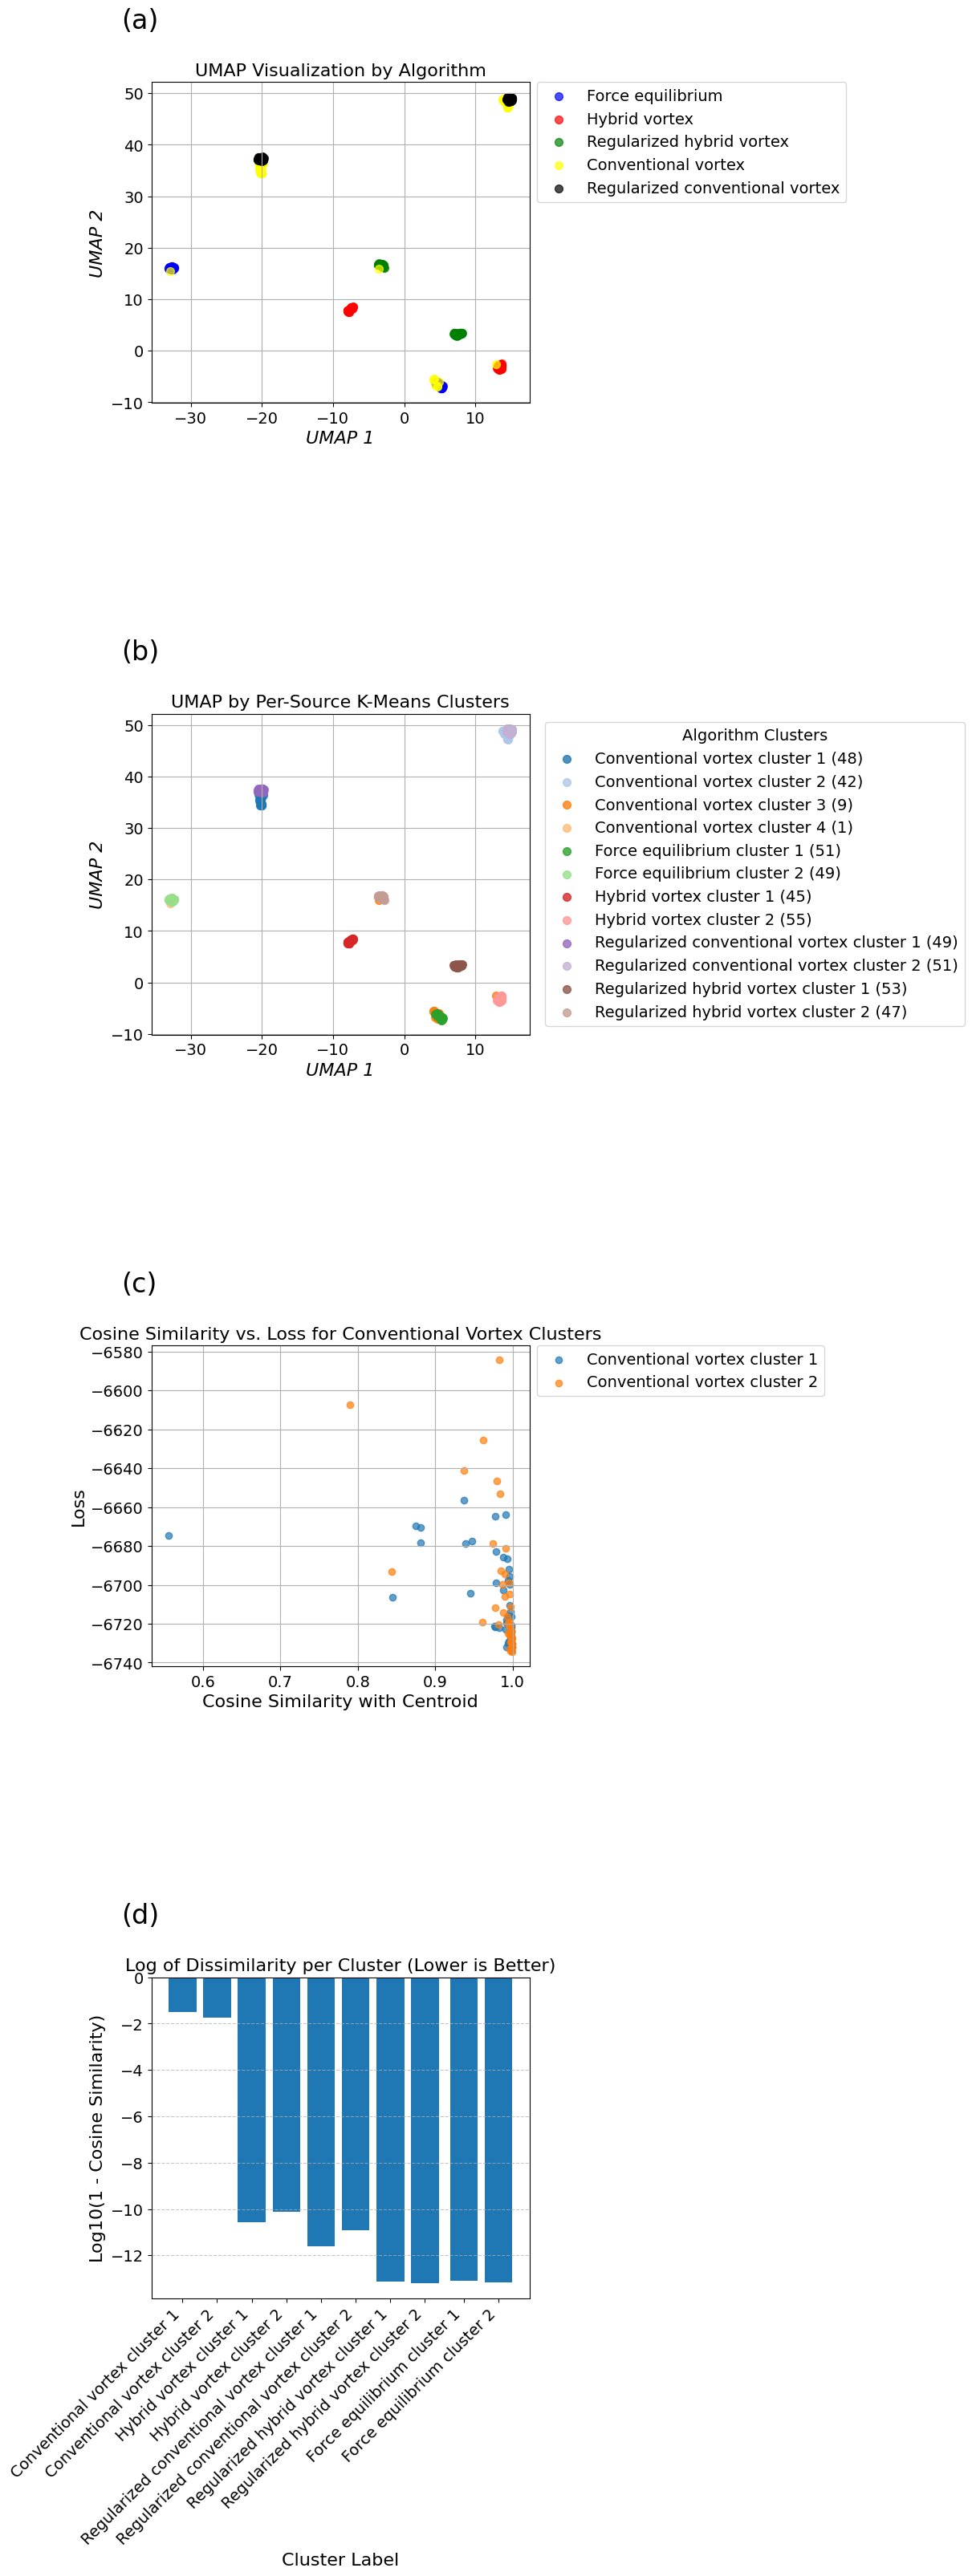

In [8]:
# fig5
from tqdm import tqdm
import umap
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

def _prettify_label_no_re(s: str) -> str:
    if not s:
        return s
    tokens = str(s).split('_')
    pieces = []
    for tok in tokens:
        if not tok:
            continue
        start = 0
        n = len(tok)
        parts = []
        for i in range(1, n):
            prev, curr = tok[i-1], tok[i]
            next_is_lower = (i+1 < n and tok[i+1].islower())
            if (prev.islower() and curr.isupper()) or (prev.isupper() and curr.isupper() and next_is_lower):
                parts.append(tok[start:i])
                start = i
        parts.append(tok[start:])
        pieces.extend(parts)
    if not pieces:
        return s
    out = [pieces[0].capitalize()] + [p.lower() for p in pieces[1:]]
    return " ".join(out)

def plot_fig5_all_in_one(umap_results,
                         algo_labels,
                         group_info,
                         color_map,
                         per_source_cluster_labels,
                         raw_df,
                         transformed_df,
                         outfile):
    fig = plt.figure(figsize=(12, 32), constrained_layout=True)
    
    gs = fig.add_gridspec(4, 1, hspace=0.3, wspace=0.0)

    ax_a = fig.add_subplot(gs[0, 0])
    for i, label_name in enumerate(group_info.keys()):
        mask = (algo_labels == i)
        if not np.any(mask):
            continue
        color = color_map.get(label_name, 'gray')
        ax_a.scatter(umap_results[mask, 0], umap_results[mask, 1],
                     label=_prettify_label_no_re(label_name), alpha=0.7, s=50, color=color, marker='o')
    ax_a.set_title('UMAP Visualization by Algorithm', fontsize=16)
    ax_a.set_xlabel('UMAP 1', fontsize=16, fontstyle='italic')
    ax_a.set_ylabel('UMAP 2', fontsize=16, fontstyle='italic')
    ax_a.grid(True)
    ax_a.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax_a.text(-0.08, 1.15, "(a)", transform=ax_a.transAxes,
              ha="left", va="bottom", fontsize=24, clip_on=False)

    ax_b = fig.add_subplot(gs[1, 0])
    unique_labels = sorted(list(set(per_source_cluster_labels)))
    cmap = plt.get_cmap('tab20' if len(unique_labels) <= 20 else 'hsv')
    color_mapping = {lab: cmap(i % cmap.N) for i, lab in enumerate(unique_labels)}
    for lab in unique_labels:
        mask = (per_source_cluster_labels == lab)
        if np.any(mask):
            ax_b.scatter(umap_results[mask, 0], umap_results[mask, 1],
                         color=color_mapping[lab],
                         label=f"{_prettify_label_no_re(lab)} ({int(np.sum(mask))})",
                         alpha=0.8, s=50)
    ax_b.set_title('UMAP by Per-Source K-Means Clusters', fontsize=16)
    ax_b.set_xlabel('UMAP 1', fontsize=16, fontstyle='italic')
    ax_b.set_ylabel('UMAP 2', fontsize=16, fontstyle='italic')
    ax_b.grid(True)
    ax_b.legend(title="Algorithm Clusters", bbox_to_anchor=(1.02, 1), loc='upper left')
    ax_b.text(-0.08, 1.15, "(b)", transform=ax_b.transAxes,
              ha="left", va="bottom", fontsize=24, clip_on=False)

    ax_c = fig.add_subplot(gs[2, 0])
    vec_cols = [c for c in transformed_df.columns if c.startswith('d_')]
    cv1 = 'ConventionalVortex_Cluster_1'
    cv2 = 'ConventionalVortex_Cluster_2'
    plotted_any = False
    for tag, lab in [('Cluster 1', cv1), ('Cluster 2', cv2)]:
        dfv = transformed_df[transformed_df['cluster_label'] == lab]
        if len(dfv) > 0:
            centroid = dfv[vec_cols].mean().to_numpy().reshape(1, -1)
            sims = cosine_similarity(dfv[vec_cols].to_numpy(), centroid).flatten()
            losses = raw_df[raw_df['cluster_label'] == lab]['loss'].to_numpy()
            ax_c.scatter(sims, losses, label=_prettify_label_no_re(f'ConventionalVortex_{tag}'), alpha=0.7)
            plotted_any = True
    ax_c.set_title('Cosine Similarity vs. Loss for Conventional Vortex Clusters', fontsize=16)
    ax_c.set_xlabel('Cosine Similarity with Centroid')
    ax_c.set_ylabel('Loss')
    ax_c.grid(True)
    if plotted_any:
        ax_c.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax_c.text(-0.08, 1.15, "(c)", transform=ax_c.transAxes,
              ha="left", va="bottom", fontsize=24, clip_on=False)

    ax_d = fig.add_subplot(gs[3, 0])
    results = []
    for lab, group in transformed_df.groupby('cluster_label'):
        vecs = group[vec_cols].to_numpy()
        if len(vecs) > 1:
            mean_vec = np.mean(vecs, axis=0).reshape(1, -1)
            sims = cosine_similarity(vecs, mean_vec)
            results.append({
                'cluster_label': lab,
                'vector_count': len(vecs),
                'avg_cosine_similarity_to_mean': float(np.mean(sims))
            })

    if results:
        summary_df = pd.DataFrame(results)
        drop_set = {
            'ConventionalVortex_Cluster_3',
            'ConvevtionalVortex_Cluster_3',
        }
        summary_df = summary_df[~summary_df['cluster_label'].isin(drop_set)]
        summary_df['dissimilarity'] = 1.0 - summary_df['avg_cosine_similarity_to_mean']
        summary_df.loc[summary_df['dissimilarity'] <= 0, 'dissimilarity'] = 1e-18
        summary_df['log10_dissimilarity'] = np.log10(summary_df['dissimilarity'])

        def _algo_key(lbl: str) -> int:
            algo = lbl.split('_', 1)[0]
            if algo == 'ConventionalVortex':
                return 1
            if algo == 'HybridVortex':
                return 2
            if algo == 'RegularizedConventionalVortex':
                return 3
            if algo == 'RegularizedHybridVortex':
                return 4
            if algo == 'ForceEquilibrium':
                return 5
            return 6

        summary_df['__priority__'] = summary_df['cluster_label'].map(_algo_key)
        df_sorted = summary_df.sort_values(
            by=['__priority__', 'cluster_label'],
            kind='mergesort'
        ).drop(columns='__priority__')


        labels_raw = df_sorted['cluster_label'].tolist()
        x_base = np.arange(len(labels_raw), dtype=float)
        x_pos = x_base.copy()
        for i, lab in enumerate(labels_raw):
            if lab.startswith('ForceEquilibrium_'):
                x_pos[i] += 0.12

        ax_d.bar(x_pos, df_sorted['log10_dissimilarity'].to_numpy())
        ax_d.set_title('Log of Dissimilarity per Cluster (Lower is Better)', fontsize=16)
        ax_d.set_xlabel('Cluster Label')
        ax_d.set_ylabel('Log10(1 - Cosine Similarity)')
        ax_d.set_xticks(x_pos)
        pretty_xticks = [_prettify_label_no_re(lab) for lab in labels_raw]
        ax_d.set_xticklabels(pretty_xticks, rotation=45, ha='right')
        ax_d.grid(axis='y', linestyle='--', alpha=0.7)
    else:
        ax_d.text(0.5, 0.5, "No cluster summary available", ha='center', va='center')
        ax_d.set_axis_off()

    ax_d.text(-0.08, 1.15, "(d)", transform=ax_d.transAxes,
              ha="left", va="bottom", fontsize=24, clip_on=False)

    outdir = os.path.dirname(outfile)
    if outdir:
        os.makedirs(outdir, exist_ok=True)
    plt.savefig(outfile, dpi=300, bbox_inches='tight', pad_inches=0.2)
    print(f"\n--- Figure 5 combined saved to: {outfile}")
    plt.show()
    plt.close()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR = 'results'
INPUT_DIR = os.path.join(BASE_DIR, 'outputs')
FIGS_DIR = os.path.join(BASE_DIR, 'figs')

os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(FIGS_DIR, exist_ok=True)

file_names = {
    'ForceEquilibrium': "final_force_equilibrium_result.csv",
    'HybridVortex': "final_hybrid_vortex_result.csv",
    'RegularizedHybridVortex': "final_regularized_hybrid_vortex_result.csv",
    'ConventionalVortex': "final_conventional_vortex_result.csv",
    'RegularizedConventionalVortex': "final_regularized_conventional_vortex_result.csv"
}
k_values = {
    'ForceEquilibrium': 2, 'HybridVortex': 2, 'RegularizedHybridVortex': 2,
    'ConventionalVortex': 4, 'RegularizedConventionalVortex': 2
}

file_info = {
    label: {'path': os.path.join(INPUT_DIR, fname), 'k': k_values[label]}
    for label, fname in file_names.items()
}
color_map = {
    'ForceEquilibrium': 'blue', 'HybridVortex': 'red', 'RegularizedHybridVortex': 'green',
    'ConventionalVortex': 'yellow', 'RegularizedConventionalVortex': 'black'
}

all_phases_list, all_labels_list, per_label_dfs, per_label_ranges = [], [], {}, {}
label_names = list(file_info.keys())
row_cursor = 0
for i, (label, info) in enumerate(file_info.items()):
    if not os.path.exists(info['path']):
        continue
    df = pd.read_csv(info['path'])
    phases = df[[f'phase_{j}' for j in range(64)]].values
    all_phases_list.append(phases)
    all_labels_list.extend([i] * len(phases))
    per_label_ranges[label] = (row_cursor, row_cursor + len(phases))
    row_cursor += len(phases)
    per_label_dfs[label] = df

if all_phases_list:
    all_phases_np = np.concatenate(all_phases_list, axis=0)
    all_labels_np = np.array(all_labels_list)

    simulation_params = setup_simulation_parameters(device)
    target_coords = (0.01, 0.01, 0.03)
    x_idx, y_idx, z_idx = (torch.argmin(torch.abs(simulation_params[f"{ax}_vals"] - c)).item()
                           for ax, c in zip("xyz", target_coords))
    all_eci, all_nts = [], []
    with torch.no_grad():
        for phase_vector_np in tqdm(all_phases_np, desc="Processing ECI/NTS"):
            phase_tensor = torch.tensor(phase_vector_np, dtype=torch.float64, device=device)
            laplacian = calculate_laplacian_at_target(phase_tensor, simulation_params, (x_idx, y_idx, z_idx))
            pressure_slice = compute_z_slice_directly_batched(phase_tensor, z_idx, simulation_params, device)
            eci, nts = calculate_eci_and_nts(torch.abs(pressure_slice.T).numpy(), laplacian, simulation_params, target_coords)
            all_eci.append(eci); all_nts.append(nts)
    all_eci_np, all_nts_np = np.array(all_eci), np.array(all_nts)

    trapping_point_xy = torch.tensor([0.01, 0.01], dtype=torch.float64, device=device)
    distances = torch.norm(simulation_params["transducer_positions"][:, :2] - trapping_point_xy, dim=1)
    norm_idx = torch.argmin(distances).item()
    normalized_phases = all_phases_np - all_phases_np[:, norm_idx:norm_idx+1]
    transformed_phases = np.empty((normalized_phases.shape[0], 128), dtype=np.float64)
    transformed_phases[:, 0::2] = np.cos(normalized_phases)
    transformed_phases[:, 1::2] = np.sin(normalized_phases)
    reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, random_state=42)
    umap_results = reducer.fit_transform(transformed_phases)

    final_cluster_labels = np.empty(len(all_phases_np), dtype=object)
    for label_name, info in file_info.items():
        if label_name in per_label_ranges:
            start, end = per_label_ranges[label_name]
            umap_subset = umap_results[start:end]
            if len(umap_subset) < info['k']:
                final_cluster_labels[start:end] = f"{label_name}_Unclustered"
                continue
            kmeans = KMeans(n_clusters=info['k'], random_state=42, n_init=10)
            sub_labels = kmeans.fit_predict(umap_subset)
            final_cluster_labels[start:end] = [f"{label_name}_Cluster_{l+1}" for l in sub_labels]

    temp_dfs = []
    for label in label_names:
        if label in per_label_dfs:
            df_copy = per_label_dfs[label].copy()
            df_copy['algorithm'] = label
            temp_dfs.append(df_copy)
    combined_df = pd.concat(temp_dfs, ignore_index=True)
    combined_df['eci'] = all_eci_np
    combined_df['nts'] = all_nts_np
    combined_df['umap_x'] = umap_results[:, 0]
    combined_df['umap_y'] = umap_results[:, 1]
    combined_df['cluster_label'] = final_cluster_labels
    final_csv_path = os.path.join(INPUT_DIR, "per_source_analysis_with_clusters.csv")
    combined_df.to_csv(final_csv_path, index=False)

    input_csv_path = final_csv_path
    raw_df = pd.read_csv(input_csv_path)
    phase_cols = [f'phase_{i}' for i in range(64)]
    phases_np = raw_df[phase_cols].to_numpy()
    phases_normalized = phases_np - phases_np[:, 0:1]
    transformed_vectors = np.empty((phases_np.shape[0], 128), dtype=np.float64)
    transformed_vectors[:, 0::2] = np.cos(phases_normalized)
    transformed_vectors[:, 1::2] = np.sin(phases_normalized)
    transformed_df = pd.DataFrame(transformed_vectors, columns=[f'd_{i}' for i in range(128)])
    transformed_df['cluster_label'] = raw_df['cluster_label']

    combined_path = os.path.join(FIGS_DIR, "Figure5.png")
    plot_fig5_all_in_one(
        umap_results=umap_results,
        algo_labels=all_labels_np,
        group_info=file_info,
        color_map=color_map,
        per_source_cluster_labels=final_cluster_labels,
        raw_df=raw_df,
        transformed_df=transformed_df,
        outfile=combined_path
    )
else:
    print("No input data found for Figure 5.")



[RUN] Method=regularized_hybrid_vortex, alpha=30000
  'regularized_hybrid_vortex' configured successfully: Weights={'w_lap': 1.0, 'alpha': 500.0, 'beta': 5e-05}, Penalty='smooth_abs'
[INFO] Overridden Weights: {'w_lap': 1.0, 'alpha': 30000.0, 'beta': 5e-05}
[INFO] Output dir (alpha-tagged): results/regularized_hybrid_vortex_alpha30000

--- Running Trial 1/1 ---
  Trial 1, Step 200 | loss=-4.469e+00 | Δ(step)=3.309e-02 | ρ_lin=3.300e-01 | α_imp=1.150e-02 | cosθ=0.001 | t=6.7s
  Trial 1, Step 400 | loss=-4.645e+00 | Δ(step)=2.312e-02 | ρ_lin=8.337e-01 | α_imp=1.000e+00 | cosθ=0.003 | t=11.3s
  Trial 1, Step 600 | loss=-4.721e+00 | Δ(step)=1.628e-02 | ρ_lin=6.373e-01 | α_imp=2.234e-01 | cosθ=0.000 | t=16.1s
  Trial 1, Step 800 | loss=-4.745e+00 | Δ(step)=1.786e-02 | ρ_lin=7.334e-01 | α_imp=4.367e-01 | cosθ=0.000 | t=20.8s
  Trial 1, Step 1000 | loss=-4.767e+00 | Δ(step)=8.776e-03 | ρ_lin=6.541e-01 | α_imp=3.365e-01 | cosθ=0.000 | t=25.5s
  Trial 1, Step 1200 | loss=-4.781e+00 | Δ(step)=5

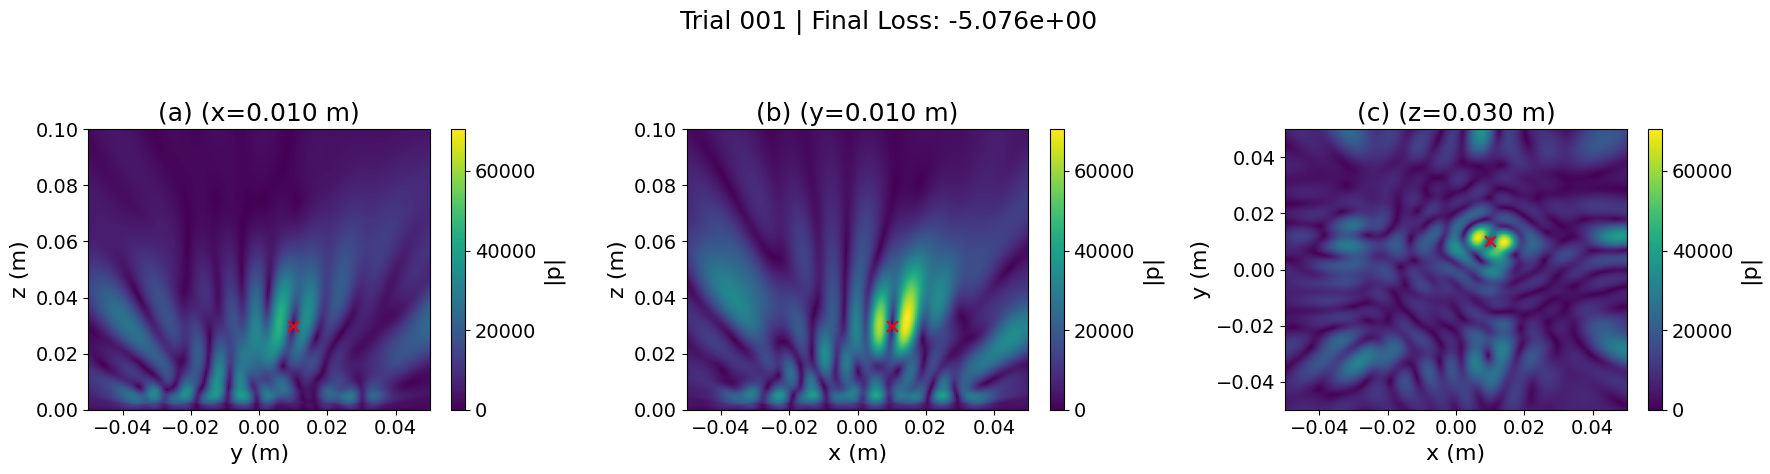

  [OK] Pressure plot saved: results/regularized_hybrid_vortex_alpha30000/trial_001_field_slices.png
  [INFO] Computing decision-space slices at final point and saving/disp ...


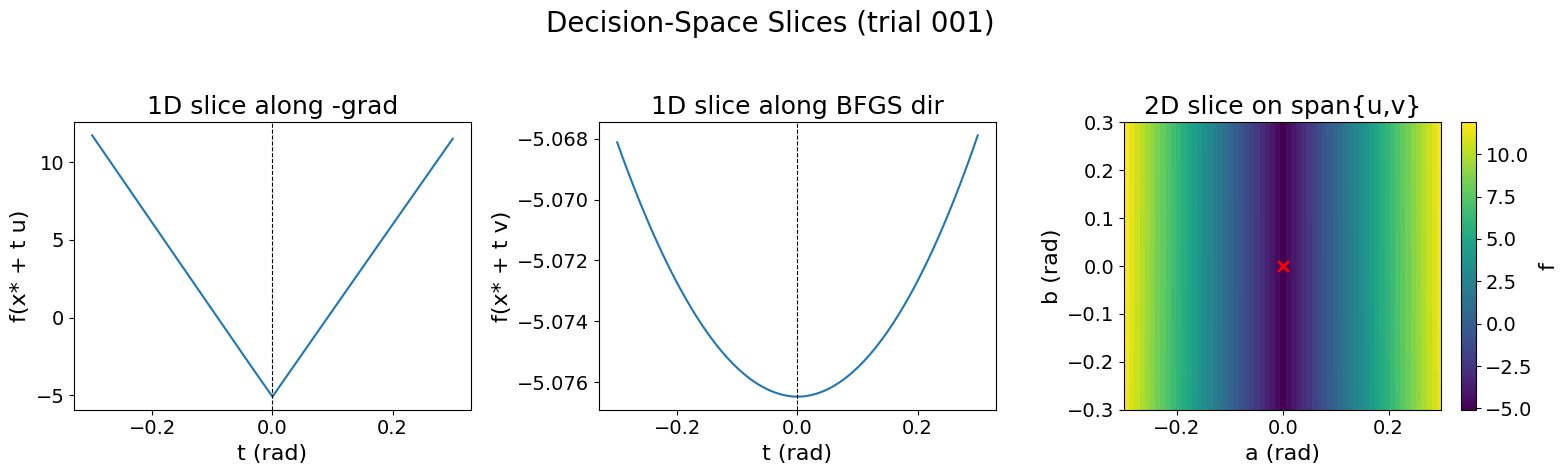

  [OK] Decision-space plot saved: results/regularized_hybrid_vortex_alpha30000/trial_001_decision_slices.png
[OK] Saved per-step CSV: results/regularized_hybrid_vortex_alpha30000/regularized_hybrid_vortex_alpha30000_result.csv

[RUN] Method=regularized_hybrid_vortex, alpha=10000
  'regularized_hybrid_vortex' configured successfully: Weights={'w_lap': 1.0, 'alpha': 500.0, 'beta': 5e-05}, Penalty='smooth_abs'
[INFO] Overridden Weights: {'w_lap': 1.0, 'alpha': 10000.0, 'beta': 5e-05}
[INFO] Output dir (alpha-tagged): results/regularized_hybrid_vortex_alpha10000

--- Running Trial 1/1 ---
  Trial 1, Step 200 | loss=-4.692e+00 | Δ(step)=5.680e-02 | ρ_lin=4.465e-01 | α_imp=2.965e-01 | cosθ=0.006 | t=5.0s
  Trial 1, Step 400 | loss=-4.744e+00 | Δ(step)=3.086e-02 | ρ_lin=1.714e-01 | α_imp=6.377e-01 | cosθ=0.002 | t=9.8s
  Trial 1, Step 600 | loss=-4.794e+00 | Δ(step)=2.725e-02 | ρ_lin=6.346e-01 | α_imp=1.000e+00 | cosθ=0.001 | t=16.0s
  Trial 1, Step 800 | loss=-4.839e+00 | Δ(step)=4.015e-02 |

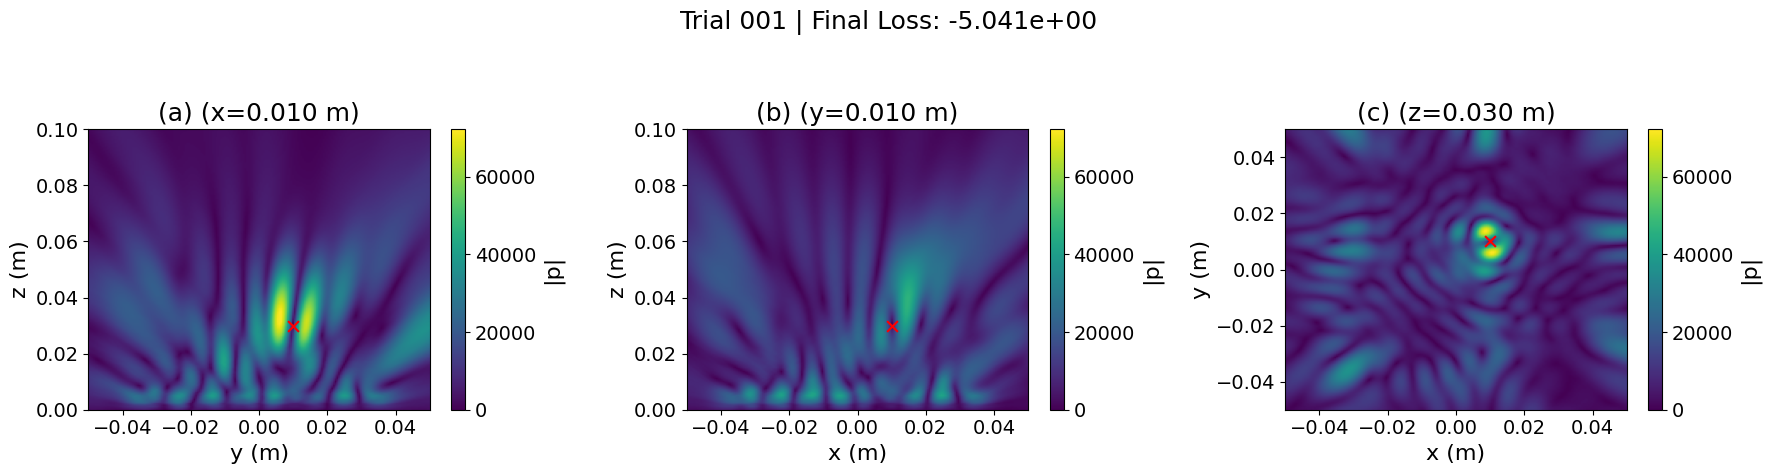

  [OK] Pressure plot saved: results/regularized_hybrid_vortex_alpha10000/trial_001_field_slices.png
  [INFO] Computing decision-space slices at final point and saving/disp ...


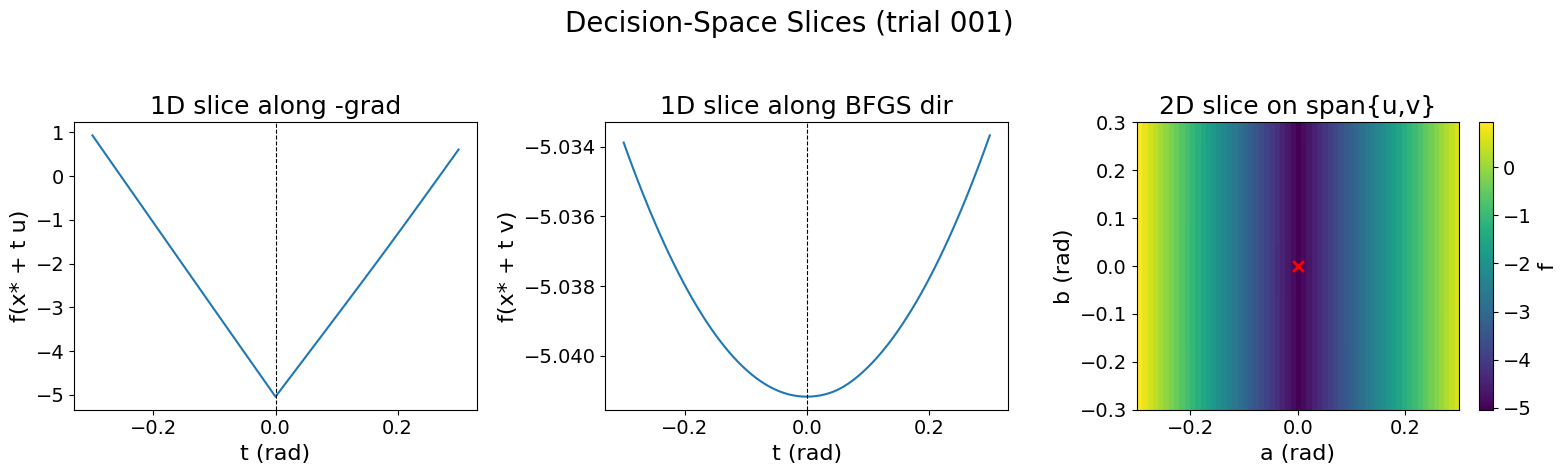

  [OK] Decision-space plot saved: results/regularized_hybrid_vortex_alpha10000/trial_001_decision_slices.png
[OK] Saved per-step CSV: results/regularized_hybrid_vortex_alpha10000/regularized_hybrid_vortex_alpha10000_result.csv

[MASTER] Finished alpha sweep: 5000 and 10000.


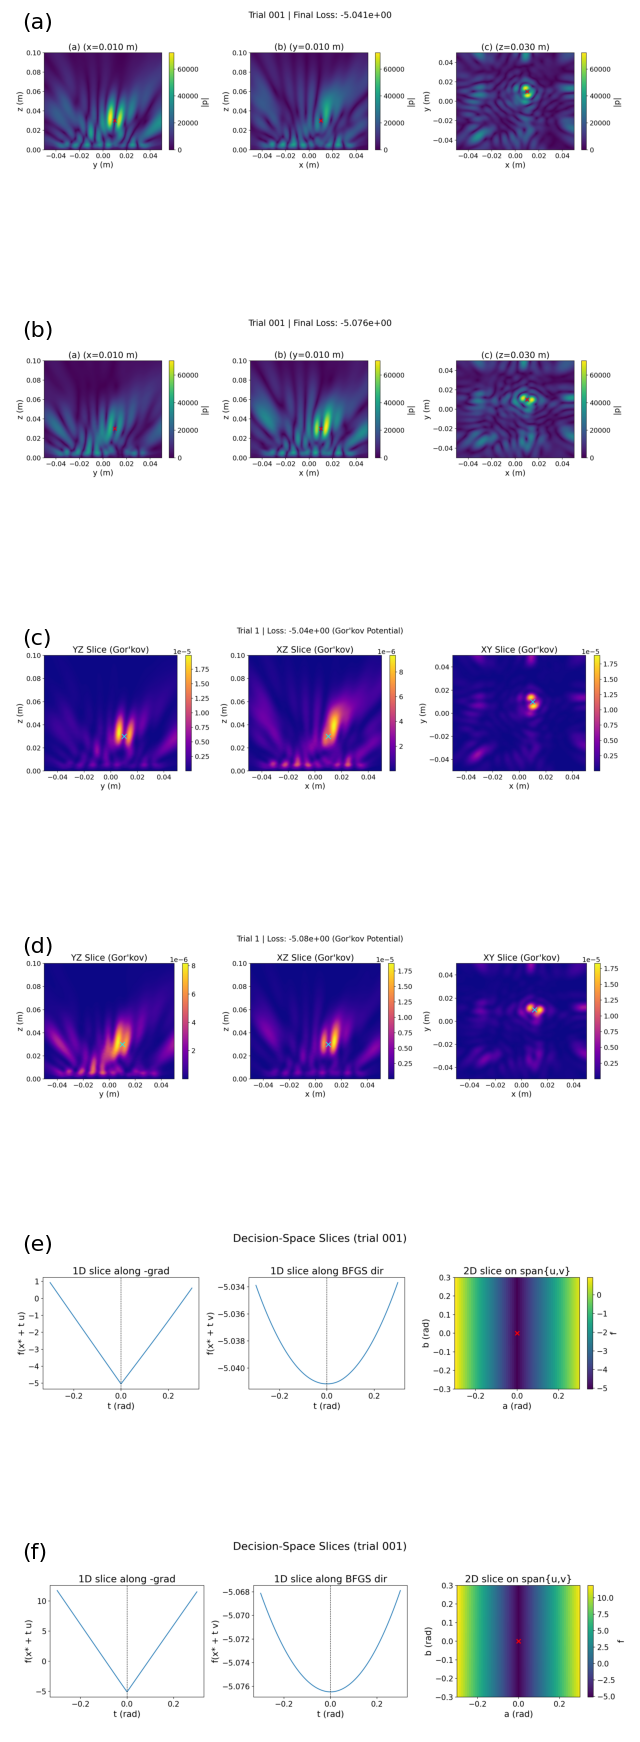

[OK] Saved stacked figure: /mnt/c/c++s/papertest/results/figs/Figure6.png


In [9]:
# fig6

from scipy.optimize import minimize
import matplotlib
import matplotlib.pyplot as plt

SHOW_PLOTS = True

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

optimizer_method = 'BFGS'

TARGET_COORD = (0.01, 0.01, 0.03)
target_coord_x, target_coord_y, target_coord_z = TARGET_COORD

x_idx = torch.argmin(torch.abs(x_vals - target_coord_x)).item()
y_idx = torch.argmin(torch.abs(y_vals - target_coord_y)).item()
z_idx = torch.argmin(torch.abs(z_vals - target_coord_z)).item()

def run_alpha_experiment(alpha_value: float):
    global OUTPUT_DIR, CURRENT_WEIGHTS
    method_name = "regularized_hybrid_vortex"
    print(f"\n{'='*70}\n[RUN] Method={method_name}, alpha={alpha_value}\n{'='*70}")
    configure_method(method_name)
    CURRENT_WEIGHTS = dict(CURRENT_WEIGHTS)
    CURRENT_WEIGHTS["alpha"] = float(alpha_value)
    OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, f"{method_name}_alpha{int(alpha_value)}")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"[INFO] Overridden Weights: {CURRENT_WEIGHTS}")
    print(f"[INFO] Output dir (alpha-tagged): {OUTPUT_DIR}")

    all_steps_log = []
    trial_start_time = time.time()
    trial_no = 1
    print(f"\n--- Running Trial {trial_no}/1 ---")

    initial_phases_np = np.random.rand(num_transducers) * 2.0 * math.pi
    recorder = StepRecorder(
        trial_number=trial_no,
        trial_start_time=trial_start_time,
        log_list=all_steps_log,
        total_steps=NUM_OPT_STEPS,
        x0_np=initial_phases_np
    )

    res = minimize(
        fun=objective_for_scipy,
        x0=initial_phases_np,
        method=optimizer_method,
        jac=jacobian_for_scipy,
        callback=recorder,
        options={'maxiter': 1e6, 'disp': False, 'gtol': 0}
    )

    trial_total_time = time.time() - trial_start_time
    print(f"[INFO] Trial {trial_no} Finished. Elapsed: {trial_total_time:.2f}s | Final loss: {res.fun:.3e} | iters={res.nit}")

    if GENERATE_SLICE_PLOTS:
        print("  [INFO] Computing 3 pressure slices (YZ/XZ/XY) and saving/disp ...")
        with torch.no_grad():
            final_phases = torch.tensor(res.x, dtype=torch.float64, device=device)
            yz_abs = compute_slice_YZ(final_phases, x_vals[x_idx])
            xz_abs = compute_slice_XZ(final_phases, y_vals[y_idx])
            xy_abs = compute_slice_XY(final_phases, z_vals[z_idx])

            fig = plot_field_slices(
                yz_abs.cpu().numpy(),
                xz_abs.cpu().numpy(),
                xy_abs.cpu().numpy(),
                trial_no, res.fun,
                target_coord=TARGET_COORD
            )
            pressure_path = os.path.join(OUTPUT_DIR, f"trial_{trial_no:03d}_field_slices.png")
            fig.savefig(pressure_path, dpi=150)

            print("  [INFO] Computing Gor'kov slices ...")
            yz_g = compute_slice_YZ_gorkov(final_phases, x_vals[x_idx].item())
            xz_g = compute_slice_XZ_gorkov(final_phases, y_vals[y_idx].item())
            xy_g = compute_slice_XY_gorkov(final_phases, z_vals[z_idx].item())

            title_text = f"Trial {trial_no} | Loss: {res.fun:.2e} (Gor'kov Potential)"
            
            fig_g = plot_gorkov_slices(
                yz_g.cpu().numpy(),
                xz_g.cpu().numpy(),
                xy_g.cpu().numpy(),
                title_str=title_text,
                target_coord=TARGET_COORD
            )
            gorkov_path = os.path.join(OUTPUT_DIR, f"trial_{trial_no:03d}_gorkov_slices.png")
            fig_g.savefig(gorkov_path, dpi=150)
            plt.close(fig_g)
            print(f"  [OK] Gor'kov plot saved: {gorkov_path}")
            
            if SHOW_PLOTS:
                plt.show()
            plt.close(fig)
            print(f"  [OK] Pressure plot saved: {pressure_path}")

    if GENERATE_DECISION_SLICES:
        print("  [INFO] Computing decision-space slices at final point and saving/disp ...")
        x_final = np.asarray(res.x, dtype=np.float64)
        g_final = jacobian_for_scipy(x_final)
        try:
            p_final = - recorder.H.dot(g_final)
        except Exception:
            p_final = - g_final

        fig2 = decision_space_slices(objective_for_scipy, x_final, g_final, p_final, trial_no)
        decision_path = os.path.join(OUTPUT_DIR, f"trial_{trial_no:03d}_decision_slices.png")
        fig2.savefig(decision_path, dpi=170)
        if SHOW_PLOTS:
            plt.show()
        plt.close(fig2)
        print(f"  [OK] Decision-space plot saved: {decision_path}")

    df_final = pd.DataFrame(all_steps_log)
    if not df_final.empty:
        metric_cols = [
            'step','time_s','loss','laplacian','gorkov_grad_mag','pressure_abs',
            'delta_tr_radius','rho_lin',
            'gnorm','pnorm','alpha_imp','cos_theta','r_ratio','sTy','cos_phi','gamma_scale',
            'lambda_min_est','lambda_max_est','kappa_est'
        ]
        phase_cols = [f'phase_{i}' for i in range(num_transducers)]
        final_cols = ['trial'] + metric_cols + phase_cols
        df_final = df_final[final_cols]
        csv_path = os.path.join(OUTPUT_DIR, f"{method_name}_alpha{int(alpha_value)}_result.csv")
        df_final.to_csv(csv_path, index=False)
        print(f"[OK] Saved per-step CSV: {csv_path}")

    if device.type == 'cuda':
        torch.cuda.empty_cache()

def _load_image_or_none(path):
    try:
        return matplotlib.image.imread(path)
    except Exception:
        return None

def _panel_title(alpha_value, kind):
    return ""

def _add_panel_label(ax, tag):
    ax.text(0.02, 0.98, f"({tag})", transform=ax.transAxes,
            ha="left", va="top", fontsize=16)

def _add_title_inside(ax, title):
    if title:
        ax.text(0.02, 0.92, title, transform=ax.transAxes,
                ha="left", va="top", fontsize=15)

def make_stacked_figure(base_dir, order, save_name="fig6_stacked_vertical.png"):
    fig, axes = plt.subplots(6, 1, figsize=(8.0, 24.0))
    for ax, (img_path, tag, title) in zip(axes, order):
        img = _load_image_or_none(img_path)
        if img is None:
            ax.text(0.5, 0.5, "Image not found:\n" + os.path.basename(img_path), ha="center", va="center")
            ax.axis("off")
            _add_panel_label(ax, tag)
            ax.set_title(title, loc="left", fontsize=15)
            continue
        ax.imshow(img)
        ax.axis("off")
        _add_panel_label(ax, tag)
        ax.set_title(title, loc="left", fontsize=16)
    
    fig.subplots_adjust(hspace=0.0)

    out_path = os.path.join(base_dir, save_name)
    os.makedirs(base_dir, exist_ok=True)
    fig.savefig(out_path, dpi=220, bbox_inches="tight")
    if SHOW_PLOTS:
        plt.show()
    plt.close(fig)
    print(f"[OK] Saved stacked figure: {out_path}")


if __name__ == "__main__":
    run_alpha_experiment(30000)
    run_alpha_experiment(10000)
    print(f"\n{'='*70}\n[MASTER] Finished alpha sweep: 5000 and 10000.\n{'='*70}")

    p_30000 = os.path.join(BASE_OUTPUT_DIR, "regularized_hybrid_vortex_alpha30000", "trial_001_field_slices.png")
    d_30000 = os.path.join(BASE_OUTPUT_DIR, "regularized_hybrid_vortex_alpha30000", "trial_001_decision_slices.png")
    g_10000 = os.path.join(BASE_OUTPUT_DIR, "regularized_hybrid_vortex_alpha10000", "trial_001_gorkov_slices.png")
    g_30000 = os.path.join(BASE_OUTPUT_DIR, "regularized_hybrid_vortex_alpha30000", "trial_001_gorkov_slices.png")
    p_10000 = os.path.join(BASE_OUTPUT_DIR, "regularized_hybrid_vortex_alpha10000", "trial_001_field_slices.png")
    d_10000 = os.path.join(BASE_OUTPUT_DIR, "regularized_hybrid_vortex_alpha10000", "trial_001_decision_slices.png")


    ordered = [
        (p_10000, "a", _panel_title(10000, "pressure")),
        (p_30000, "b", _panel_title(30000, "pressure")),
        (g_10000, "c", _panel_title(10000, "gorkov")),
        (g_30000, "d", _panel_title(30000, "gorkov")),
        (d_10000, "e", _panel_title(10000, "decision")),
        (d_30000, "f", _panel_title(30000, "decision")),
    ]

    make_stacked_figure(figs_dir, ordered, save_name="Figure6.png")


[INFO] Plots will be saved to: /mnt/c/c++s/papertest/results/figs
[INFO] Using device: cuda
[INFO] Starting Experiment Suite...
       Total Configurations: 21
       Trials per Config: 10


Total Progress: 100%|█████████████████████████████████████████████████████████████████| 210/210 [45:55<00:00, 13.12s/it]
/tmp/ipykernel_1422/1334594533.py:375: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.




[INFO] All experiments finished. Results saved to 'results/figs/Figure7_data.csv'.

=== Summary by Label ===
                                    eci           nts  laplacian  \
label                                                              
Conventional (1000, 10, 10)    0.284663  8.442772e-13   4.496747   
Conventional (1000, 100, 10)   0.283341  8.411346e-13   4.484377   
Conventional (1000, 1000, 10)  0.307098  1.013914e-12   5.423756   
Conventional (1000, 25, 10)    0.282324  8.404767e-13   4.458736   
Conventional (1000, 250, 10)   0.287219  8.524655e-13   4.543760   
Conventional (1000, 50, 10)    0.283356  8.350183e-13   4.493313   
Conventional (1000, 500, 10)   0.288707  8.608374e-13   4.560780   
Conventional (1000, 75, 10)    0.280745  8.335429e-13   4.444162   
Conventional (1000, 750, 10)   0.296492  9.380061e-13   5.036742   
Regularized Hybrid (α=100)     0.308287  1.034537e-12   5.518790   
Regularized Hybrid (α=1000)    0.305112  1.014560e-12   5.232885   
Regula

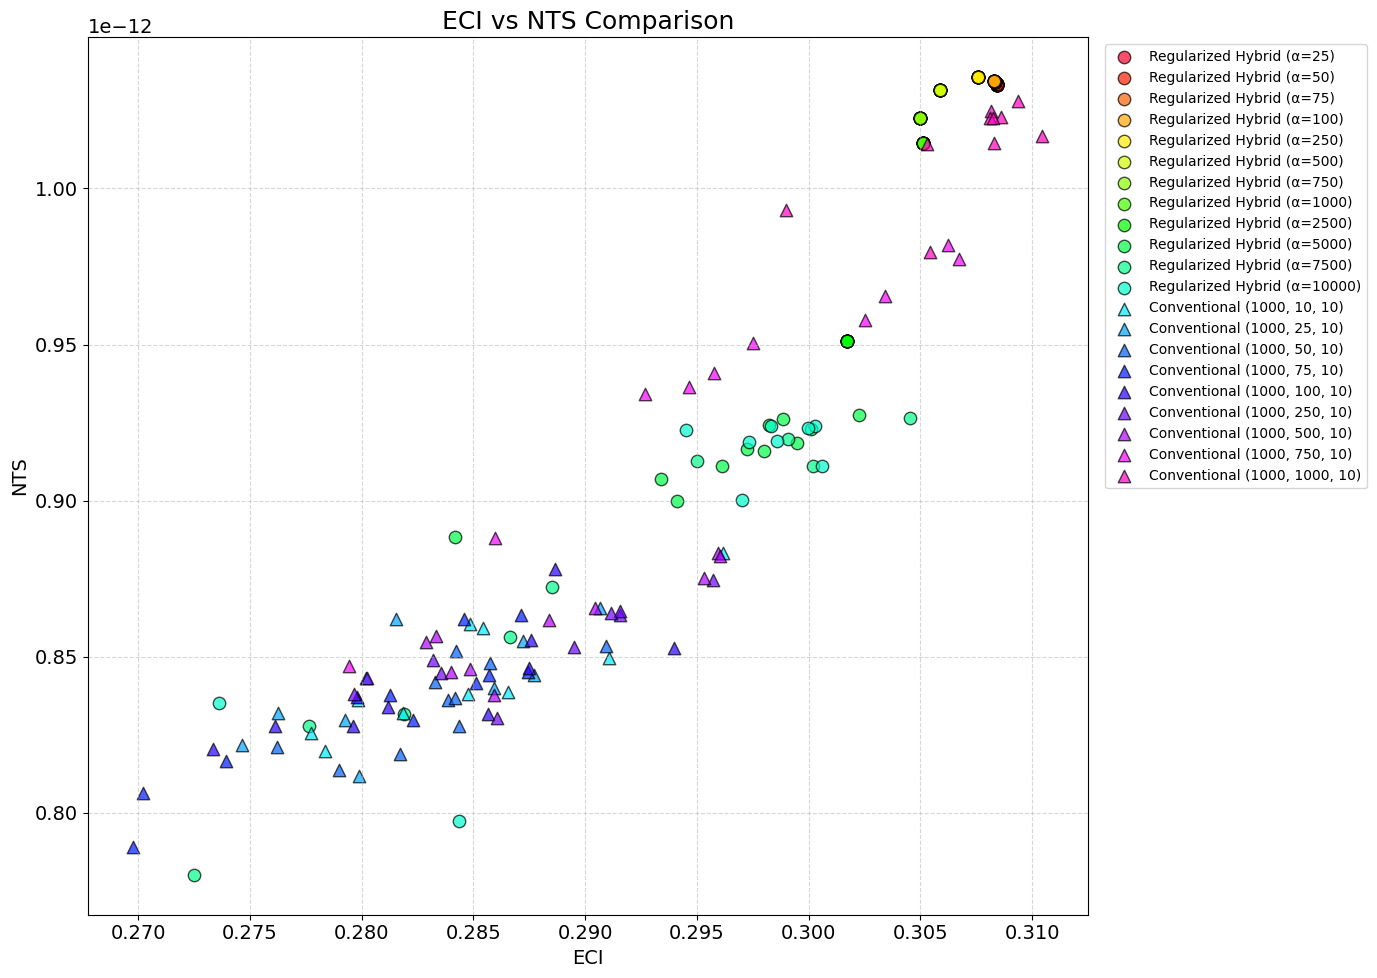

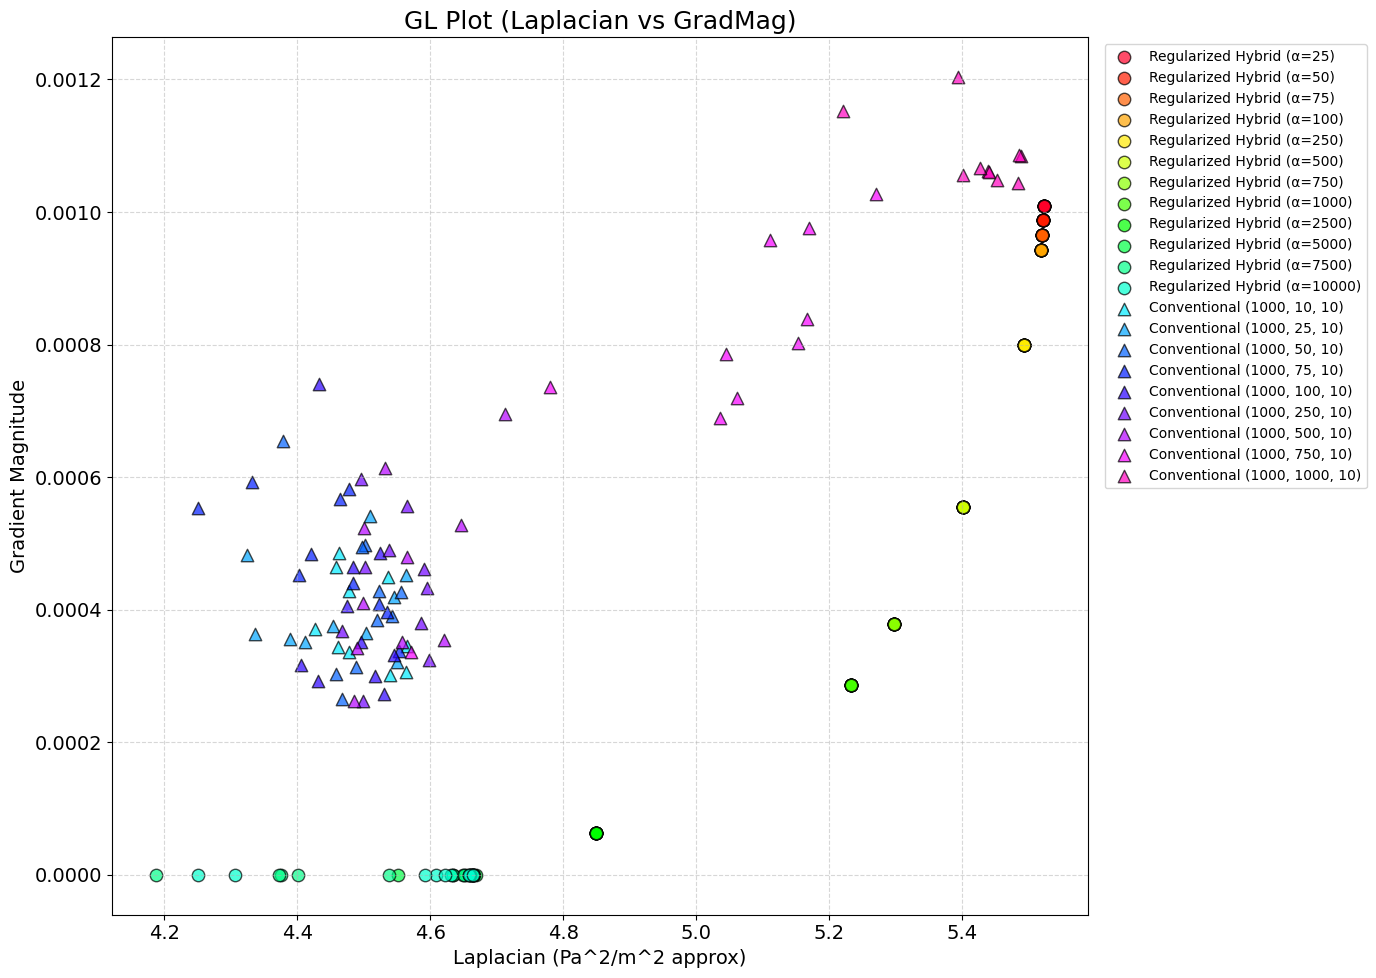

In [10]:
# fig7

FIGS_DIR = os.path.join("results", "figs")
os.makedirs(FIGS_DIR, exist_ok=True)
print(f"[INFO] Plots will be saved to: {os.path.abspath(FIGS_DIR)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(SEED)

FREQUENCY = 40000.0
C0 = 343.0
WAVELENGTH = C0 / FREQUENCY
RHO0 = 1.225
RHO_P = 100.0
C_P = 2400.0
PARTICLE_R = 1.3e-3 / 2
PARTICLE_V = 4/3 * math.pi * PARTICLE_R**3

OMEGA = 2 * math.pi * FREQUENCY
K1 = 0.25 * PARTICLE_V * (1 / (C0**2 * RHO0) - 1 / (C_P**2 * RHO_P))
K2 = 0.75 * PARTICLE_V * ((RHO0 - RHO_P) / (OMEGA**2 * RHO0 * (RHO0 + 2 * RHO_P)))

AMP_TABLE = torch.tensor([
    10.000, 11.832, 13.509, 15.414, 17.615, 18.240, 20.172, 21.626, 22.309, 23.054, 23.820, 23.820, 23.820,
    24.650, 24.650, 26.306, 29.052, 32.140, 35.496, 39.243, 41.952, 46.411, 47.958, 49.598, 53.009, 56.657,
    58.652, 60.581, 62.610, 64.885, 67.007, 69.282, 71.624, 71.624, 76.551, 76.551, 79.183, 84.676, 84.676,
    87.579, 90.388, 93.488, 93.488, 93.488, 90.388, 87.579, 84.676, 84.676, 79.183, 76.551, 76.551, 71.624, 71.624,
    69.282, 67.007, 64.885, 62.610, 60.581, 58.652, 56.657, 53.009, 49.598, 47.958, 46.411, 41.952, 39.243, 35.496,
    32.140, 29.052, 26.306, 24.650, 24.650, 23.820, 23.820, 23.820, 23.054, 22.309, 21.626, 20.172, 18.240, 17.615,
    15.414, 13.509, 11.832, 10.000
], dtype=torch.float64, device=device)

x_coords = np.arange(-3.5, 4.5, 1.0)
y_coords = np.arange(-3.5, 4.5, 1.0)
transducer_positions = torch.tensor(
    [(x * 0.01, y * 0.01, 0.0) for x in x_coords for y in y_coords],
    dtype=torch.float64, device=device
)
NUM_TRANSDUCERS = len(transducer_positions)

GRID_SIZE = 201
x_vals = torch.linspace(-0.05, 0.05, GRID_SIZE, dtype=torch.float64, device=device)
y_vals = torch.linspace(-0.05, 0.05, GRID_SIZE, dtype=torch.float64, device=device)
z_vals = torch.linspace(0.0, 0.1, GRID_SIZE, dtype=torch.float64, device=device)
dx = (x_vals[1] - x_vals[0]).item()
dy = (y_vals[1] - y_vals[0]).item()
dz = (z_vals[1] - z_vals[0]).item()

TARGET_COORD = (0.01, 0.01, 0.03)

W_LAPLACIAN_XX = 1.0
W_LAPLACIAN_YY = 1.0
W_LAPLACIAN_ZZ = 1.0
PRESSURE_PENALTY_MODE = 'smooth_abs'
CURRENT_WEIGHTS = {'w_lap': 1.0, 'alpha': 0.0, 'beta': 0.0}

def compute_pressure_field_torch_v2(phase_vector, amp_table, wavelength, X, Y, Z, transducer_positions):
    k_val = 2.0 * math.pi / wavelength
    grid_points = torch.stack([X.reshape(-1), Y.reshape(-1), Z.reshape(-1)], dim=1)
    delta = grid_points.unsqueeze(1) - transducer_positions.unsqueeze(0)
    
    R = torch.linalg.norm(delta, dim=2).clamp_min(1e-9)
    cos_theta = torch.clamp(delta[:, :, 2] / R, -1.0, 1.0)
    theta_deg = torch.rad2deg(torch.acos(cos_theta)).clamp(0.0, 90.0)
    
    max_idx = amp_table.shape[0] - 1
    low_index = torch.floor(theta_deg).long().clamp(0, max_idx)
    high_index = torch.clamp(low_index + 1, max=max_idx)
    frac = (theta_deg - low_index.to(torch.float64))
    
    A_low = amp_table[low_index]
    A_high = amp_table[high_index]
    A_theta = A_low + frac * (A_high - A_low)
    
    amplitude = A_theta / R
    propagation_phase = k_val * R
    total_phase = phase_vector.unsqueeze(0) + propagation_phase 
    p_complex = torch.polar(amplitude, total_phase)
    p_field = torch.sum(p_complex, dim=1) 
    return p_field.reshape(X.shape)

def compute_gradient_torch(U, dx, dy, dz):
    return torch.gradient(U, spacing=(dx, dy, dz), edge_order=1)

def compute_laplacian_weighted_torch(U, dx, dy, dz):
    grad_U_x, grad_U_y, grad_U_z = compute_gradient_torch(U, dx, dy, dz)
    L_xx, _, _ = torch.gradient(grad_U_x, spacing=(dx, dy, dz), edge_order=1)
    _, L_yy, _ = torch.gradient(grad_U_y, spacing=(dx, dy, dz), edge_order=1)
    _, _, L_zz = torch.gradient(grad_U_z, spacing=(dx, dy, dz), edge_order=1)
    return W_LAPLACIAN_XX * L_xx + W_LAPLACIAN_YY * L_yy + W_LAPLACIAN_ZZ * L_zz

def pressure_penalty(p2_center, p_abs_center, p2_local_rms):
    if PRESSURE_PENALTY_MODE == 'smooth_abs':
        eps = 1e-3 * (p2_local_rms + 1e-32)
        return torch.sqrt(p2_center + eps*eps)
    elif PRESSURE_PENALTY_MODE == 'abs':
        return torch.sqrt(p2_center + 1e-32)
    return torch.tensor(0.0, device=device, dtype=torch.float64)

def compute_gorkov_objective_local_torch(pf, dx, dy, dz):
    abs_p2 = (pf.real**2 + pf.imag**2)
    dpdx, dpdy, dpdz = compute_gradient_torch(pf, dx, dy, dz)
    v_sq = (dpdx.real**2 + dpdx.imag**2) + (dpdy.real**2 + dpdy.imag**2) + (dpdz.real**2 + dpdz.imag**2)
    U = K1 * abs_p2 - K2 * v_sq

    gradUx, gradUy, gradUz = compute_gradient_torch(U, dx, dy, dz)
    
    lapU_weighted = compute_laplacian_weighted_torch(U, dx, dy, dz)
    
    half = pf.shape[0] // 2
    center_idx = (half, half, half)
    laplacian_val = lapU_weighted[center_idx]
    grad_mag_val = torch.sqrt(gradUx[center_idx]**2 + gradUy[center_idx]**2 + gradUz[center_idx]**2)
    
    p2_center = abs_p2[center_idx]
    p_abs_center = torch.sqrt(p2_center + 1e-32)
    p2_local_rms = torch.sqrt(torch.mean(abs_p2))
    
    w_lap = CURRENT_WEIGHTS['w_lap']
    alpha = CURRENT_WEIGHTS['alpha']
    beta  = CURRENT_WEIGHTS['beta']
    
    p_pen = pressure_penalty(p2_center, p_abs_center, p2_local_rms)
    
    metric = (w_lap * laplacian_val - alpha * grad_mag_val - beta * p_pen)
    return metric, laplacian_val, grad_mag_val


def objective_fn_torch_dynamic(ph_tensor, target_indices):
    x_idx, y_idx, z_idx = target_indices
    half = 2
    x_local = x_vals[x_idx-half:x_idx+half+1]
    y_local = y_vals[y_idx-half:y_idx+half+1]
    z_local = z_vals[z_idx-half:z_idx+half+1]
    Xl, Yl, Zl = torch.meshgrid(x_local, y_local, z_local, indexing='ij')
    
    pf_local = compute_pressure_field_torch_v2(ph_tensor, AMP_TABLE, WAVELENGTH, Xl, Yl, Zl, transducer_positions)
    metric, _, _ = compute_gorkov_objective_local_torch(pf_local, dx, dy, dz)
    return -metric 

def objective_for_scipy(phases_np, target_indices):
    phases_torch = torch.tensor(phases_np, dtype=torch.float64, device=device)
    loss = objective_fn_torch_dynamic(phases_torch, target_indices)
    return float(loss.item())

def jacobian_for_scipy(phases_np, target_indices):
    phases_torch = torch.tensor(phases_np, dtype=torch.float64, device=device, requires_grad=True)
    loss = objective_fn_torch_dynamic(phases_torch, target_indices)
    (grad,) = torch.autograd.grad(loss, phases_torch)
    return grad.detach().cpu().numpy().astype(np.float64)


def calculate_eci_and_nts_pure(phase_tensor, target_coord):
    global W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ
    old_xx, old_yy, old_zz = W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ
    
    W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ = 1.0, 1.0, 1.0
    
    z_target = target_coord[2]
    z_idx = torch.argmin(torch.abs(z_vals - z_target)).item()
    Xl, Yl = torch.meshgrid(x_vals, y_vals, indexing='ij')
    Zl = torch.full_like(Xl, z_vals[z_idx])
    
    pf_slice = compute_pressure_field_torch_v2(phase_tensor, AMP_TABLE, WAVELENGTH, Xl, Yl, Zl, transducer_positions)
    pressure_abs = torch.abs(pf_slice).cpu().numpy()
    
    x_idx = torch.argmin(torch.abs(x_vals - target_coord[0])).item()
    y_idx = torch.argmin(torch.abs(y_vals - target_coord[1])).item()
    
    half = 2
    x_local = x_vals[x_idx-half:x_idx+half+1]
    y_local = y_vals[y_idx-half:y_idx+half+1]
    z_local = z_vals[z_idx-half:z_idx+half+1]
    X_sub, Y_sub, Z_sub = torch.meshgrid(x_local, y_local, z_local, indexing='ij')
    
    pf_local = compute_pressure_field_torch_v2(phase_tensor, AMP_TABLE, WAVELENGTH, X_sub, Y_sub, Z_sub, transducer_positions)
    
    abs_p2 = (pf_local.real**2 + pf_local.imag**2)
    dpdx, dpdy, dpdz = compute_gradient_torch(pf_local, dx, dy, dz)
    v_sq = (dpdx.real**2 + dpdx.imag**2) + (dpdy.real**2 + dpdy.imag**2) + (dpdz.real**2 + dpdz.imag**2)
    U = K1 * abs_p2 - K2 * v_sq
    
    lapU = compute_laplacian_weighted_torch(U, dx, dy, dz)
    gradUx, gradUy, gradUz = compute_gradient_torch(U, dx, dy, dz)
    
    center = (half, half, half)
    laplacian_val = float(lapU[center].item())
    gorkov_grad_mag = float(torch.sqrt(gradUx[center]**2 + gradUy[center]**2 + gradUz[center]**2).item())
    
    energy_slice = pressure_abs**2
    e_total = np.sum(energy_slice)
    
    x_vals_np = x_vals.cpu().numpy()
    y_vals_np = y_vals.cpu().numpy()
    y_grid, x_grid = np.meshgrid(y_vals_np, x_vals_np)
    dist_sq = (x_grid - target_coord[0])**2 + (y_grid - target_coord[1])**2
    roi_mask = dist_sq <= (0.015)**2
    
    e_roi = np.sum(energy_slice[roi_mask])
    eci = e_roi / e_total if e_total > 0 else 0.0
    nts = laplacian_val / e_total if e_total > 0 else 0.0
    
    W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ = old_xx, old_yy, old_zz
    
    return eci, nts, laplacian_val, gorkov_grad_mag

def compute_slice_YZ(phase_vector, x_fixed):
    Yl, Zl = torch.meshgrid(y_vals, z_vals, indexing='ij')
    Xl = torch.full_like(Yl, x_fixed)
    pf = compute_pressure_field_torch_v2(phase_vector, AMP_TABLE, WAVELENGTH, Xl, Yl, Zl, transducer_positions)
    return torch.abs(pf)

def compute_slice_XZ(phase_vector, y_fixed):
    Xl, Zl = torch.meshgrid(x_vals, z_vals, indexing='ij')
    Yl = torch.full_like(Xl, y_fixed)
    pf = compute_pressure_field_torch_v2(phase_vector, AMP_TABLE, WAVELENGTH, Xl, Yl, Zl, transducer_positions)
    return torch.abs(pf)

def compute_slice_XY(phase_vector, z_fixed):
    Xl, Yl = torch.meshgrid(x_vals, y_vals, indexing='ij')
    Zl = torch.full_like(Xl, z_fixed)
    pf = compute_pressure_field_torch_v2(phase_vector, AMP_TABLE, WAVELENGTH, Xl, Yl, Zl, transducer_positions)
    return torch.abs(pf)

def plot_pressure_slices(yz_np, xz_np, xy_np, title_str, save_path, target_coord):
    tx, ty, tz = target_coord
    x_np = x_vals.cpu().numpy()
    y_np = y_vals.cpu().numpy()
    z_np = z_vals.cpu().numpy()

    fig = plt.figure(figsize=(18, 5))
    vmax = max(yz_np.max(), xz_np.max(), xy_np.max())
    
    ax1 = fig.add_subplot(1, 3, 1)
    im1 = ax1.imshow(yz_np.T, origin='lower', extent=[y_np[0], y_np[-1], z_np[0], z_np[-1]],
                     cmap='viridis', aspect='auto', vmin=0, vmax=vmax)
    ax1.scatter([ty], [tz], c='red', marker='x', s=100)
    ax1.set_title("YZ Slice (|p|)")
    plt.colorbar(im1, ax=ax1)

    ax2 = fig.add_subplot(1, 3, 2)
    im2 = ax2.imshow(xz_np.T, origin='lower', extent=[x_np[0], x_np[-1], z_np[0], z_np[-1]],
                     cmap='viridis', aspect='auto', vmin=0, vmax=vmax)
    ax2.scatter([tx], [tz], c='red', marker='x', s=100)
    ax2.set_title("XZ Slice (|p|)")
    plt.colorbar(im2, ax=ax2)

    ax3 = fig.add_subplot(1, 3, 3)
    im3 = ax3.imshow(xy_np.T, origin='lower', extent=[x_np[0], x_np[-1], y_np[0], y_np[-1]],
                     cmap='viridis', aspect='auto', vmin=0, vmax=vmax)
    ax3.scatter([tx], [ty], c='red', marker='x', s=100)
    ax3.set_title("XY Slice (|p|)")
    plt.colorbar(im3, ax=ax3)

    plt.suptitle(title_str, fontsize=16)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close(fig)


def run_experiment_suite():
    global W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ
    global CURRENT_WEIGHTS, PRESSURE_PENALTY_MODE
    
    hybrid_alphas = [25, 50, 75, 100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000]
    hybrid_configs = []
    for alpha in hybrid_alphas:
        hybrid_configs.append({
            'method': 'hybrid',
            'label': f"Regularized Hybrid (α={alpha})",
            'setup': {
                'w_vec': (1.0, 1.0, 1.0),
                'c_weights': {'w_lap': 1.0, 'alpha': float(alpha), 'beta': 5e-5},
                'p_mode': 'smooth_abs'
            }
        })
        
    conv_weights_list = [
        (1000, 10, 10),
        (1000, 25, 10),
        (1000, 50, 10),
        (1000, 75, 10),
        (1000, 100, 10),
        (1000, 250, 10),
        (1000, 500, 10),
        (1000, 750, 10),
        (1000, 1000, 10)
    ]
    conv_configs = []
    for w in conv_weights_list:
        wx, wy, wz = w
        conv_configs.append({
            'method': 'conventional',
            'label': f"Conventional ({wx}, {wy}, {wz})",
            'setup': {
                'w_vec': (float(wx), float(wy), float(wz)),
                'c_weights': {'w_lap': 1.0, 'alpha': 0.0, 'beta': 1.0},
                'p_mode': 'abs'
            }
        })
        
    all_configs = hybrid_configs + conv_configs
    n_trials = 10
    
    results = []
    tx, ty, tz = TARGET_COORD
    x_idx = torch.argmin(torch.abs(x_vals - tx)).item()
    y_idx = torch.argmin(torch.abs(y_vals - ty)).item()
    z_idx = torch.argmin(torch.abs(z_vals - tz)).item()
    target_indices = (x_idx, y_idx, z_idx)
    
    print(f"[INFO] Starting Experiment Suite...")
    print(f"       Total Configurations: {len(all_configs)}")
    print(f"       Trials per Config: {n_trials}")
    
    total_steps = len(all_configs) * n_trials
    pbar = tqdm(total=total_steps, desc="Total Progress")
    
    for config in all_configs:
        setup = config['setup']
        W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ = setup['w_vec']
        CURRENT_WEIGHTS = setup['c_weights']
        PRESSURE_PENALTY_MODE = setup['p_mode']
        
        method_name = config['method']
        label_name = config['label']
        
        for trial in range(n_trials):
            initial_phases = np.random.rand(NUM_TRANSDUCERS) * 2.0 * math.pi
            
            res = minimize(
                fun=lambda x: objective_for_scipy(x, target_indices),
                x0=initial_phases,
                method='BFGS',
                jac=lambda x: jacobian_for_scipy(x, target_indices),
                options={'maxiter': 2000, 'gtol': 1e-5}
            )
            
            final_phases_torch = torch.tensor(res.x, dtype=torch.float64, device=device)
            eci, nts, lap_val, grad_mag = calculate_eci_and_nts_pure(final_phases_torch, TARGET_COORD)
            
            record = {
                "method": method_name,
                "label": label_name,
                "trial": trial,
                "loss": res.fun,
                "eci": eci,
                "nts": nts,
                "laplacian": lap_val,
                "gorkov_grad_mag": grad_mag
            }
            results.append(record)
            pbar.update(1)

    pbar.close()
    df = pd.DataFrame(results)
    return df


def plot_combined_results(df):
    labels = df['label'].unique()
    n_labels = len(labels)
    
    cmap = cm.get_cmap('gist_rainbow', n_labels)
    colors_dict = {label: cmap(i) for i, label in enumerate(labels)}
    
    markers = {'hybrid': 'o', 'conventional': '^'}
    
    plt.figure(figsize=(14, 10))
    for label in labels:
        subset = df[df['label'] == label]
        m_type = subset['method'].iloc[0]
        plt.scatter(
            subset['eci'], subset['nts'],
            label=label,
            color=colors_dict[label],
            marker=markers.get(m_type, 'o'),
            s=80, alpha=0.7, edgecolors='k'
        )
    plt.title("ECI vs NTS Comparison", fontsize=18)
    plt.xlabel("ECI", fontsize=14)
    plt.ylabel("NTS", fontsize=14)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGS_DIR, "Figure7(a).png"), dpi=150)
    plt.show()
    
    plt.figure(figsize=(14, 10))
    for label in labels:
        subset = df[df['label'] == label]
        m_type = subset['method'].iloc[0]
        plt.scatter(
            subset['laplacian'], subset['gorkov_grad_mag'],
            label=label,
            color=colors_dict[label],
            marker=markers.get(m_type, 'o'),
            s=80, alpha=0.7, edgecolors='k'
        )
    plt.title("GL Plot (Laplacian vs GradMag)", fontsize=18)
    plt.xlabel("Laplacian (Pa^2/m^2 approx)", fontsize=14)
    plt.ylabel("Gradient Magnitude", fontsize=14)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGS_DIR, "Figure7(b).png"), dpi=150)
    plt.show()
    

if __name__ == "__main__":
    df_results = run_experiment_suite()
    print("\n=== Summary by Label ===")
    print(df_results.groupby("label")[["eci", "nts", "laplacian", "gorkov_grad_mag"]].mean())
    plot_combined_results(df_results)

In [5]:
# fig8

FIGS_DIR = os.path.join("results", "figs")
os.makedirs(FIGS_DIR, exist_ok=True)
print(f"[INFO] Plots will be saved to: {os.path.abspath(FIGS_DIR)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(SEED)

FREQUENCY = 40000.0
C0 = 343.0
WAVELENGTH = C0 / FREQUENCY
RHO0 = 1.225
RHO_P = 100.0
C_P = 2400.0
PARTICLE_R = 1.3e-3 / 2
PARTICLE_V = 4/3 * math.pi * PARTICLE_R**3

OMEGA = 2 * math.pi * FREQUENCY
K1 = 0.25 * PARTICLE_V * (1 / (C0**2 * RHO0) - 1 / (C_P**2 * RHO_P))
K2 = 0.75 * PARTICLE_V * ((RHO0 - RHO_P) / (OMEGA**2 * RHO0 * (RHO0 + 2 * RHO_P)))

AMP_TABLE = torch.tensor([
    10.000, 11.832, 13.509, 15.414, 17.615, 18.240, 20.172, 21.626, 22.309, 23.054, 23.820, 23.820, 23.820,
    24.650, 24.650, 26.306, 29.052, 32.140, 35.496, 39.243, 41.952, 46.411, 47.958, 49.598, 53.009, 56.657,
    58.652, 60.581, 62.610, 64.885, 67.007, 69.282, 71.624, 71.624, 76.551, 76.551, 79.183, 84.676, 84.676,
    87.579, 90.388, 93.488, 93.488, 93.488, 90.388, 87.579, 84.676, 84.676, 79.183, 76.551, 76.551, 71.624, 71.624,
    69.282, 67.007, 64.885, 62.610, 60.581, 58.652, 56.657, 53.009, 49.598, 47.958, 46.411, 41.952, 39.243, 35.496,
    32.140, 29.052, 26.306, 24.650, 24.650, 23.820, 23.820, 23.820, 23.054, 22.309, 21.626, 20.172, 18.240, 17.615,
    15.414, 13.509, 11.832, 10.000
], dtype=torch.float64, device=device)

x_coords = np.arange(-3.5, 4.5, 1.0)
y_coords = np.arange(-3.5, 4.5, 1.0)
transducer_positions = torch.tensor(
    [(x * 0.01, y * 0.01, 0.0) for x in x_coords for y in y_coords],
    dtype=torch.float64, device=device
)
NUM_TRANSDUCERS = len(transducer_positions)

GRID_SIZE = 201
x_vals = torch.linspace(-0.05, 0.05, GRID_SIZE, dtype=torch.float64, device=device)
y_vals = torch.linspace(-0.05, 0.05, GRID_SIZE, dtype=torch.float64, device=device)
z_vals = torch.linspace(0.0, 0.1, GRID_SIZE, dtype=torch.float64, device=device)
dx = (x_vals[1] - x_vals[0]).item()
dy = (y_vals[1] - y_vals[0]).item()
dz = (z_vals[1] - z_vals[0]).item()

TARGET_COORD = (0.01, 0.01, 0.03)

W_LAPLACIAN_XX = 1.0
W_LAPLACIAN_YY = 1.0
W_LAPLACIAN_ZZ = 1.0
PRESSURE_PENALTY_MODE = 'smooth_abs'
CURRENT_WEIGHTS = {'w_lap': 1.0, 'alpha': 0.0, 'beta': 0.0}

def compute_pressure_field_torch_v2(phase_vector, amp_table, wavelength, X, Y, Z, transducer_positions):
    k_val = 2.0 * math.pi / wavelength
    grid_points = torch.stack([X.reshape(-1), Y.reshape(-1), Z.reshape(-1)], dim=1)
    delta = grid_points.unsqueeze(1) - transducer_positions.unsqueeze(0)
    
    R = torch.linalg.norm(delta, dim=2).clamp_min(1e-9)
    cos_theta = torch.clamp(delta[:, :, 2] / R, -1.0, 1.0)
    theta_deg = torch.rad2deg(torch.acos(cos_theta)).clamp(0.0, 90.0)
    
    max_idx = amp_table.shape[0] - 1
    low_index = torch.floor(theta_deg).long().clamp(0, max_idx)
    high_index = torch.clamp(low_index + 1, max=max_idx)
    frac = (theta_deg - low_index.to(torch.float64))
    
    A_low = amp_table[low_index]
    A_high = amp_table[high_index]
    A_theta = A_low + frac * (A_high - A_low)
    
    amplitude = A_theta / R
    propagation_phase = k_val * R
    total_phase = phase_vector.unsqueeze(0) + propagation_phase 
    p_complex = torch.polar(amplitude, total_phase)
    p_field = torch.sum(p_complex, dim=1) 
    return p_field.reshape(X.shape)

def compute_gradient_torch(U, dx, dy, dz):
    return torch.gradient(U, spacing=(dx, dy, dz), edge_order=1)

def compute_laplacian_weighted_torch(U, dx, dy, dz):
    grad_U_x, grad_U_y, grad_U_z = compute_gradient_torch(U, dx, dy, dz)
    L_xx, _, _ = torch.gradient(grad_U_x, spacing=(dx, dy, dz), edge_order=1)
    _, L_yy, _ = torch.gradient(grad_U_y, spacing=(dx, dy, dz), edge_order=1)
    _, _, L_zz = torch.gradient(grad_U_z, spacing=(dx, dy, dz), edge_order=1)
    return W_LAPLACIAN_XX * L_xx + W_LAPLACIAN_YY * L_yy + W_LAPLACIAN_ZZ * L_zz

def pressure_penalty(p2_center, p_abs_center, p2_local_rms):
    if PRESSURE_PENALTY_MODE == 'smooth_abs':
        eps = 1e-3 * (p2_local_rms + 1e-32)
        return torch.sqrt(p2_center + eps*eps)
    elif PRESSURE_PENALTY_MODE == 'abs':
        return torch.sqrt(p2_center + 1e-32)
    return torch.tensor(0.0, device=device, dtype=torch.float64)

def compute_gorkov_objective_local_torch(pf, dx, dy, dz):
    abs_p2 = (pf.real**2 + pf.imag**2)
    dpdx, dpdy, dpdz = compute_gradient_torch(pf, dx, dy, dz)
    v_sq = (dpdx.real**2 + dpdx.imag**2) + (dpdy.real**2 + dpdy.imag**2) + (dpdz.real**2 + dpdz.imag**2)
    U = K1 * abs_p2 - K2 * v_sq

    gradUx, gradUy, gradUz = compute_gradient_torch(U, dx, dy, dz)
    
    lapU_weighted = compute_laplacian_weighted_torch(U, dx, dy, dz)
    
    half = pf.shape[0] // 2
    center_idx = (half, half, half)
    laplacian_val = lapU_weighted[center_idx]
    grad_mag_val = torch.sqrt(gradUx[center_idx]**2 + gradUy[center_idx]**2 + gradUz[center_idx]**2)
    
    p2_center = abs_p2[center_idx]
    p_abs_center = torch.sqrt(p2_center + 1e-32)
    p2_local_rms = torch.sqrt(torch.mean(abs_p2))
    
    w_lap = CURRENT_WEIGHTS['w_lap']
    alpha = CURRENT_WEIGHTS['alpha']
    beta  = CURRENT_WEIGHTS['beta']
    
    p_pen = pressure_penalty(p2_center, p_abs_center, p2_local_rms)
    
    metric = (w_lap * laplacian_val - alpha * grad_mag_val - beta * p_pen)
    return metric, laplacian_val, grad_mag_val


def objective_fn_torch_dynamic(ph_tensor, target_indices):
    x_idx, y_idx, z_idx = target_indices
    half = 2
    x_local = x_vals[x_idx-half:x_idx+half+1]
    y_local = y_vals[y_idx-half:y_idx+half+1]
    z_local = z_vals[z_idx-half:z_idx+half+1]
    Xl, Yl, Zl = torch.meshgrid(x_local, y_local, z_local, indexing='ij')
    
    pf_local = compute_pressure_field_torch_v2(ph_tensor, AMP_TABLE, WAVELENGTH, Xl, Yl, Zl, transducer_positions)
    metric, _, _ = compute_gorkov_objective_local_torch(pf_local, dx, dy, dz)
    return -metric 

def objective_for_scipy(phases_np, target_indices):
    phases_torch = torch.tensor(phases_np, dtype=torch.float64, device=device)
    loss = objective_fn_torch_dynamic(phases_torch, target_indices)
    return float(loss.item())

def jacobian_for_scipy(phases_np, target_indices):
    phases_torch = torch.tensor(phases_np, dtype=torch.float64, device=device, requires_grad=True)
    loss = objective_fn_torch_dynamic(phases_torch, target_indices)
    (grad,) = torch.autograd.grad(loss, phases_torch)
    return grad.detach().cpu().numpy().astype(np.float64)


def calculate_eci_and_nts_pure(phase_tensor, target_coord):
    global W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ
    old_xx, old_yy, old_zz = W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ
    
    W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ = 1.0, 1.0, 1.0
    
    z_target = target_coord[2]
    z_idx = torch.argmin(torch.abs(z_vals - z_target)).item()
    Xl, Yl = torch.meshgrid(x_vals, y_vals, indexing='ij')
    Zl = torch.full_like(Xl, z_vals[z_idx])
    
    pf_slice = compute_pressure_field_torch_v2(phase_tensor, AMP_TABLE, WAVELENGTH, Xl, Yl, Zl, transducer_positions)
    pressure_abs = torch.abs(pf_slice).cpu().numpy()
    
    x_idx = torch.argmin(torch.abs(x_vals - target_coord[0])).item()
    y_idx = torch.argmin(torch.abs(y_vals - target_coord[1])).item()
    
    half = 2
    x_local = x_vals[x_idx-half:x_idx+half+1]
    y_local = y_vals[y_idx-half:y_idx+half+1]
    z_local = z_vals[z_idx-half:z_idx+half+1]
    X_sub, Y_sub, Z_sub = torch.meshgrid(x_local, y_local, z_local, indexing='ij')
    
    pf_local = compute_pressure_field_torch_v2(phase_tensor, AMP_TABLE, WAVELENGTH, X_sub, Y_sub, Z_sub, transducer_positions)
    
    abs_p2 = (pf_local.real**2 + pf_local.imag**2)
    dpdx, dpdy, dpdz = compute_gradient_torch(pf_local, dx, dy, dz)
    v_sq = (dpdx.real**2 + dpdx.imag**2) + (dpdy.real**2 + dpdy.imag**2) + (dpdz.real**2 + dpdz.imag**2)
    U = K1 * abs_p2 - K2 * v_sq
    
    lapU = compute_laplacian_weighted_torch(U, dx, dy, dz)
    gradUx, gradUy, gradUz = compute_gradient_torch(U, dx, dy, dz)
    
    center = (half, half, half)
    laplacian_val = float(lapU[center].item())
    gorkov_grad_mag = float(torch.sqrt(gradUx[center]**2 + gradUy[center]**2 + gradUz[center]**2).item())
    
    energy_slice = pressure_abs**2
    e_total = np.sum(energy_slice)
    
    x_vals_np = x_vals.cpu().numpy()
    y_vals_np = y_vals.cpu().numpy()
    y_grid, x_grid = np.meshgrid(y_vals_np, x_vals_np)
    dist_sq = (x_grid - target_coord[0])**2 + (y_grid - target_coord[1])**2
    roi_mask = dist_sq <= (0.015)**2
    
    e_roi = np.sum(energy_slice[roi_mask])
    eci = e_roi / e_total if e_total > 0 else 0.0
    nts = laplacian_val / e_total if e_total > 0 else 0.0
    
    W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ = old_xx, old_yy, old_zz
    
    return eci, nts, laplacian_val, gorkov_grad_mag

def compute_slice_YZ(phase_vector, x_fixed):
    Yl, Zl = torch.meshgrid(y_vals, z_vals, indexing='ij')
    Xl = torch.full_like(Yl, x_fixed)
    pf = compute_pressure_field_torch_v2(phase_vector, AMP_TABLE, WAVELENGTH, Xl, Yl, Zl, transducer_positions)
    return torch.abs(pf)

def compute_slice_XZ(phase_vector, y_fixed):
    Xl, Zl = torch.meshgrid(x_vals, z_vals, indexing='ij')
    Yl = torch.full_like(Xl, y_fixed)
    pf = compute_pressure_field_torch_v2(phase_vector, AMP_TABLE, WAVELENGTH, Xl, Yl, Zl, transducer_positions)
    return torch.abs(pf)

def compute_slice_XY(phase_vector, z_fixed):
    Xl, Yl = torch.meshgrid(x_vals, y_vals, indexing='ij')
    Zl = torch.full_like(Xl, z_fixed)
    pf = compute_pressure_field_torch_v2(phase_vector, AMP_TABLE, WAVELENGTH, Xl, Yl, Zl, transducer_positions)
    return torch.abs(pf)

def plot_pressure_slices(yz_np, xz_np, xy_np, title_str, save_path, target_coord):
    tx, ty, tz = target_coord
    x_np = x_vals.cpu().numpy()
    y_np = y_vals.cpu().numpy()
    z_np = z_vals.cpu().numpy()

    fig = plt.figure(figsize=(18, 5))
    vmax = max(yz_np.max(), xz_np.max(), xy_np.max())
    
    ax1 = fig.add_subplot(1, 3, 1)
    im1 = ax1.imshow(yz_np.T, origin='lower', extent=[y_np[0], y_np[-1], z_np[0], z_np[-1]],
                     cmap='viridis', aspect='auto', vmin=0, vmax=vmax)
    ax1.scatter([ty], [tz], c='red', marker='x', s=100)
    ax1.set_title("YZ Slice (|p|)")
    plt.colorbar(im1, ax=ax1)

    ax2 = fig.add_subplot(1, 3, 2)
    im2 = ax2.imshow(xz_np.T, origin='lower', extent=[x_np[0], x_np[-1], z_np[0], z_np[-1]],
                     cmap='viridis', aspect='auto', vmin=0, vmax=vmax)
    ax2.scatter([tx], [tz], c='red', marker='x', s=100)
    ax2.set_title("XZ Slice (|p|)")
    plt.colorbar(im2, ax=ax2)

    ax3 = fig.add_subplot(1, 3, 3)
    im3 = ax3.imshow(xy_np.T, origin='lower', extent=[x_np[0], x_np[-1], y_np[0], y_np[-1]],
                     cmap='viridis', aspect='auto', vmin=0, vmax=vmax)
    ax3.scatter([tx], [ty], c='red', marker='x', s=100)
    ax3.set_title("XY Slice (|p|)")
    plt.colorbar(im3, ax=ax3)

    plt.suptitle(title_str, fontsize=16)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close(fig)


def run_experiment_suite():
    global W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ
    global CURRENT_WEIGHTS, PRESSURE_PENALTY_MODE
    target_alphas = [100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]
    
    all_configs = []
    for i, alpha in enumerate(target_alphas):
        letter = chr(ord('a') + i)
        filename = f"Figure8({letter}).png"
        
        all_configs.append({
            'method': 'hybrid',
            'label': f"Regularized Hybrid (α={alpha})",
            'filename': filename,
            'setup': {
                'w_vec': (1.0, 1.0, 1.0),
                'c_weights': {'w_lap': 1.0, 'alpha': float(alpha), 'beta': 5e-5},
                'p_mode': 'smooth_abs'
            }
        })

    n_trials = 1
    n_trials_to_run = 1
    n_trials_per_config = 10
    
    results = []
    tx, ty, tz = TARGET_COORD
    x_idx = torch.argmin(torch.abs(x_vals - tx)).item()
    y_idx = torch.argmin(torch.abs(y_vals - ty)).item()
    z_idx = torch.argmin(torch.abs(z_vals - tz)).item()
    target_indices = (x_idx, y_idx, z_idx)
    
    print(f"[INFO] Starting Figure 8 Generation Suite...")
    print(f"       Target Alphas: {target_alphas}")
    
    total_steps = len(all_configs) * n_trials
    pbar = tqdm(total=total_steps, desc="Generating Plots")
    
    for config in all_configs:
        setup = config['setup']
        W_LAPLACIAN_XX, W_LAPLACIAN_YY, W_LAPLACIAN_ZZ = setup['w_vec']
        CURRENT_WEIGHTS = setup['c_weights']
        PRESSURE_PENALTY_MODE = setup['p_mode']
        
        method_name = config['method']
        label_name = config['label']
        save_filename = config['filename']
        
        for trial in range(n_trials_to_run):
            initial_phases = np.random.rand(NUM_TRANSDUCERS) * 2.0 * math.pi
            
            res = minimize(
                fun=lambda x: objective_for_scipy(x, target_indices),
                x0=initial_phases,
                method='BFGS',
                jac=lambda x: jacobian_for_scipy(x, target_indices),
                options={'maxiter': 2000, 'gtol': 1e-5}
            )
            
            final_phases_torch = torch.tensor(res.x, dtype=torch.float64, device=device)
            eci, nts, lap_val, grad_mag = calculate_eci_and_nts_pure(final_phases_torch, TARGET_COORD)
            
            record = {
                "method": method_name,
                "label": label_name,
                "alpha": setup['c_weights']['alpha'],
                "filename": save_filename,
                "loss": res.fun,
                "eci": eci,
                "nts": nts,
                "laplacian": lap_val, 
                "gorkov_grad_mag": grad_mag
            }
            results.append(record)
            
            with torch.no_grad():
                yz_slice = compute_slice_YZ(final_phases_torch, x_vals[x_idx]).cpu().numpy()
                xz_slice = compute_slice_XZ(final_phases_torch, y_vals[y_idx]).cpu().numpy()
                xy_slice = compute_slice_XY(final_phases_torch, z_vals[z_idx]).cpu().numpy()
                
                plot_path = os.path.join(FIGS_DIR, save_filename)
                plot_title = f"{label_name}" 
                
                plot_pressure_slices(yz_slice, xz_slice, xy_slice, plot_title, plot_path, TARGET_COORD)
            
            pbar.update(1)

        remaining_trials = n_trials_per_config - n_trials_to_run
        if remaining_trials > 0:
            for _ in range(remaining_trials):
                _ = np.random.rand(NUM_TRANSDUCERS) * 2.0 * math.pi
            
    pbar.close()
    
    df = pd.DataFrame(results)
    print(f"\n[INFO] Figure generation finished. (CSV saving skipped)")
    return df


def plot_combined_results(df):
    labels = df['label'].unique()
    n_labels = len(labels)
    
    cmap = cm.get_cmap('gist_rainbow', n_labels)
    colors_dict = {label: cmap(i) for i, label in enumerate(labels)}
    
    markers = {'hybrid': 'o', 'conventional': '^'}
    
    plt.figure(figsize=(14, 10))
    for label in labels:
        subset = df[df['label'] == label]
        m_type = subset['method'].iloc[0]
        plt.scatter(
            subset['eci'], subset['nts'],
            label=label,
            color=colors_dict[label],
            marker=markers.get(m_type, 'o'),
            s=80, alpha=0.7, edgecolors='k'
        )
    plt.title("ECI vs NTS Comparison", fontsize=18)
    plt.xlabel("ECI", fontsize=14)
    plt.ylabel("NTS", fontsize=14)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGS_DIR, "Combined_ECI_NTS.png"), dpi=150)
    plt.show()
    
    plt.figure(figsize=(14, 10))
    for label in labels:
        subset = df[df['label'] == label]
        m_type = subset['method'].iloc[0]
        plt.scatter(
            subset['laplacian'], subset['gorkov_grad_mag'],
            label=label,
            color=colors_dict[label],
            marker=markers.get(m_type, 'o'),
            s=80, alpha=0.7, edgecolors='k'
        )
    plt.title("GL Plot (Laplacian vs GradMag)", fontsize=18)
    plt.xlabel("Laplacian (Pa^2/m^2 approx)", fontsize=14)
    plt.ylabel("Gradient Magnitude", fontsize=14)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGS_DIR, "Combined_GL_plot.png"), dpi=150)
    plt.show()
    

if __name__ == "__main__":
    df_results = run_experiment_suite()

[INFO] Plots will be saved to: /mnt/c/c++s/papertest/results/figs
[INFO] Using device: cuda
[INFO] Starting Figure 8 Generation Suite...
       Target Alphas: [100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]


Generating Plots: 100%|███████████████████████████████████████████████████████████████████| 9/9 [02:26<00:00, 16.27s/it]


[INFO] Figure generation finished. (CSV saving skipped)
